In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


#Importing Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import heapq
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import wandb
from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Data Vocab Dictionaries

In [ ]:
def create_char_index_dict(data):
    """
    Creates dictionaries mapping characters to indices and vice versa from the given data.

    Parameters:
        data (numpy.ndarray): The input data array containing English and Hindi text pairs.

    Returns:
        tuple: Two dictionaries mapping characters to indices and indices to characters.
    """
    char_index_dict = {}
    index_char_dict = {}
    index = 0
    # Adding special symbols
    special_symbols = ['<Pad>', '<Go>', '<Stop>']
    for symbol in special_symbols:
        char_index_dict[symbol] = index
        index_char_dict[index] = symbol
        index += 1

    for text in data.flatten():
        for char in text:
            if char not in char_index_dict:
                char_index_dict[char] = index
                index_char_dict[index] = char
                index += 1


    return char_index_dict, index_char_dict

In [ ]:
def data_dict(file_path="/content/hin_train.csv"):
    """
    Loads data from a CSV file and creates dictionaries for character indices.

    Parameters:
        file_path (str): The path to the CSV file containing English and Hindi text pairs.

    Returns:
        tuple: Two dictionaries mapping characters to indices and indices to characters.
    """
    try:
        arr = np.loadtxt(file_path, delimiter=",", encoding='utf-8', dtype=str)
    except Exception as e:
        raise FileNotFoundError(f"Unable to load data from {file_path}: {e}")

    english_dict, english_index_dict = create_char_index_dict(arr[:, 0])
    hindi_dict, hindi_index_dict = create_char_index_dict(arr[:, 1])
    # max_len_english = max(len(row) for row in arr[:, 0])
    # max_len_hindi = max(len(row) for row in arr[:, 1])

    return english_dict, hindi_dict, english_index_dict, hindi_index_dict

In [ ]:
file_path = "/content/hin_train.csv"
english_dict, hindi_dict, english_index_dict, hindi_index_dict = data_dict(file_path)

## Creating Tensor Dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def encode_text(text, dictionary, seq_len):
      encoded = [1] + [dictionary.get(char, 0) for char in text[:seq_len-2]] + [2]
      return np.pad(encoded, (0, max(0, seq_len - len(encoded))), mode='constant')


def load_and_process_data(file_path, eng_dict, hin_dict, eng_seq_len=29, hin_seq_len=32, dtype=torch.int64, device=device):
    """
    Loads and preprocesses text data from a CSV file, and converts it into PyTorch tensors.

    Parameters:
        file_path (str): Path to the CSV data file.
        eng_dict (dict): Dictionary mapping English characters to numerical indices.
        hin_dict (dict): Dictionary mapping Hindi characters to numerical indices.
        eng_seq_len (int): The maximum length of English sequences.
        hin_seq_len (int): The maximum length of Hindi sequences.
        dtype (torch.dtype, optional): Data type of the tensors.
        device (str, optional): The device to transfer tensors ('cpu' or 'cuda').

    Returns:
        tuple: Two tensors representing input data and target data.
    """

    arr = np.loadtxt(file_path, delimiter=",", encoding='utf-8', dtype=str)

    inputs = []
    targets = []
    for eng_text, hin_text in arr:
        inputs.append(encode_text(eng_text, eng_dict, eng_seq_len))
        targets.append(encode_text(hin_text, hin_dict, hin_seq_len))

    input_tensor = torch.tensor(inputs, dtype=dtype).to(device)
    target_tensor = torch.tensor(targets, dtype=dtype).to(device)


    return input_tensor, target_tensor

In [ ]:
X_train, y_train = load_and_process_data("/content/hin_train.csv", english_dict, hindi_dict)
X_val, y_val = load_and_process_data("/content/hin_valid.csv", english_dict, hindi_dict)
X_test, y_test = load_and_process_data("/content/hin_test.csv", english_dict, hindi_dict)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

#Encoder Block

In [ ]:
class SequenceEncoder(nn.Module):
    '''
    This class defines a sequence encoder with customizable parameters such as input size, embedding size,
    and the type of recurrent layer to use (e.g., GRU, LSTM, or RNN).
    '''
    def __init__(self, input_size=29, embedding_size=64, hidden_size=256, rnn_type="gru", num_layers=2, use_bidirectional=True, dropout_rate=0, device = device):
        super(SequenceEncoder, self).__init__()

        self.config = {
            'input_size': input_size,
            'embedding_size': embedding_size,
            'hidden_size': hidden_size,
            'rnn_type': rnn_type,
            'num_layers': num_layers,
            'is_bidirectional': use_bidirectional,
            'dropout_rate': dropout_rate,
            'device': device.type,
        }

        self.input_size = input_size
        self.embedding_size = embedding_size
        self.embedding_layer = nn.Embedding(self.input_size, self.embedding_size)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.direction_factor = 2 if use_bidirectional else 1
        self.device = device

        rnn_cell = {
            'rnn': nn.RNN,
            'gru': nn.GRU,
            'lstm': nn.LSTM
        }[rnn_type]

        if rnn_cell is None:
            raise ValueError(f"Unsupported rnn_type '{rnn_type}'. Choose from 'rnn', 'gru', or 'lstm'.")

        self.rnn_layer = rnn_cell(input_size=self.embedding_size,
                                  hidden_size=self.hidden_size,
                                  num_layers=self.num_layers,
                                  dropout=dropout_rate,
                                  bidirectional=use_bidirectional)

    def forward(self, sequence_input, hidden_state, cell_state=None):
        embedding_output = self.embedding_layer(sequence_input)
        embedding_output = self.dropout_layer(embedding_output)

        if self.config['rnn_type'] == 'lstm':
            outputs, (hidden_state, cell_state) = self.rnn_layer(embedding_output, (hidden_state, cell_state))
        else:
            outputs, hidden_state = self.rnn_layer(embedding_output, hidden_state)

        return outputs, hidden_state, cell_state

    def get_configuration(self):
        return self.config

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(self.direction_factor * self.num_layers, batch_size, self.hidden_size, device=device)

#Decoder Block

In [ ]:
class SequenceDecoder(nn.Module):
    '''
      A flexible sequence decoder supporting various RNN architectures (GRU, LSTM, RNN) and optional attention mechanism.

      Attributes:
        input_size (int): Size of the input vocabulary.
        embedding_size (int): Dimension of the embedding vectors.
        hidden_size (int): Number of features in the hidden state of the RNN.
        rnn_type (str): Type of RNN cell to use ('rnn', 'gru', or 'lstm').
        num_layers (int): Number of recurrent layers.
        use_attention (bool): Flag to use attention mechanism.
        attention_dimension (int): Dimension of the attention mechanism.
        dropout_rate (float): Dropout rate for regularization.
        use_bidirectional (bool): Flag to use bidirectional RNN.
        device (torch.device): Device to run the model on.
    '''
    def __init__(self, input_size=67, embedding_size=64, hidden_size=256, rnn_type="gru", num_layers=2, use_attention=False, attention_dimension=None, dropout_rate=0, use_bidirectional=True, device=device):
        super(SequenceDecoder, self).__init__()
        # Define RNN Parameter
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.rnn_type = rnn_type
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers
        self.use_attention = use_attention
        self.dropout_layer = nn.Dropout(dropout_rate)
        # Define the embedding layer
        self.embedding = nn.Embedding(self.input_size, self.embedding_size)

        self.input_size = embedding_size
        self.attention_dimension = 0
        self.attention_out_dimension = 1


        self.direction_factor = 2 if use_bidirectional else 1
        self.device = device

        self.rnn = self.init_rnn(rnn_type, embedding_size + (attention_dimension if use_attention else 0),
                                 hidden_size, num_layers, dropout_rate, use_bidirectional)
        # Define the linear layer to map RNN outputs to the output vocabulary size
        self.W1 = nn.Linear(hidden_size * self.direction_factor, input_size)
        self.softmax = F.softmax
        #Add attention mechanish if required
        if use_attention:
            self.attention = Attention(hidden_size, self.attention_out_dimension)

    def init_rnn(self, cell_type, input_size, hidden_size, num_layers, dropout, bidirectional): #Defining RNN Cell type
        rnn_cell = {
            'rnn': nn.RNN,
            'gru': nn.GRU,
            'lstm': nn.LSTM
        }.get(cell_type)

        if rnn_cell is None:
            raise ValueError(f"Unsupported rnn_type '{cell_type}'. Choose from 'rnn', 'gru', or 'lstm'.")

        return rnn_cell(input_size, hidden_size, num_layers, dropout=dropout,  bidirectional=bidirectional)

    def forward(self, input, hidden, cell=None, encoder_outputs=None):
        '''
          Forward pass through the sequence decoder.

          Args:
              input (torch.Tensor): Input tensor.
              hidden (torch.Tensor): Hidden state tensor.
              cell (torch.Tensor, optional): Cell state tensor (for LSTM).
              encoder_outputs (torch.Tensor, optional): Encoder outputs for attention mechanism.

          Returns:
              Output tensor, hidden state tensor, cell state tensor (for LSTM), attention weights (if used attention mechanism).
        '''
        embedded = self.dropout_layer(self.embedding(input))
        attention_weights = None
        if self.use_attention:
            context, attention_weights = self.attention.forward(hidden, encoder_outputs)
            # print("Embedded shape:", embedded.shape)
            # print("Context shape:", context.shape)
            embedded = torch.cat((embedded, context), 2)

        if self.rnn_type == 'lstm':
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        else:
            output, hidden = self.rnn(embedded, hidden)
        output = self.W1(output)
        return output, hidden, cell, attention_weights

    def getParams(self):
        '''Returns the configuration of the model.'''
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_')}

#Attention Mechanism

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_out_dim):
        super(Attention, self).__init__()
        self.W = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU())
        self.U = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU())
        self.V = nn.Sequential(nn.Linear(hidden_dim, attention_out_dim), nn.LeakyReLU())

    def forward(self, hidden, encoder_outputs):
        # Apply linear transformation and non-linearity
        encoder_transform = self.W(encoder_outputs)
        hidden_transform = self.U(hidden)

        # Calculate attention scores

        concat_transform = encoder_transform + hidden_transform
        score = torch.tanh(concat_transform)
        # score = torch.tanh(concat_transform).squeeze(-1)
        # attention_weights = torch.softmax(self.V(score), dim=2)

        # # Create context vector as the weighted sum of encoder outputs
        # context_vector = torch.sum(attention_weights * encoder_outputs, dim=2).unsqueeze(2)


        # return context_vector, attention_weights
        scores = self.V(torch.tanh(concat_transform))  # [batch_size, seq_len]

        # Softmax to get attention weights
        attention_weights = torch.softmax(scores, dim=0)  # [batch_size, seq_len, 1]

        # Create context vector
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=0)  # [batch_size, hidden_dim]
        context_vector = torch.sum(context_vector,dim=0).unsqueeze(0) # Unsqueezed to match `embedded` dimensions
        return context_vector, attention_weights

#Beam Search

In [ ]:
class SearchNode(object):
    '''
    Represents a node in the beam search, storing relevant information.
    '''
    def __init__(self, probability=1, path_probability=0, index=1, hidden=None, cell=None, parent=None):
        self.probability = probability  # Probability of the current character
        self.path_probability = path_probability  # Cumulative probability of the path
        self.index = index  # Index of the current element
        self.hidden = hidden  # Hidden state from the model
        self.cell = cell  # Cell state for LSTM models
        self.parent = parent  # Parent node
        self.length = 0  # Length of the path

    def __lt__(self, other):
        # Override less than operator to prioritize nodes with higher path probability in the heap
        return self.path_probability > other.path_probability


class BeamSearchDecoder():
    '''
    Implements beam search decoding using a beam width to limit the number of nodes explored.
    '''
    def __init__(self, beam_size=3):
        self.beam_width = beam_size  # Width of the beam
        self.open_list = []  # Nodes to be explored
        heapq.heapify(self.open_list)
        self.paths = []  # Probable paths

    def search(self, model, outputs, dec_hiddens, cells, predicted):
        '''
          Performs beam search to decode the sequences.

          Parameters:
              model: The trained model for decoding.
              outputs: The initial outputs from the model.
              dec_hiddens: Initial hidden states from the model.
              cells: Initial cell states from the model (if using LSTM).
              predicted: Tensor to store the final predicted sequences.
        '''
        batch_size = outputs.shape[1]

        for i in range(batch_size):
            with torch.no_grad():
                model.eval()
                output = outputs[:, i:i+1].contiguous()
                dec_hidden = dec_hiddens[:, i:i+1, :].contiguous()
                cell = cells[:, i:i+1, :].contiguous() if cells is not None else None

                # Initialize the root node
                root_node = self._create_root_node(output, dec_hidden, cell)
                heapq.heappush(self.open_list, root_node)

                # Perform beam search
                while self.open_list:
                    curr_node = heapq.heappop(self.open_list)
                    if curr_node.length == model.output_seq_length - 1:
                        self.paths.append(curr_node)
                        continue

                    self._expand_node(curr_node, model)

                self._finalize_path(i, model, outputs, dec_hiddens, cells, predicted)

    def _create_root_node(self, output, dec_hidden, cell):
        index = output.contiguous()
        root_node = SearchNode(1, 1, index, dec_hidden, cell, None)
        return root_node

    def _expand_node(self, curr_node, model):
        output, dec_hidden, cell, _ = model.decoder.forward(
            curr_node.index, curr_node.hidden, curr_node.cell, None)
        output = model.softmax(output, dim=2)

        # Get top k predictions
        topk_probs, topk_indices = torch.topk(output, self.beam_width, dim=2)

        for j in range(self.beam_width):
            prob = topk_probs[:, :, j]
            idx = topk_indices[:, :, j]

            # Skip nodes with very low probabilities
            if curr_node.path_probability * prob.item() < 0.001:
                continue

            new_node = self._create_new_node(curr_node, prob, idx, dec_hidden, cell)
            heapq.heappush(self.open_list, new_node)

        # Retain only the top k nodes
        self.open_list = heapq.nsmallest(self.beam_width, self.open_list)

    def _create_new_node(self, curr_node, prob, idx, dec_hidden, cell):
        new_node = SearchNode(prob.item(), curr_node.path_probability * prob.item(), idx, dec_hidden, cell, curr_node)
        new_node.length = curr_node.length + 1
        return new_node

    def _finalize_path(self, batch_index, model, outputs, dec_hiddens, cells, predicted):
        if self.paths:
            best_path = min(self.paths)
            self.paths = []

            # Reverse the path to correct the order
            best_path = self._reverse_path(best_path)

            # Traverse the best path and update predictions
            self._traverse_and_update_path(best_path, model, predicted, batch_index)
        else:
            # Fallback to greedy decoding if no paths are found
            self._fallback_greedy_decode(model, outputs, dec_hiddens, cells, predicted, batch_index)

    def _reverse_path(self, path):
        prev = None
        current = path
        while current is not None:
            next_node = current.parent
            current.parent = prev
            prev = current
            current = next_node
        return prev

    def _traverse_and_update_path(self, path, model, predicted, batch_index):
        for t in range(1, model.output_seq_length):
            output, dec_hidden, cell, _ = model.decoder.forward(path.index, path.hidden, path.cell, None)
            predicted[t, batch_index:batch_index+1] = output
            path = path.parent

    def _fallback_greedy_decode(self, model, outputs, dec_hiddens, cells, predicted, batch_index):
        output = outputs[:, batch_index:batch_index+1].contiguous()
        index = output.contiguous()
        dec_hidden = dec_hiddens[:, batch_index:batch_index+1, :].contiguous()
        cell = cells[:, batch_index:batch_index+1, :].contiguous() if cells is not None else None
        for t in range(1, model.output_seq_length):
            output, dec_hidden, cell, _ = model.decoder.forward(index, dec_hidden, cell, None)
            predicted[t, batch_index:batch_index+1] = output
            output = model.softmax(output, dim=2)
            index = torch.argmax(output, dim=2)


# Accuracy

In [ ]:
def accuracy_calc(pred_seq , true_seq):
    """
      Calculate the accuracy of predicted sequences against the true sequences.

      This function compares the predicted sequences with the true sequences and
      calculates how many sequences are completely correct.

      Args:
          pred_seq (torch.Tensor): A tensor containing the predicted sequences.
          true_seq (torch.Tensor): A tensor containing the true sequences.

      Returns:
          int: The number of completely correct sequences.
    """
    num_sample,seq_len = true_seq.shape #Get the number of samples and sequence length from the true sequences
    score = torch.sum(torch.sum(pred_seq == true_seq,axis = 1) == seq_len) #Check if the number of correct elements in each sequence equals the sequence length and then add.
    return score

#Seq2Seq Model

In [ ]:
class Seq2Seq(nn.Module):

    '''
    Modular Seq2Seq model for transliteration tasks with optional attention mechanism.
    '''
    def __init__(self, **kwargs):
        super(Seq2Seq, self).__init__()
        self.kwargs = kwargs
        self.configure_parameters(kwargs)
        self.initialize_components()

    def configure_parameters(self, params):
        # Unpack parameters or set default values
        self.input_seq_length = params.get('input_seq_length', 29)
        self.output_seq_length = params.get('output_seq_length', 32)
        self.encoder_input_dimension = params.get('encoder_input_dimension', 32)
        self.decoder_input_dimension = params.get('decoder_input_dimension', 67)
        self.encoder_hidden_dimension = params.get('encoder_hidden_dimension', 256)
        self.decoder_hidden_dimension = params.get('decoder_hidden_dimension', 256)
        self.encoder_embed_dimension = params.get('encoder_embed_dimension', 256)
        self.decoder_embed_dimension = params.get('decoder_embed_dimension', 256)
        self.bidirectional = params.get('bidirectional', True)
        self.encoder_num_layers = params.get('encoder_num_layers', 3)
        self.decoder_num_layers = params.get('decoder_num_layers', 2)
        self.cell_type = params.get('cell_type', 'lstm')
        self.dropout = params.get('dropout', 0.2)
        self.beam_width = params.get('beam_width', 3)
        self.device = params.get('device')
        #We haven't explored attention with beam search
        self.use_attention = False if self.beam_width > 1 else params.get('attention', True)
        self.direction_value = 2 if self.bidirectional else 1

    def initialize_components(self):
        # Initialize encoder and decoder
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        # Initialize linear transformation layers for matching dimensions
        self.init_linear_transformations()

    def create_encoder(self):
        # Create and return an encoder component
        return SequenceEncoder(
            input_size=self.encoder_input_dimension,
            embedding_size=self.encoder_embed_dimension,
            hidden_size=self.encoder_hidden_dimension,
            rnn_type=self.cell_type,
            num_layers=self.encoder_num_layers,
            use_bidirectional=self.bidirectional,
            dropout_rate=self.dropout,
            device=self.device
        )

    def create_decoder(self):
        # Create and return a decoder component
        return SequenceDecoder(
            input_size=self.decoder_input_dimension,
            embedding_size=self.decoder_embed_dimension,
            hidden_size=self.decoder_hidden_dimension,
            attention_dimension=self.decoder_hidden_dimension,
            rnn_type=self.cell_type,
            num_layers=self.decoder_num_layers,
            dropout_rate=self.dropout,
            device=self.device,
            use_attention=self.use_attention,
            use_bidirectional=self.bidirectional
        )

    def init_linear_transformations(self):
        # Initialize linear transformations for hidden state, cell state, and attention
        self.enc_dec_linear1 = nn.Linear(self.encoder_hidden_dimension, self.decoder_hidden_dimension)
        self.enc_dec_linear2 = nn.Linear(self.encoder_num_layers*self.direction_value, self.decoder_num_layers*self.direction_value)
        self.enc_dec_cell_linear1 = nn.Linear(self.encoder_hidden_dimension, self.decoder_hidden_dimension)
        self.enc_dec_cell_linear2 = nn.Linear(self.encoder_num_layers*self.direction_value, self.decoder_num_layers*self.direction_value)
        self.enc_dec_att_linear1 = nn.Linear(self.encoder_hidden_dimension, self.decoder_hidden_dimension)
        self.enc_dec_att_linear2 = nn.Linear(self.encoder_num_layers*self.direction_value, self.decoder_num_layers*self.direction_value)
        self.softmax = F.softmax



    def forward(self, input, target, teacher_force, beam=False):
        """
          Forward pass for the sequence-to-sequence model.

          Parameters:
          input (torch.Tensor): The input sequence tensor of shape (batch_size, input_seq_length).
          target (torch.Tensor): The target sequence tensor of shape (batch_size, output_seq_length).
          teacher_force (bool): Flag indicating whether to use teacher forcing during training.
          beam (bool): Flag indicating whether to use beam search decoding. Default is False.

          Returns:
          predicted (torch.Tensor): The predicted output sequence tensor of shape (output_seq_length, batch_size, decoder_input_dimension).
          att_weights (torch.Tensor): The attention weights tensor of shape (output_seq_length, input_seq_length, direction_value * decoder_num_layers, batch_size).
        """
        batch_size = input.shape[0]
        enc_hidden = self.encoder.initialize_hidden_state(batch_size) # Initialize hidden state for the encoder
        cell = self.encoder.initialize_hidden_state(batch_size) if self.cell_type == 'lstm' else None  # Initialize cell state if using LSTM

        # Initialize encoder outputs if using attention
        encoder_outputs = torch.zeros(
            self.input_seq_length,
            self.direction_value * self.decoder_num_layers,
            batch_size,
            self.decoder_hidden_dimension,
            device=self.device
        ) if self.use_attention else None

        for t in range(self.input_seq_length): #Batch input to encoder
            enc_output, enc_hidden, cell = self.encoder(input[:, t].unsqueeze(0), enc_hidden, cell)

            if self.use_attention:
                enc_hidden_new = self.enc_dec_att_linear1(enc_hidden)
                enc_hidden_new = enc_hidden_new.permute(2, 1, 0).contiguous()
                enc_hidden_new = self.enc_dec_att_linear2(enc_hidden_new)
                enc_hidden_new = enc_hidden_new.permute(2, 1, 0).contiguous()
                encoder_outputs[t] = enc_hidden_new

        enc_last_state = enc_hidden #s_o for decoder
        predicted = torch.zeros(self.output_seq_length, batch_size, self.decoder_input_dimension, device=self.device)

        #Store attention weights for plotting attention heatmaps
        att_weights = torch.zeros(
            self.output_seq_length,
            self.input_seq_length,
            self.direction_value * self.decoder_num_layers,
            batch_size,
            device=self.device
        )

        dec_hidden = self.enc_dec_linear2(self.enc_dec_linear1(enc_last_state).permute(2, 1, 0).contiguous()).permute(2, 1, 0).contiguous() #Configuring dimensions
        if self.cell_type == 'lstm': #If LSTM, last state to decoder
            cell = self.enc_dec_cell_linear2(self.enc_dec_cell_linear1(cell).permute(2, 1, 0).contiguous()).permute(2, 1, 0).contiguous()

        # Initial output (1's, representing <SOS>)
        output = torch.ones(1, batch_size, dtype=torch.long, device=self.device)
        predicted[0, :, 1] = torch.ones(batch_size)
        attention_weights = None

        for t in range(1, self.output_seq_length): #Decoding characters
            if teacher_force: #Teacher forcing in initial epochs for better learning
                output, dec_hidden, cell, attention_weights = self.decoder(target[:, t-1].unsqueeze(0), dec_hidden, cell, encoder_outputs)
                predicted[t] = output.squeeze(0)
            else:
                if self.beam_width > 1 and beam: #Beam search during inference onlyy.
                    beam = BeamSearchDecoder(beam_size=self.beam_width)
                    beam.search(self, output, dec_hidden, cell, predicted)
                    break

                output, dec_hidden, cell, attention_weights = self.decoder(output, dec_hidden, cell, encoder_outputs) #Greedy search
                predicted[t] = output.squeeze(0)

                if self.use_attention:
                    att_weights[t] = attention_weights.squeeze(3)

                # Prepare output for the next input
                output = self.softmax(output, dim=2)
                output = torch.argmax(output, dim=2)

        return predicted, att_weights


#Model Execution

In [ ]:
def train_one_epoch(model, data_loader, optimizer, criterion, epoch, epochs, device):
    '''
      Train the model for one epoch.
    '''
    model.train()
    total_loss = 0

    for source, target in data_loader:  #Iterate over the data loader
        source, target = source.to(device), target.to(device)
        optimizer.zero_grad()
        #Forward pass
        output, _ = model(source, target, epoch < epochs * 0.3, False)
        output = output.permute(1, 0, 2).reshape(-1, 67)
        expected = F.one_hot(target, num_classes=67).float().reshape(-1, 67)

        loss = criterion(output, expected)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1) #Clip gradients to prevent exploding gradients
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

def evaluate(model, data_loader, criterion, device, beam=False):
    '''
      Evaluate the model.
    '''
    model.eval()
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs, None, False, beam)

            outputs = outputs.permute(1, 0, 2).reshape(-1, 67)
            expected = F.one_hot(targets, num_classes=67).float().reshape(-1, 67)

            loss = criterion(outputs, expected) #Compute loss
            total_loss += loss.item()

            acc_outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1).view_as(targets) #Compute accuracy
            total_accuracy += accuracy_calc(acc_outputs, targets)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader.dataset)

    return avg_loss, avg_accuracy

def train_and_evaluate_model(model, train_loader, val_loader, epochs, beam, device):
    """
      Train and evaluate the model.

      Args:
          model: The model to be trained and evaluated.
          train_loader: DataLoader for the training data.
          val_loader: DataLoader for the validation data.
          epochs: Total number of epochs.
          beam: Boolean flag to indicate whether to use beam search or not.
          device: Device to run the training and evaluation on (CPU or GPU).

      Returns:
          train_loss_list: List of training losses for each epoch.
          val_loss_list: List of validation losses for each epoch.
          train_accuracy_list: List of training accuracies for each epoch.
          val_accuracy_list: List of validation accuracies for each epoch.
    """
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    train_loss_list, val_loss_list = [], []
    train_accuracy_list, val_accuracy_list = [], []

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch, epochs, device)

        train_loss_eval, train_accuracy = evaluate(model, train_loader, criterion, device)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device, beam)
        #Print the metrics
        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Train Loss: {train_loss_eval}, Train Accuracy: {train_accuracy}')
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
        #Store the metrics
        train_loss_list.append(train_loss_eval)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        #Log into wandb
        wandb.log({'val_accuracy': val_accuracy,
                  'val_loss': val_loss,
                  'train_accuracy': train_accuracy,
                  'train_loss': train_loss_eval
                  })

    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

# WandB Execution

In [ ]:
def train():
   # Initialize a new wandb run
    with wandb.init() as run:
        config = wandb.config

        # Initialize your model with hyperparameters from wandb
        model = Seq2Seq(
            encoder_hidden_dimension = wandb.config.hidden_size,
            decoder_hidden_dimension = wandb.config.hidden_size,
            encoder_embed_dimension =  wandb.config.input_embedding,
            decoder_embed_dimension =  wandb.config.input_embedding,
            bidirectional = wandb.config.bidirectional,
            encoder_num_layers = wandb.config.number_of_enc_layer,
            decoder_num_layers = wandb.config.number_of_dec_layer,
            cell_type = wandb.config.cell_type,
            dropout = wandb.config.dropout,
            beam_width = wandb.config.beam_width,
            device = device,
            # attention = False
            attention = True
        )

        model.to(device)
        beam = True

        train_loader = DataLoader(train_dataset, shuffle=True, batch_size=wandb.config.batch_size)
        val_loader = DataLoader(val_dataset,shuffle=False,batch_size=wandb.config.batch_size)
        epochs = wandb.config.epochs
        losses_train, losses_val, accuracies_train, accuracies_val = train_and_evaluate_model(model, train_loader, val_loader, epochs, beam,device=device)
        # Log into wandb
        for i in range(epochs):
            wandb.log({'val_accuracy': accuracies_val[i],
                      'val_loss': losses_val[i],
                      'train_accuracy': accuracies_train[i],
                      'train_loss': losses_train[i]
                      })

        # Log final validation accuracy
        run_name = f'in_emb_{wandb.config.input_embedding}_bs_{wandb.config.batch_size}_enc_layers_{wandb.config.number_of_enc_layer}_dec_layers_{wandb.config.number_of_dec_layer}_hls_{wandb.config.hidden_size}_cell_{wandb.config.cell_type}_bidir_{wandb.config.bidirectional}_dp_{wandb.config.dropout}_bms_{wandb.config.beam_width}_epoch_{wandb.config.epochs}'
        wandb.run.name = run_name

## Sweep

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'input_embedding': {'values': [16,32,64,256]},
        'batch_size' : {'values': [128, 256]},
        'number_of_enc_layer': {'values': [1,2,3]},
        'number_of_dec_layer': {'values': [1,2,3]},
        'hidden_size': {'values': [32,64,128,256]},
        'cell_type': {'values': ['rnn','gru','lstm']},
        'bidirectional' : {'values' : [True,False]},
        'dropout': {'values': [0, 0.2, 0.4]},
        'beam_width' : {'values' : [1]},
        'epochs' : {'values' : [7,10,15]}
     }
}

In [ ]:
#Attention
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'input_embedding': {'values': [64,256]},
        'batch_size' : {'values': [64,128]},
        'number_of_enc_layer': {'values': [2,3]},
        'number_of_dec_layer': {'values': [2,3]},
        'hidden_size': {'values': [256, 512]},
        'cell_type': {'values': ['rnn','gru','lstm']},
        'bidirectional' : {'values' : [True,False]},
        'dropout': {'values': [0, 0.2, 0.4]},
        'beam_width' : {'values' : [1]},
        'epochs' : {'values' : [10,15]}
     }
}

In [ ]:
!wandb login "90512e34eff1bdddba0f301797228f7b64f546fc"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
sweep_id = wandb.sweep(sweep_config,entity="cs22s027", project="DL_3_Final_Att")

Create sweep with ID: 8muq7lkg
Sweep URL: https://wandb.ai/cs22s027/DL_3_Final_Att/sweeps/8muq7lkg


In [ ]:
sweep_id

'8muq7lkg'

In [ ]:
wandb.agent('8muq7lkg',function=train, count = 60)## Attention

wandb: Agent Starting Run: 5inuzhgc with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: gru
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3
wandb: Currently logged in as: cs22s027. Use `wandb login --relogin` to force relogin


  7%|▋         | 1/15 [01:21<18:55, 81.11s/it]

epoch 0
train loss: 1.209936357140541
train_acc: 0.05082030966877937
valid loss: 0.9502025004476309
valid_acc: 0.091064453125


 13%|█▎        | 2/15 [02:40<17:19, 79.94s/it]

epoch 1
train loss: 0.9742640575766564
train_acc: 0.20314452052116394
valid loss: 0.7985268663614988
valid_acc: 0.2392578125


 20%|██        | 3/15 [03:59<15:57, 79.78s/it]

epoch 2
train loss: 0.9222082787752152
train_acc: 0.2862499952316284
valid loss: 0.8021247107535601
valid_acc: 0.292236328125


 27%|██▋       | 4/15 [05:19<14:37, 79.79s/it]

epoch 3
train loss: 0.877753684669733
train_acc: 0.35359373688697815
valid loss: 0.7957803308963776
valid_acc: 0.3369140625


 33%|███▎      | 5/15 [06:38<13:15, 79.51s/it]

epoch 4
train loss: 0.8231000578403473
train_acc: 0.4013671875
valid loss: 0.7798055876046419
valid_acc: 0.356201171875


 40%|████      | 6/15 [07:57<11:54, 79.43s/it]

epoch 5
train loss: 0.40667504668235777
train_acc: 0.18101562559604645
valid loss: 0.38093667663633823
valid_acc: 0.19287109375


 47%|████▋     | 7/15 [09:18<10:37, 79.74s/it]

epoch 6
train loss: 0.38626324765384196
train_acc: 0.21249999105930328
valid loss: 0.36676497384905815
valid_acc: 0.227294921875


 53%|█████▎    | 8/15 [10:38<09:18, 79.75s/it]

epoch 7
train loss: 0.36661623120307923
train_acc: 0.2375195324420929
valid loss: 0.3601086847484112
valid_acc: 0.235595703125


 60%|██████    | 9/15 [11:58<07:59, 79.87s/it]

epoch 8
train loss: 0.3613212485611439
train_acc: 0.23140624165534973
valid loss: 0.3724843841046095
valid_acc: 0.2138671875


 67%|██████▋   | 10/15 [13:18<06:40, 80.14s/it]

epoch 9
train loss: 0.3408228746801615
train_acc: 0.26521483063697815
valid loss: 0.3609055932611227
valid_acc: 0.24072265625


 73%|███████▎  | 11/15 [14:39<05:20, 80.14s/it]

epoch 10
train loss: 0.32897788010537626
train_acc: 0.2896679639816284
valid loss: 0.35949081741273403
valid_acc: 0.2421875


 80%|████████  | 12/15 [15:59<04:00, 80.26s/it]

epoch 11
train loss: 0.3231775479018688
train_acc: 0.30265623331069946
valid loss: 0.3594747558236122
valid_acc: 0.2490234375


 87%|████████▋ | 13/15 [17:20<02:40, 80.41s/it]

epoch 12
train loss: 0.324387584477663
train_acc: 0.2909570336341858
valid loss: 0.3560157837346196
valid_acc: 0.246337890625


 93%|█████████▎| 14/15 [18:40<01:20, 80.47s/it]

epoch 13
train loss: 0.3095900221168995
train_acc: 0.3261132836341858
valid loss: 0.356130444444716
valid_acc: 0.25830078125


100%|██████████| 15/15 [20:01<00:00, 80.10s/it]

epoch 14
train loss: 0.2984112863987684
train_acc: 0.3467968702316284
valid loss: 0.35823726281523705
valid_acc: 0.260498046875


train_accuracy,▁▄▆▇█▄▄▅▅▅▆▆▆▆▇
train_loss,█▆▆▅▅▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇█▄▅▅▄▅▅▅▅▅▅
val_loss,█▆▆▆▆▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.3468
train_loss,0.29841
val_accuracy,0.2605
val_loss,0.35824


wandb: Agent Starting Run: lekl82se with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [02:46<38:57, 166.94s/it]

epoch 0
train loss: 1.103077013194561
train_acc: 0.06437499821186066
valid loss: 0.9058576822280884
valid_acc: 0.093994140625


 13%|█▎        | 2/15 [05:33<36:09, 166.92s/it]

epoch 1
train loss: 0.8814409433305264
train_acc: 0.3274218738079071
valid loss: 0.7380061354488134
valid_acc: 0.3447265625


 20%|██        | 3/15 [08:20<33:24, 167.01s/it]

epoch 2
train loss: 0.8492491854727269
train_acc: 0.3962109386920929
valid loss: 0.7508846260607243
valid_acc: 0.36669921875


 27%|██▋       | 4/15 [11:08<30:37, 167.05s/it]

epoch 3
train loss: 0.7756379006803036
train_acc: 0.44083982706069946
valid loss: 0.7233125846832991
valid_acc: 0.386962890625


 33%|███▎      | 5/15 [13:55<27:52, 167.21s/it]

epoch 4
train loss: 0.731204494535923
train_acc: 0.4878320097923279
valid loss: 0.7199427615851164
valid_acc: 0.404052734375


 40%|████      | 6/15 [16:43<25:06, 167.44s/it]

epoch 5
train loss: 0.3443618407100439
train_acc: 0.29906249046325684
valid loss: 0.3387042572721839
valid_acc: 0.2958984375


 47%|████▋     | 7/15 [19:31<22:20, 167.58s/it]

epoch 6
train loss: 0.3140365071594715
train_acc: 0.3418359160423279
valid loss: 0.3272098731249571
valid_acc: 0.299560546875


 53%|█████▎    | 8/15 [22:19<19:33, 167.62s/it]

epoch 7
train loss: 0.2887107517570257
train_acc: 0.39167967438697815
valid loss: 0.3265866683796048
valid_acc: 0.3232421875


 60%|██████    | 9/15 [25:06<16:45, 167.55s/it]

epoch 8
train loss: 0.2693171496316791
train_acc: 0.4309179484844208
valid loss: 0.3209578711539507
valid_acc: 0.3271484375


 67%|██████▋   | 10/15 [27:53<13:56, 167.35s/it]

epoch 9
train loss: 0.25399593502283097
train_acc: 0.46275389194488525
valid loss: 0.31847426388412714
valid_acc: 0.34130859375


 73%|███████▎  | 11/15 [30:40<11:09, 167.33s/it]

epoch 10
train loss: 0.24295697622001172
train_acc: 0.48738279938697815
valid loss: 0.32389734499156475
valid_acc: 0.337158203125


 80%|████████  | 12/15 [33:28<08:22, 167.35s/it]

epoch 11
train loss: 0.22475573264062404
train_acc: 0.5352343916893005
valid loss: 0.3306106384843588
valid_acc: 0.36328125


 87%|████████▋ | 13/15 [36:15<05:34, 167.25s/it]

epoch 12
train loss: 0.21637052100151777
train_acc: 0.5538281202316284
valid loss: 0.3319714581593871
valid_acc: 0.351806640625


 93%|█████████▎| 14/15 [39:02<02:47, 167.35s/it]

epoch 13
train loss: 0.20372213497757913
train_acc: 0.59130859375
valid loss: 0.33833883982151747
valid_acc: 0.369140625


100%|██████████| 15/15 [41:49<00:00, 167.31s/it]

epoch 14
train loss: 0.19967749673873186
train_acc: 0.6026952862739563
valid loss: 0.34420317970216274
valid_acc: 0.348876953125


train_accuracy,▁▄▅▆▇▄▅▅▆▆▇▇▇██
train_loss,█▆▆▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▇▇██▆▆▆▆▇▆▇▇▇▇
val_loss,█▆▆▆▆▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.6027
train_loss,0.19968
val_accuracy,0.34888
val_loss,0.3442


wandb: Agent Starting Run: qmv8mhsf with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [02:16<31:46, 136.18s/it]

epoch 0
train loss: 0.9763335195183754
train_acc: 0.16505858302116394
valid loss: 0.7885686848312616
valid_acc: 0.21826171875


 13%|█▎        | 2/15 [04:32<29:32, 136.35s/it]

epoch 1
train loss: 0.90805191680789
train_acc: 0.3313281238079071
valid loss: 0.7715281583368778
valid_acc: 0.34521484375


 20%|██        | 3/15 [06:49<27:18, 136.58s/it]

epoch 2
train loss: 0.8359610207378865
train_acc: 0.3923632800579071
valid loss: 0.7447042912244797
valid_acc: 0.378173828125


 27%|██▋       | 4/15 [09:05<25:01, 136.47s/it]

epoch 3
train loss: 0.7671129032969475
train_acc: 0.44482421875
valid loss: 0.7074164599180222
valid_acc: 0.396240234375


 33%|███▎      | 5/15 [11:22<22:44, 136.44s/it]

epoch 4
train loss: 0.7367614811658859
train_acc: 0.48597654700279236
valid loss: 0.7073898948729038
valid_acc: 0.427734375


 40%|████      | 6/15 [13:39<20:29, 136.61s/it]

epoch 5
train loss: 0.33558569751679895
train_acc: 0.31300780177116394
valid loss: 0.3286814810708165
valid_acc: 0.308837890625


 47%|████▋     | 7/15 [15:56<18:13, 136.74s/it]

epoch 6
train loss: 0.30838473081588746
train_acc: 0.3638867139816284
valid loss: 0.3194796312600374
valid_acc: 0.319580078125


 53%|█████▎    | 8/15 [18:13<15:58, 136.88s/it]

epoch 7
train loss: 0.28216926474124193
train_acc: 0.42021483182907104
valid loss: 0.32008072454482317
valid_acc: 0.34375


 60%|██████    | 9/15 [20:30<13:42, 137.07s/it]

epoch 8
train loss: 0.26802829023450614
train_acc: 0.44554686546325684
valid loss: 0.32040951307862997
valid_acc: 0.353759765625


 67%|██████▋   | 10/15 [22:47<11:25, 137.02s/it]

epoch 9
train loss: 0.24693992014974356
train_acc: 0.49156248569488525
valid loss: 0.31934985145926476
valid_acc: 0.362060546875


 73%|███████▎  | 11/15 [25:04<09:08, 137.00s/it]

epoch 10
train loss: 0.2340537713840604
train_acc: 0.5123632550239563
valid loss: 0.3187986006960273
valid_acc: 0.352294921875


 80%|████████  | 12/15 [27:21<06:50, 136.90s/it]

epoch 11
train loss: 0.22211496908217668
train_acc: 0.5589257478713989
valid loss: 0.3247646866366267
valid_acc: 0.37451171875


 87%|████████▋ | 13/15 [29:38<04:33, 136.86s/it]

epoch 12
train loss: 0.2109525129571557
train_acc: 0.5810546875
valid loss: 0.32727784663438797
valid_acc: 0.36865234375


 93%|█████████▎| 14/15 [31:55<02:16, 136.87s/it]

epoch 13
train loss: 0.19864013113081455
train_acc: 0.6177734136581421
valid loss: 0.32674359902739525
valid_acc: 0.36572265625


100%|██████████| 15/15 [34:11<00:00, 136.78s/it]

epoch 14
train loss: 0.1913286153227091
train_acc: 0.6398828029632568
valid loss: 0.3383341543376446
valid_acc: 0.36279296875


train_accuracy,▁▃▄▅▆▃▄▅▅▆▆▇▇██
train_loss,█▇▇▆▆▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇█▄▄▅▆▆▅▆▆▆▆
val_loss,██▇▇▇▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.63988
train_loss,0.19133
val_accuracy,0.36279
val_loss,0.33833


wandb: Agent Starting Run: oiu6pdt2 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


 10%|█         | 1/10 [02:29<22:25, 149.47s/it]

epoch 0
train loss: 1.4829673382639885
train_acc: 0.0
valid loss: 1.3505568969994783
valid_acc: 0.0


 20%|██        | 2/10 [04:59<19:59, 150.00s/it]

epoch 1
train loss: 1.0417229845374822
train_acc: 0.11072265356779099
valid loss: 0.8604491949081421
valid_acc: 0.151123046875


 30%|███       | 3/10 [07:29<17:28, 149.77s/it]

epoch 2
train loss: 0.9503351739048957
train_acc: 0.25675779581069946
valid loss: 0.8238462544977665
valid_acc: 0.275390625


 40%|████      | 4/10 [10:01<15:05, 150.91s/it]

epoch 3
train loss: 0.43141299244016407
train_acc: 0.14499999582767487
valid loss: 0.38290889048948884
valid_acc: 0.1806640625


 50%|█████     | 5/10 [12:35<12:39, 151.81s/it]

epoch 4
train loss: 0.3925677686184645
train_acc: 0.18126952648162842
valid loss: 0.3608531653881073
valid_acc: 0.205078125


 60%|██████    | 6/10 [15:08<10:08, 152.18s/it]

epoch 5
train loss: 0.37013870902359486
train_acc: 0.20613281428813934
valid loss: 0.3452753094024956
valid_acc: 0.216552734375


 70%|███████   | 7/10 [17:40<07:36, 152.17s/it]

epoch 6
train loss: 0.357162665836513
train_acc: 0.22968749701976776
valid loss: 0.34118629014119506
valid_acc: 0.251708984375


 80%|████████  | 8/10 [20:10<05:03, 151.54s/it]

epoch 7
train loss: 0.3426077589020133
train_acc: 0.24662108719348907
valid loss: 0.33776607224717736
valid_acc: 0.25537109375


 90%|█████████ | 9/10 [22:42<02:31, 151.66s/it]

epoch 8
train loss: 0.33054981954395773
train_acc: 0.26749998331069946
valid loss: 0.32948255632072687
valid_acc: 0.267333984375


100%|██████████| 10/10 [25:14<00:00, 151.41s/it]

epoch 9
train loss: 0.32906864657998086
train_acc: 0.2802148461341858
valid loss: 0.3312079329043627
valid_acc: 0.26611328125


train_accuracy,▁▄▇▅▆▆▇▇██
train_loss,█▅▅▂▁▁▁▁▁▁
val_accuracy,▁▅█▆▆▇▇▇██
val_loss,█▅▄▁▁▁▁▁▁▁
train_accuracy,0.28021
train_loss,0.32907
val_accuracy,0.26611
val_loss,0.33121


wandb: Agent Starting Run: ge5fr9gd with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


 10%|█         | 1/10 [01:26<12:56, 86.24s/it]

epoch 0
train loss: 1.0978402529656888
train_acc: 0.056132812052965164
valid loss: 0.887229522690177
valid_acc: 0.100341796875


 20%|██        | 2/10 [02:52<11:32, 86.54s/it]

epoch 1
train loss: 0.8886436693370342
train_acc: 0.2759960889816284
valid loss: 0.7661849018186331
valid_acc: 0.29638671875


 30%|███       | 3/10 [04:18<10:03, 86.27s/it]

epoch 2
train loss: 0.8775311926007271
train_acc: 0.3702929615974426
valid loss: 0.7584329638630152
valid_acc: 0.356201171875


 40%|████      | 4/10 [05:45<08:38, 86.46s/it]

epoch 3
train loss: 0.3793265987187624
train_acc: 0.21330077946186066
valid loss: 0.3507119193673134
valid_acc: 0.23193359375


 50%|█████     | 5/10 [07:11<07:11, 86.22s/it]

epoch 4
train loss: 0.34784944370388987
train_acc: 0.28246092796325684
valid loss: 0.3361682537943125
valid_acc: 0.280029296875


 60%|██████    | 6/10 [08:39<05:47, 86.87s/it]

epoch 5
train loss: 0.32104285500943663
train_acc: 0.3347851634025574
valid loss: 0.3297925125807524
valid_acc: 0.30810546875


 70%|███████   | 7/10 [10:06<04:20, 86.88s/it]

epoch 6
train loss: 0.29592076383531096
train_acc: 0.3611132800579071
valid loss: 0.3265405585989356
valid_acc: 0.310302734375


 80%|████████  | 8/10 [11:32<02:53, 86.75s/it]

epoch 7
train loss: 0.2803840119019151
train_acc: 0.3952929675579071
valid loss: 0.322007367387414
valid_acc: 0.314453125


 90%|█████████ | 9/10 [13:01<01:27, 87.23s/it]

epoch 8
train loss: 0.2651949956268072
train_acc: 0.43896484375
valid loss: 0.32997031323611736
valid_acc: 0.3125


100%|██████████| 10/10 [14:28<00:00, 86.87s/it]

epoch 9
train loss: 0.2567468035966158
train_acc: 0.44587889313697815
valid loss: 0.3401473890990019
valid_acc: 0.30517578125


train_accuracy,▁▅▇▄▅▆▆▇██
train_loss,█▆▆▂▂▂▁▁▁▁
val_accuracy,▁▆█▅▆▇▇▇▇▇
val_loss,█▇▆▁▁▁▁▁▁▁
train_accuracy,0.44588
train_loss,0.25675
val_accuracy,0.30518
val_loss,0.34015


wandb: Agent Starting Run: qcmha3bl with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: rnn
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


 10%|█         | 1/10 [02:19<20:52, 139.15s/it]

epoch 0
train loss: 1.003921118825674
train_acc: 0.10660155862569809
valid loss: 0.8597955424338579
valid_acc: 0.141357421875


 20%|██        | 2/10 [04:38<18:36, 139.50s/it]

epoch 1
train loss: 0.9926360297948122
train_acc: 0.2303124964237213
valid loss: 0.8149511124938726
valid_acc: 0.263427734375


 30%|███       | 3/10 [06:57<16:13, 139.09s/it]

epoch 2
train loss: 0.9614672793447971
train_acc: 0.2717382609844208
valid loss: 0.7820222917944193
valid_acc: 0.301513671875


 40%|████      | 4/10 [09:15<13:52, 138.67s/it]

epoch 3
train loss: 0.45358032152056693
train_acc: 0.13634765148162842
valid loss: 0.3961103311739862
valid_acc: 0.174072265625


 50%|█████     | 5/10 [11:34<11:33, 138.67s/it]

epoch 4
train loss: 0.43366436794400215
train_acc: 0.14931640028953552
valid loss: 0.3835687292739749
valid_acc: 0.185546875


 60%|██████    | 6/10 [13:51<09:12, 138.13s/it]

epoch 5
train loss: 0.4233419819548726
train_acc: 0.14228515326976776
valid loss: 0.38353944895789027
valid_acc: 0.168701171875


 70%|███████   | 7/10 [16:09<06:54, 138.24s/it]

epoch 6
train loss: 0.4148194205388427
train_acc: 0.1648828089237213
valid loss: 0.3714697891846299
valid_acc: 0.1953125


 80%|████████  | 8/10 [18:28<04:37, 138.51s/it]

epoch 7
train loss: 0.40591479290276766
train_acc: 0.15964843332767487
valid loss: 0.3701832205988467
valid_acc: 0.18359375


 90%|█████████ | 9/10 [20:46<02:18, 138.19s/it]

epoch 8
train loss: 0.40094087868928907
train_acc: 0.17359374463558197
valid loss: 0.36374254059046507
valid_acc: 0.20947265625


100%|██████████| 10/10 [23:05<00:00, 138.60s/it]

epoch 9
train loss: 0.3952539433166385
train_acc: 0.16499999165534973
valid loss: 0.3633711035363376
valid_acc: 0.191650390625


train_accuracy,▁▆█▂▃▃▃▃▄▃
train_loss,███▂▁▁▁▁▁▁
val_accuracy,▁▆█▂▃▂▃▃▄▃
val_loss,█▇▇▁▁▁▁▁▁▁
train_accuracy,0.165
train_loss,0.39525
val_accuracy,0.19165
val_loss,0.36337


wandb: Agent Starting Run: 5lh8sh8s with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


 10%|█         | 1/10 [03:06<28:02, 186.93s/it]

epoch 0
train loss: 1.262828008234501
train_acc: 0.016445312649011612
valid loss: 1.0448194537311792
valid_acc: 0.039794921875


 20%|██        | 2/10 [06:10<24:41, 185.23s/it]

epoch 1
train loss: 0.9262045689672231
train_acc: 0.29369139671325684
valid loss: 0.7829845519736409
valid_acc: 0.3203125


 30%|███       | 3/10 [09:17<21:41, 185.91s/it]

epoch 2
train loss: 0.8825311397761106
train_acc: 0.36445310711860657
valid loss: 0.7677560234442353
valid_acc: 0.357666015625


 40%|████      | 4/10 [12:19<18:24, 184.15s/it]

epoch 3
train loss: 0.3809696751460433
train_acc: 0.22990234196186066
valid loss: 0.35623607505112886
valid_acc: 0.2392578125


 50%|█████     | 5/10 [15:20<15:15, 183.06s/it]

epoch 4
train loss: 0.34689557876437904
train_acc: 0.2811914086341858
valid loss: 0.34072574274614453
valid_acc: 0.27001953125


 60%|██████    | 6/10 [18:19<12:07, 181.88s/it]

epoch 5
train loss: 0.31936416452750566
train_acc: 0.3176562488079071
valid loss: 0.3309688474982977
valid_acc: 0.28759765625


 70%|███████   | 7/10 [21:17<09:01, 180.45s/it]

epoch 6
train loss: 0.3083135677687824
train_acc: 0.3331640660762787
valid loss: 0.3334316215477884
valid_acc: 0.28662109375


 80%|████████  | 8/10 [24:16<05:59, 179.94s/it]

epoch 7
train loss: 0.28952798852697015
train_acc: 0.3789452910423279
valid loss: 0.3271375335752964
valid_acc: 0.306396484375


 90%|█████████ | 9/10 [27:16<03:00, 180.17s/it]

epoch 8
train loss: 0.27563653968274593
train_acc: 0.3955468535423279
valid loss: 0.3313302081078291
valid_acc: 0.2978515625


100%|██████████| 10/10 [30:18<00:00, 181.84s/it]

epoch 9
train loss: 0.26475857036188244
train_acc: 0.42158201336860657
valid loss: 0.3325460609048605
valid_acc: 0.306640625


train_accuracy,▁▆▇▅▆▆▆▇██
train_loss,█▆▅▂▂▁▁▁▁▁
val_accuracy,▁▇█▅▆▆▆▇▇▇
val_loss,█▅▅▁▁▁▁▁▁▁
train_accuracy,0.42158
train_loss,0.26476
val_accuracy,0.30664
val_loss,0.33255


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zrlyxtj1 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: gru
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


 10%|█         | 1/10 [01:13<10:59, 73.32s/it]

epoch 0
train loss: 1.3459719628095628
train_acc: 0.007734374608844519
valid loss: 1.1102720312774181
valid_acc: 0.02587890625


 20%|██        | 2/10 [02:25<09:41, 72.64s/it]

epoch 1
train loss: 1.0290394635498523
train_acc: 0.15859374403953552
valid loss: 0.8368911128491163
valid_acc: 0.21337890625


 30%|███       | 3/10 [03:39<08:31, 73.13s/it]

epoch 2
train loss: 0.9146579825878143
train_acc: 0.2772460877895355
valid loss: 0.7823372595012188
valid_acc: 0.296142578125


 40%|████      | 4/10 [04:52<07:18, 73.15s/it]

epoch 3
train loss: 0.42178831428289415
train_acc: 0.14744140207767487
valid loss: 0.375905473716557
valid_acc: 0.1875


 50%|█████     | 5/10 [06:05<06:05, 73.09s/it]

epoch 4
train loss: 0.38517464488744735
train_acc: 0.18708984553813934
valid loss: 0.36202035285532475
valid_acc: 0.206787109375


 60%|██████    | 6/10 [07:18<04:52, 73.20s/it]

epoch 5
train loss: 0.3615134895592928
train_acc: 0.2366015613079071
valid loss: 0.34927273262292147
valid_acc: 0.241455078125


 70%|███████   | 7/10 [08:32<03:39, 73.22s/it]

epoch 6
train loss: 0.34856362245976924
train_acc: 0.23203124105930328
valid loss: 0.353705826215446
valid_acc: 0.219970703125


 80%|████████  | 8/10 [09:45<02:26, 73.19s/it]

epoch 7
train loss: 0.3270447197556496
train_acc: 0.28544920682907104
valid loss: 0.3419205127283931
valid_acc: 0.261962890625


 90%|█████████ | 9/10 [10:59<01:13, 73.45s/it]

epoch 8
train loss: 0.3155484046787024
train_acc: 0.3133007884025574
valid loss: 0.34781029913574457
valid_acc: 0.257080078125


100%|██████████| 10/10 [12:13<00:00, 73.37s/it]

epoch 9
train loss: 0.2912880155444145
train_acc: 0.35835936665534973
valid loss: 0.3346977373585105
valid_acc: 0.290771484375


train_accuracy,▁▄▆▄▅▆▅▇▇█
train_loss,█▆▅▂▂▁▁▁▁▁
val_accuracy,▁▆█▅▆▇▆▇▇█
val_loss,█▆▅▁▁▁▁▁▁▁
train_accuracy,0.35836
train_loss,0.29129
val_accuracy,0.29077
val_loss,0.3347


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbyu3hds with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


 10%|█         | 1/10 [01:15<11:16, 75.15s/it]

epoch 0
train loss: 1.40406919747591
train_acc: 0.0006249999860301614
valid loss: 1.1743113957345486
valid_acc: 0.004150390625


 20%|██        | 2/10 [02:31<10:04, 75.59s/it]

epoch 1
train loss: 1.0923615524172783
train_acc: 0.10115233808755875
valid loss: 0.879722211509943
valid_acc: 0.160400390625


 30%|███       | 3/10 [03:46<08:47, 75.32s/it]

epoch 2
train loss: 0.9708229900896549
train_acc: 0.22306640446186066
valid loss: 0.8030803743749857
valid_acc: 0.26904296875


 40%|████      | 4/10 [05:02<07:35, 75.90s/it]

epoch 3
train loss: 0.4514073497056961
train_acc: 0.11785156279802322
valid loss: 0.3981442144140601
valid_acc: 0.15625


 50%|█████     | 5/10 [06:18<06:18, 75.76s/it]

epoch 4
train loss: 0.40557643689215184
train_acc: 0.17080077528953552
valid loss: 0.3705276343971491
valid_acc: 0.208251953125


 60%|██████    | 6/10 [07:34<05:03, 75.82s/it]

epoch 5
train loss: 0.3886621527373791
train_acc: 0.18712890148162842
valid loss: 0.3668293971568346
valid_acc: 0.2109375


 70%|███████   | 7/10 [08:50<03:48, 76.00s/it]

epoch 6
train loss: 0.3596443445980549
train_acc: 0.24574218690395355
valid loss: 0.3490932295098901
valid_acc: 0.258544921875


 80%|████████  | 8/10 [10:06<02:31, 75.96s/it]

epoch 7
train loss: 0.33945607118308546
train_acc: 0.2735351622104645
valid loss: 0.3433511545881629
valid_acc: 0.261474609375


 90%|█████████ | 9/10 [11:22<01:15, 75.99s/it]

epoch 8
train loss: 0.32335918918251993
train_acc: 0.30195310711860657
valid loss: 0.3435929324477911
valid_acc: 0.2705078125


100%|██████████| 10/10 [12:37<00:00, 75.75s/it]

epoch 9
train loss: 0.30796536765992644
train_acc: 0.32222655415534973
valid loss: 0.34137163683772087
valid_acc: 0.26708984375


train_accuracy,▁▃▆▄▅▅▆▇██
train_loss,█▆▅▂▂▂▁▁▁▁
val_accuracy,▁▅█▅▆▆████
val_loss,█▆▅▁▁▁▁▁▁▁
train_accuracy,0.32223
train_loss,0.30797
val_accuracy,0.26709
val_loss,0.34137


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hp20wwj0 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [01:11<16:44, 71.76s/it]

epoch 0
train loss: 1.427456403374672
train_acc: 0.0
valid loss: 1.2687262669205666
valid_acc: 0.0


 13%|█▎        | 2/15 [02:22<15:21, 70.89s/it]

epoch 1
train loss: 0.9874910721182824
train_acc: 0.10201171785593033
valid loss: 0.7858174480497837
valid_acc: 0.14599609375


 20%|██        | 3/15 [03:33<14:15, 71.29s/it]

epoch 2
train loss: 0.891003969758749
train_acc: 0.2844335734844208
valid loss: 0.7624512631446123
valid_acc: 0.2998046875


 27%|██▋       | 4/15 [04:44<13:02, 71.14s/it]

epoch 3
train loss: 0.8684141081571579
train_acc: 0.3361132740974426
valid loss: 0.7508619986474514
valid_acc: 0.3408203125


 33%|███▎      | 5/15 [05:56<11:53, 71.30s/it]

epoch 4
train loss: 0.8397650477290154
train_acc: 0.3651367127895355
valid loss: 0.7492399793118238
valid_acc: 0.350341796875


 40%|████      | 6/15 [07:07<10:40, 71.21s/it]

epoch 5
train loss: 0.4068145501613617
train_acc: 0.18871092796325684
valid loss: 0.3780768681317568
valid_acc: 0.207763671875


 47%|████▋     | 7/15 [08:17<09:27, 70.91s/it]

epoch 6
train loss: 0.3799904969334602
train_acc: 0.22421874105930328
valid loss: 0.3557260176166892
valid_acc: 0.234130859375


 53%|█████▎    | 8/15 [09:30<08:21, 71.59s/it]

epoch 7
train loss: 0.35040852285921575
train_acc: 0.2667187452316284
valid loss: 0.34143941290676594
valid_acc: 0.2607421875


 60%|██████    | 9/15 [10:40<07:06, 71.09s/it]

epoch 8
train loss: 0.33348483085632324
train_acc: 0.29874998331069946
valid loss: 0.3352109743282199
valid_acc: 0.283935546875


 67%|██████▋   | 10/15 [11:51<05:55, 71.16s/it]

epoch 9
train loss: 0.3189309483766556
train_acc: 0.3084960877895355
valid loss: 0.33349592331796885
valid_acc: 0.283203125


 73%|███████▎  | 11/15 [13:03<04:45, 71.36s/it]

epoch 10
train loss: 0.30474313370883466
train_acc: 0.3436523377895355
valid loss: 0.33158503100275993
valid_acc: 0.299072265625


 80%|████████  | 12/15 [14:12<03:31, 70.62s/it]

epoch 11
train loss: 0.3038118171691895
train_acc: 0.3452734351158142
valid loss: 0.33676793705672026
valid_acc: 0.292236328125


 87%|████████▋ | 13/15 [15:22<02:20, 70.43s/it]

epoch 12
train loss: 0.28443728912621735
train_acc: 0.3843945264816284
valid loss: 0.3319263458251953
valid_acc: 0.31103515625


 93%|█████████▎| 14/15 [16:34<01:10, 70.80s/it]

epoch 13
train loss: 0.27641231011599304
train_acc: 0.40595701336860657
valid loss: 0.3341708332300186
valid_acc: 0.32275390625


100%|██████████| 15/15 [17:45<00:00, 71.03s/it]

epoch 14
train loss: 0.27810469921678305
train_acc: 0.3986523449420929
valid loss: 0.3375909551978111
valid_acc: 0.309326171875


train_accuracy,▁▃▆▇▇▄▅▆▆▆▇▇███
train_loss,█▅▅▅▄▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇██▅▆▆▇▇▇▇▇▇▇
val_loss,█▄▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.39865
train_loss,0.2781
val_accuracy,0.30933
val_loss,0.33759


wandb: Agent Starting Run: m9zy6n2t with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


 10%|█         | 1/10 [03:50<34:35, 230.64s/it]

epoch 0
train loss: 1.1443212201446296
train_acc: 0.0754101574420929
valid loss: 0.9265521327033639
valid_acc: 0.124267578125


 20%|██        | 2/10 [07:41<30:46, 230.85s/it]

epoch 1
train loss: 0.9168420360982418
train_acc: 0.31517577171325684
valid loss: 0.7710434654727578
valid_acc: 0.333984375


 30%|███       | 3/10 [11:33<26:57, 231.11s/it]

epoch 2
train loss: 0.9006072997301817
train_acc: 0.37730467319488525
valid loss: 0.7748403027653694
valid_acc: 0.363037109375


 40%|████      | 4/10 [15:25<23:09, 231.53s/it]

epoch 3
train loss: 0.3674921882525086
train_acc: 0.23923827707767487
valid loss: 0.3417248325422406
valid_acc: 0.257080078125


 50%|█████     | 5/10 [19:17<19:19, 231.85s/it]

epoch 4
train loss: 0.34108325019478797
train_acc: 0.26878905296325684
valid loss: 0.3305417816154659
valid_acc: 0.272705078125


 60%|██████    | 6/10 [23:10<15:28, 232.17s/it]

epoch 5
train loss: 0.32164431748911737
train_acc: 0.3102148473262787
valid loss: 0.3299240032210946
valid_acc: 0.294189453125


 70%|███████   | 7/10 [27:02<11:36, 232.24s/it]

epoch 6
train loss: 0.3056337091885507
train_acc: 0.34529295563697815
valid loss: 0.3226626026444137
valid_acc: 0.317626953125


 80%|████████  | 8/10 [30:54<07:44, 232.18s/it]

epoch 7
train loss: 0.29160688575357196
train_acc: 0.3707617223262787
valid loss: 0.322279782500118
valid_acc: 0.3212890625


 90%|█████████ | 9/10 [34:47<03:52, 232.40s/it]

epoch 8
train loss: 0.2813595478236675
train_acc: 0.38218748569488525
valid loss: 0.31786916498094797
valid_acc: 0.314697265625


100%|██████████| 10/10 [38:40<00:00, 232.05s/it]

epoch 9
train loss: 0.2668346539512277
train_acc: 0.4144921898841858
valid loss: 0.3143401709385216
valid_acc: 0.335205078125


train_accuracy,▁▆▇▄▅▆▇▇▇█
train_loss,█▆▆▂▂▁▁▁▁▁
val_accuracy,▁▇█▅▅▆▇▇▇▇
val_loss,█▆▆▁▁▁▁▁▁▁
train_accuracy,0.41449
train_loss,0.26683
val_accuracy,0.33521
val_loss,0.31434


wandb: Agent Starting Run: 303nmq1a with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


 10%|█         | 1/10 [03:01<27:12, 181.37s/it]

epoch 0
train loss: 1.016972506046295
train_acc: 0.21142578125
valid loss: 0.8488160204142332
valid_acc: 0.241943359375


 20%|██        | 2/10 [06:03<24:13, 181.72s/it]

epoch 1
train loss: 0.9895111115276813
train_acc: 0.30998045206069946
valid loss: 0.8323145275935531
valid_acc: 0.331298828125


 30%|███       | 3/10 [09:07<21:18, 182.61s/it]

epoch 2
train loss: 0.9664841185510159
train_acc: 0.35435545444488525
valid loss: 0.825899887830019
valid_acc: 0.34619140625


 40%|████      | 4/10 [12:10<18:17, 182.88s/it]

epoch 3
train loss: 0.3910911932215095
train_acc: 0.19332030415534973
valid loss: 0.3562059332616627
valid_acc: 0.22314453125


 50%|█████     | 5/10 [15:12<15:13, 182.75s/it]

epoch 4
train loss: 0.37547829054296017
train_acc: 0.22550781071186066
valid loss: 0.3468967233784497
valid_acc: 0.2431640625


 60%|██████    | 6/10 [18:15<12:10, 182.71s/it]

epoch 5
train loss: 0.36601439252495765
train_acc: 0.2091992199420929
valid loss: 0.34458822291344404
valid_acc: 0.2353515625


 70%|███████   | 7/10 [21:18<09:08, 182.95s/it]

epoch 6
train loss: 0.3520828899368644
train_acc: 0.2345312386751175
valid loss: 0.34128123335540295
valid_acc: 0.244873046875


 80%|████████  | 8/10 [24:23<06:07, 183.56s/it]

epoch 7
train loss: 0.3461908346787095
train_acc: 0.23779296875
valid loss: 0.33502819249406457
valid_acc: 0.241943359375


 90%|█████████ | 9/10 [27:28<03:03, 183.79s/it]

epoch 8
train loss: 0.34610518846660854
train_acc: 0.23859374225139618
valid loss: 0.33773163240402937
valid_acc: 0.245849609375


100%|██████████| 10/10 [30:32<00:00, 183.22s/it]

epoch 9
train loss: 0.3461776688694954
train_acc: 0.24400390684604645
valid loss: 0.33911372255533934
valid_acc: 0.255859375


train_accuracy,▂▆█▁▂▂▃▃▃▃
train_loss,██▇▁▁▁▁▁▁▁
val_accuracy,▂▇█▁▂▂▂▂▂▃
val_loss,███▁▁▁▁▁▁▁
train_accuracy,0.244
train_loss,0.34618
val_accuracy,0.25586
val_loss,0.33911


wandb: Agent Starting Run: 55mltn42 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [01:18<18:24, 78.86s/it]

epoch 0
train loss: 0.9363517598807811
train_acc: 0.23835937678813934
valid loss: 0.7582186348736286
valid_acc: 0.276611328125


 13%|█▎        | 2/15 [02:38<17:12, 79.39s/it]

epoch 1
train loss: 0.8605862468481064
train_acc: 0.3382031321525574
valid loss: 0.7347251456230879
valid_acc: 0.349853515625


 20%|██        | 3/15 [03:57<15:52, 79.35s/it]

epoch 2
train loss: 0.8262548595666885
train_acc: 0.40185546875
valid loss: 0.7546778880059719
valid_acc: 0.376220703125


 27%|██▋       | 4/15 [05:17<14:34, 79.54s/it]

epoch 3
train loss: 0.7959083589911461
train_acc: 0.4339648485183716
valid loss: 0.7436029650270939
valid_acc: 0.384765625


 33%|███▎      | 5/15 [06:39<13:22, 80.26s/it]

epoch 4
train loss: 0.7862851418554783
train_acc: 0.47154295444488525
valid loss: 0.7674434557557106
valid_acc: 0.396728515625


 40%|████      | 6/15 [08:01<12:08, 80.93s/it]

epoch 5
train loss: 0.3684600646048784
train_acc: 0.23652343451976776
valid loss: 0.3486326336860657
valid_acc: 0.242919921875


 47%|████▋     | 7/15 [09:21<10:44, 80.59s/it]

epoch 6
train loss: 0.342013381794095
train_acc: 0.3017578125
valid loss: 0.3345054695382714
valid_acc: 0.300048828125


 53%|█████▎    | 8/15 [10:42<09:25, 80.78s/it]

epoch 7
train loss: 0.32756739743053914
train_acc: 0.31550779938697815
valid loss: 0.33493474312126637
valid_acc: 0.293212890625


 60%|██████    | 9/15 [12:03<08:04, 80.78s/it]

epoch 8
train loss: 0.30803237184882165
train_acc: 0.35224607586860657
valid loss: 0.3292385321110487
valid_acc: 0.297607421875


 67%|██████▋   | 10/15 [13:24<06:44, 80.84s/it]

epoch 9
train loss: 0.3024183047562838
train_acc: 0.3550781309604645
valid loss: 0.3325614631175995
valid_acc: 0.303955078125


 73%|███████▎  | 11/15 [14:45<05:24, 81.04s/it]

epoch 10
train loss: 0.29559581048786643
train_acc: 0.3585546910762787
valid loss: 0.33525980170816183
valid_acc: 0.291748046875


 80%|████████  | 12/15 [16:06<04:03, 81.03s/it]

epoch 11
train loss: 0.27996197320520877
train_acc: 0.39775389432907104
valid loss: 0.32899456191807985
valid_acc: 0.320068359375


 87%|████████▋ | 13/15 [17:27<02:41, 80.97s/it]

epoch 12
train loss: 0.28052401274442673
train_acc: 0.4136718511581421
valid loss: 0.32796692475676537
valid_acc: 0.327880859375


 93%|█████████▎| 14/15 [18:48<01:20, 80.97s/it]

epoch 13
train loss: 0.27373390637338163
train_acc: 0.4121484160423279
valid loss: 0.3325619762763381
valid_acc: 0.30712890625


100%|██████████| 15/15 [20:07<00:00, 80.50s/it]

epoch 14
train loss: 0.26179418254643677
train_acc: 0.4407031238079071
valid loss: 0.3278530118986964
valid_acc: 0.329833984375


train_accuracy,▁▄▆▇█▁▃▃▄▅▅▆▆▆▇
train_loss,█▇▇▇▆▂▂▂▁▁▁▁▁▁▁
val_accuracy,▃▆▇▇█▁▄▃▃▄▃▅▅▄▅
val_loss,█▇███▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.4407
train_loss,0.26179
val_accuracy,0.32983
val_loss,0.32785


wandb: Agent Starting Run: k8vkl9ns with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [01:16<17:45, 76.13s/it]

epoch 0
train loss: 1.4292781037092208
train_acc: 0.0
valid loss: 1.2156071029603481
valid_acc: 0.00048828125


 13%|█▎        | 2/15 [02:31<16:26, 75.85s/it]

epoch 1
train loss: 1.0840954330563546
train_acc: 0.08568359166383743
valid loss: 0.876298800110817
valid_acc: 0.127685546875


 20%|██        | 3/15 [03:48<15:15, 76.26s/it]

epoch 2
train loss: 0.8955673232674599
train_acc: 0.2689257860183716
valid loss: 0.758399298414588
valid_acc: 0.2919921875


 27%|██▋       | 4/15 [05:03<13:54, 75.85s/it]

epoch 3
train loss: 0.8643971367180348
train_acc: 0.35935544967651367
valid loss: 0.7540678344666958
valid_acc: 0.34765625


 33%|███▎      | 5/15 [06:19<12:38, 75.81s/it]

epoch 4
train loss: 0.7623591439425945
train_acc: 0.4327148199081421
valid loss: 0.7163493763655424
valid_acc: 0.38134765625


 40%|████      | 6/15 [07:37<11:27, 76.39s/it]

epoch 5
train loss: 0.3702720348536968
train_acc: 0.2346484363079071
valid loss: 0.3474277723580599
valid_acc: 0.24560546875


 47%|████▋     | 7/15 [08:54<10:12, 76.59s/it]

epoch 6
train loss: 0.339530231654644
train_acc: 0.26863279938697815
valid loss: 0.3404908338561654
valid_acc: 0.25830078125


 53%|█████▎    | 8/15 [10:10<08:55, 76.57s/it]

epoch 7
train loss: 0.3191080021858215
train_acc: 0.30873045325279236
valid loss: 0.3334926487877965
valid_acc: 0.27587890625


 60%|██████    | 9/15 [11:26<07:37, 76.23s/it]

epoch 8
train loss: 0.29579082891345027
train_acc: 0.38179686665534973
valid loss: 0.32460134010761976
valid_acc: 0.323974609375


 67%|██████▋   | 10/15 [12:42<06:20, 76.18s/it]

epoch 9
train loss: 0.2809845066815615
train_acc: 0.39423826336860657
valid loss: 0.32489561196416616
valid_acc: 0.30908203125


 73%|███████▎  | 11/15 [13:58<05:05, 76.34s/it]

epoch 10
train loss: 0.2691581834480166
train_acc: 0.42869138717651367
valid loss: 0.3224413385614753
valid_acc: 0.322998046875


 80%|████████  | 12/15 [15:15<03:49, 76.42s/it]

epoch 11
train loss: 0.2577830052748322
train_acc: 0.4469335973262787
valid loss: 0.3308068476617336
valid_acc: 0.327392578125


 87%|████████▋ | 13/15 [16:31<02:32, 76.41s/it]

epoch 12
train loss: 0.24413038432598114
train_acc: 0.48607420921325684
valid loss: 0.3333759354427457
valid_acc: 0.328125


 93%|█████████▎| 14/15 [17:47<01:16, 76.34s/it]

epoch 13
train loss: 0.2299801206216216
train_acc: 0.5207226276397705
valid loss: 0.3307612044736743
valid_acc: 0.330810546875


100%|██████████| 15/15 [19:05<00:00, 76.35s/it]

epoch 14
train loss: 0.22415096495300532
train_acc: 0.5291405916213989
valid loss: 0.33794546872377396
valid_acc: 0.330810546875


train_accuracy,▁▂▅▆▇▄▅▅▆▆▇▇▇██
train_loss,█▆▅▅▄▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇█▆▆▆▇▇▇▇▇▇▇
val_loss,█▅▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.52914
train_loss,0.22415
val_accuracy,0.33081
val_loss,0.33795


wandb: Agent Starting Run: h9mrh5wa with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [01:21<19:01, 81.56s/it]

epoch 0
train loss: 1.4788259482383728
train_acc: 0.0
valid loss: 1.2831103689968586
valid_acc: 0.000244140625


 13%|█▎        | 2/15 [02:43<17:44, 81.89s/it]

epoch 1
train loss: 1.4151631838083267
train_acc: 0.004218749701976776
valid loss: 1.1779289804399014
valid_acc: 0.010498046875


 20%|██        | 3/15 [04:06<16:26, 82.25s/it]

epoch 2
train loss: 1.2133174514770508
train_acc: 0.08513671904802322
valid loss: 0.9914780482649803
valid_acc: 0.128173828125


 27%|██▋       | 4/15 [05:26<14:57, 81.59s/it]

epoch 3
train loss: 1.0115761660039424
train_acc: 0.21740233898162842
valid loss: 0.8578420113772154
valid_acc: 0.24462890625


 33%|███▎      | 5/15 [06:49<13:40, 82.02s/it]

epoch 4
train loss: 0.9321827924251557
train_acc: 0.2999023497104645
valid loss: 0.8093720581382513
valid_acc: 0.302734375


 40%|████      | 6/15 [08:12<12:19, 82.16s/it]

epoch 5
train loss: 0.4403245898336172
train_acc: 0.14218749105930328
valid loss: 0.3913379469886422
valid_acc: 0.175048828125


 47%|████▋     | 7/15 [09:36<11:02, 82.76s/it]

epoch 6
train loss: 0.39450130440294745
train_acc: 0.1939062476158142
valid loss: 0.3701112912967801
valid_acc: 0.192626953125


 53%|█████▎    | 8/15 [10:58<09:38, 82.62s/it]

epoch 7
train loss: 0.3588528680056334
train_acc: 0.2525585889816284
valid loss: 0.35736227594316006
valid_acc: 0.235595703125


 60%|██████    | 9/15 [12:20<08:15, 82.52s/it]

epoch 8
train loss: 0.33515635155141354
train_acc: 0.2967187464237213
valid loss: 0.35050224885344505
valid_acc: 0.25439453125


 67%|██████▋   | 10/15 [13:43<06:53, 82.68s/it]

epoch 9
train loss: 0.31102256327867506
train_acc: 0.3338086009025574
valid loss: 0.3456491995602846
valid_acc: 0.26611328125


 73%|███████▎  | 11/15 [15:05<05:29, 82.39s/it]

epoch 10
train loss: 0.2922074596211314
train_acc: 0.3801366984844208
valid loss: 0.34553391858935356
valid_acc: 0.288330078125


 80%|████████  | 12/15 [16:28<04:07, 82.49s/it]

epoch 11
train loss: 0.2756289019063115
train_acc: 0.4103125035762787
valid loss: 0.34244268760085106
valid_acc: 0.290771484375


 87%|████████▋ | 13/15 [17:50<02:45, 82.54s/it]

epoch 12
train loss: 0.2648905148357153
train_acc: 0.43898436427116394
valid loss: 0.349074749276042
valid_acc: 0.304443359375


 93%|█████████▎| 14/15 [19:12<01:22, 82.33s/it]

epoch 13
train loss: 0.24945374649018048
train_acc: 0.4751562476158142
valid loss: 0.35480843484401703
valid_acc: 0.304931640625


100%|██████████| 15/15 [20:34<00:00, 82.28s/it]

epoch 14
train loss: 0.23586702924221753
train_acc: 0.5149218440055847
valid loss: 0.34995352663099766
valid_acc: 0.3076171875


train_accuracy,▁▁▂▄▅▃▄▄▅▆▆▇▇▇█
train_loss,██▇▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▄▇█▅▅▆▇▇█████
val_loss,█▇▆▅▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.51492
train_loss,0.23587
val_accuracy,0.30762
val_loss,0.34995


wandb: Agent Starting Run: t7psaxsw with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [02:57<41:22, 177.29s/it]

epoch 0
train loss: 1.4945316860079765
train_acc: 0.0
valid loss: 1.2623711489140987
valid_acc: 0.0


 13%|█▎        | 2/15 [05:55<38:29, 177.69s/it]

epoch 1
train loss: 1.4463565647602081
train_acc: 0.0006445312174037099
valid loss: 1.2374893464148045
valid_acc: 0.002685546875


 20%|██        | 3/15 [08:52<35:31, 177.62s/it]

epoch 2
train loss: 1.1192017015814781
train_acc: 0.1081835925579071
valid loss: 0.9197106137871742
valid_acc: 0.15673828125


 27%|██▋       | 4/15 [11:50<32:35, 177.73s/it]

epoch 3
train loss: 1.0159400202333928
train_acc: 0.24232421815395355
valid loss: 0.8627437334507704
valid_acc: 0.26953125


 33%|███▎      | 5/15 [14:48<29:37, 177.72s/it]

epoch 4
train loss: 0.9743458554148674
train_acc: 0.31636717915534973
valid loss: 0.8147161845117807
valid_acc: 0.332275390625


 40%|████      | 6/15 [17:46<26:41, 177.89s/it]

epoch 5
train loss: 0.4022369433194399
train_acc: 0.18789061903953552
valid loss: 0.3644412197172642
valid_acc: 0.21240234375


 47%|████▋     | 7/15 [20:44<23:43, 177.97s/it]

epoch 6
train loss: 0.3655963694304228
train_acc: 0.22765624523162842
valid loss: 0.3454644177109003
valid_acc: 0.240966796875


 53%|█████▎    | 8/15 [23:42<20:46, 178.05s/it]

epoch 7
train loss: 0.34563918866217136
train_acc: 0.2751562297344208
valid loss: 0.33544550370424986
valid_acc: 0.2744140625


 60%|██████    | 9/15 [26:40<17:48, 178.00s/it]

epoch 8
train loss: 0.32528532691299916
train_acc: 0.28642576932907104
valid loss: 0.3307767864316702
valid_acc: 0.2763671875


 67%|██████▋   | 10/15 [29:38<14:50, 178.03s/it]

epoch 9
train loss: 0.3159236357361078
train_acc: 0.33080077171325684
valid loss: 0.32605551090091467
valid_acc: 0.303955078125


 73%|███████▎  | 11/15 [32:37<11:52, 178.06s/it]

epoch 10
train loss: 0.30431853510439394
train_acc: 0.33292967081069946
valid loss: 0.3261342905461788
valid_acc: 0.29638671875


 80%|████████  | 12/15 [35:35<08:54, 178.05s/it]

epoch 11
train loss: 0.28938640765845774
train_acc: 0.35533201694488525
valid loss: 0.321373519487679
valid_acc: 0.30712890625


 87%|████████▋ | 13/15 [38:33<05:56, 178.05s/it]

epoch 12
train loss: 0.2796215733885765
train_acc: 0.3756640553474426
valid loss: 0.3243624148890376
valid_acc: 0.306884765625


 93%|█████████▎| 14/15 [41:31<02:58, 178.13s/it]

epoch 13
train loss: 0.2681196019425988
train_acc: 0.40306639671325684
valid loss: 0.31898492481559515
valid_acc: 0.31494140625


100%|██████████| 15/15 [44:29<00:00, 177.97s/it]

epoch 14
train loss: 0.25978793650865556
train_acc: 0.416816383600235
valid loss: 0.3254892760887742
valid_acc: 0.320068359375


train_accuracy,▁▁▃▅▆▄▅▆▆▇▇▇▇██
train_loss,██▆▅▅▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▇█▅▆▇▇▇▇▇▇██
val_loss,██▅▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.41682
train_loss,0.25979
val_accuracy,0.32007
val_loss,0.32549


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vixvz4kq with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [01:39<23:13, 99.53s/it]

epoch 0
train loss: 1.3174178183078766
train_acc: 0.0
valid loss: 1.124747421592474
valid_acc: 0.000244140625


 13%|█▎        | 2/15 [03:18<21:28, 99.09s/it]

epoch 1
train loss: 1.2902826181054114
train_acc: 0.0015234374441206455
valid loss: 1.0828302688896656
valid_acc: 0.004638671875


 20%|██        | 3/15 [04:57<19:49, 99.09s/it]

epoch 2
train loss: 0.9675320330262184
train_acc: 0.17960937321186066
valid loss: 0.7806611098349094
valid_acc: 0.232177734375


 27%|██▋       | 4/15 [06:38<18:16, 99.69s/it]

epoch 3
train loss: 0.892901087552309
train_acc: 0.30244138836860657
valid loss: 0.7411647643893957
valid_acc: 0.32763671875


 33%|███▎      | 5/15 [08:17<16:36, 99.62s/it]

epoch 4
train loss: 0.8651838913559914
train_acc: 0.35017576813697815
valid loss: 0.7306687217205763
valid_acc: 0.36328125


 40%|████      | 6/15 [09:57<14:57, 99.73s/it]

epoch 5
train loss: 0.37977103039622306
train_acc: 0.21824218332767487
valid loss: 0.3524079378694296
valid_acc: 0.235595703125


 47%|████▋     | 7/15 [11:37<13:18, 99.86s/it]

epoch 6
train loss: 0.34775936156511306
train_acc: 0.26566407084465027
valid loss: 0.3321798499673605
valid_acc: 0.27490234375


 53%|█████▎    | 8/15 [13:17<11:38, 99.80s/it]

epoch 7
train loss: 0.3293004859238863
train_acc: 0.29792967438697815
valid loss: 0.32834083400666714
valid_acc: 0.296875


 60%|██████    | 9/15 [14:57<09:58, 99.79s/it]

epoch 8
train loss: 0.3152106373757124
train_acc: 0.3239453136920929
valid loss: 0.3240446951240301
valid_acc: 0.2939453125


 67%|██████▋   | 10/15 [16:37<08:19, 99.86s/it]

epoch 9
train loss: 0.3047864466160536
train_acc: 0.3282226622104645
valid loss: 0.32247472275048494
valid_acc: 0.29541015625


 73%|███████▎  | 11/15 [18:17<06:40, 100.18s/it]

epoch 10
train loss: 0.28523326363414525
train_acc: 0.376953125
valid loss: 0.32007069513201714
valid_acc: 0.320556640625


 80%|████████  | 12/15 [19:57<05:00, 100.07s/it]

epoch 11
train loss: 0.285810434743762
train_acc: 0.3796679675579071
valid loss: 0.3276000553742051
valid_acc: 0.314208984375


 87%|████████▋ | 13/15 [21:37<03:19, 100.00s/it]

epoch 12
train loss: 0.26376797292381526
train_acc: 0.4237109422683716
valid loss: 0.3183895740658045
valid_acc: 0.328857421875


 93%|█████████▎| 14/15 [23:17<01:40, 100.05s/it]

epoch 13
train loss: 0.25289574190974234
train_acc: 0.4452148377895355
valid loss: 0.3234890354797244
valid_acc: 0.33740234375


100%|██████████| 15/15 [24:57<00:00, 99.86s/it] 

epoch 14
train loss: 0.24132697574794293
train_acc: 0.4704296886920929
valid loss: 0.32027398608624935
valid_acc: 0.340576171875


train_accuracy,▁▁▄▆▆▄▅▅▆▆▇▇▇██
train_loss,██▆▅▅▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▅▇█▆▆▇▇▇▇▇▇██
val_loss,██▅▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.47043
train_loss,0.24133
val_accuracy,0.34058
val_loss,0.32027


wandb: Agent Starting Run: gxp0uyv3 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [02:46<38:48, 166.35s/it]

epoch 0
train loss: 1.5617384073138236
train_acc: 0.00021484374883584678
valid loss: 1.3207141421735287
valid_acc: 0.001220703125


 13%|█▎        | 2/15 [05:33<36:08, 166.80s/it]

epoch 1
train loss: 0.9635813610255718
train_acc: 0.26859375834465027
valid loss: 0.8182199914008379
valid_acc: 0.286376953125


 20%|██        | 3/15 [08:20<33:21, 166.75s/it]

epoch 2
train loss: 0.9200218538939953
train_acc: 0.3534179627895355
valid loss: 0.7905813250690699
valid_acc: 0.357666015625


 27%|██▋       | 4/15 [11:06<30:33, 166.69s/it]

epoch 3
train loss: 0.8604690439999103
train_acc: 0.3982031047344208
valid loss: 0.7631248477846384
valid_acc: 0.376953125


 33%|███▎      | 5/15 [13:53<27:47, 166.72s/it]

epoch 4
train loss: 0.8403425557911396
train_acc: 0.4160742163658142
valid loss: 0.7625709883868694
valid_acc: 0.391357421875


 40%|████      | 6/15 [16:40<25:02, 166.92s/it]

epoch 5
train loss: 0.36830999672412873
train_acc: 0.23593749105930328
valid loss: 0.3434202615171671
valid_acc: 0.25927734375


 47%|████▋     | 7/15 [19:27<22:15, 166.98s/it]

epoch 6
train loss: 0.335675163641572
train_acc: 0.28019529581069946
valid loss: 0.3304608166217804
valid_acc: 0.29052734375


 53%|█████▎    | 8/15 [22:15<19:29, 167.02s/it]

epoch 7
train loss: 0.31269441537559034
train_acc: 0.3345898389816284
valid loss: 0.32375441025942564
valid_acc: 0.3037109375


 60%|██████    | 9/15 [25:01<16:41, 166.98s/it]

epoch 8
train loss: 0.3000509639084339
train_acc: 0.3556445240974426
valid loss: 0.31788591854274273
valid_acc: 0.32080078125


 67%|██████▋   | 10/15 [27:49<13:55, 167.06s/it]

epoch 9
train loss: 0.2871993402019143
train_acc: 0.3790039122104645
valid loss: 0.3212206335738301
valid_acc: 0.32080078125


 73%|███████▎  | 11/15 [30:36<11:08, 167.16s/it]

epoch 10
train loss: 0.2776419944688678
train_acc: 0.396484375
valid loss: 0.3249995978549123
valid_acc: 0.319580078125


 80%|████████  | 12/15 [33:23<08:21, 167.16s/it]

epoch 11
train loss: 0.26237301126122475
train_acc: 0.43017578125
valid loss: 0.32292959839105606
valid_acc: 0.334228515625


 87%|████████▋ | 13/15 [36:10<05:34, 167.12s/it]

epoch 12
train loss: 0.2547781975567341
train_acc: 0.4431249797344208
valid loss: 0.31778325606137514
valid_acc: 0.330078125


 93%|█████████▎| 14/15 [38:57<02:47, 167.16s/it]

epoch 13
train loss: 0.24557044319808483
train_acc: 0.4663476347923279
valid loss: 0.3219803487882018
valid_acc: 0.346435546875


100%|██████████| 15/15 [41:44<00:00, 167.00s/it]

epoch 14
train loss: 0.2346456738188863
train_acc: 0.4910546839237213
valid loss: 0.3223899370059371
valid_acc: 0.334228515625


train_accuracy,▁▅▆▇▇▄▅▆▆▆▇▇▇██
train_loss,█▅▅▄▄▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇██▆▆▆▇▇▇▇▇▇▇
val_loss,█▄▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.49105
train_loss,0.23465
val_accuracy,0.33423
val_loss,0.32239


wandb: Agent Starting Run: tv5aaypf with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [02:44<38:29, 164.94s/it]

epoch 0
train loss: 1.5492580506205558
train_acc: 1.9531249563442543e-05
valid loss: 1.3442024029791355
valid_acc: 0.0


 13%|█▎        | 2/15 [05:29<35:42, 164.81s/it]

epoch 1
train loss: 1.1193661068379879
train_acc: 0.12587890028953552
valid loss: 0.955745380371809
valid_acc: 0.1640625


 20%|██        | 3/15 [08:14<32:57, 164.78s/it]

epoch 2
train loss: 0.9325079011917115
train_acc: 0.31734374165534973
valid loss: 0.7941780220717192
valid_acc: 0.326416015625


 27%|██▋       | 4/15 [10:59<30:12, 164.81s/it]

epoch 3
train loss: 0.8665009209513664
train_acc: 0.3828710913658142
valid loss: 0.7674926780164242
valid_acc: 0.36669921875


 33%|███▎      | 5/15 [13:43<27:27, 164.74s/it]

epoch 4
train loss: 0.8274976435303688
train_acc: 0.42455077171325684
valid loss: 0.7667760979384184
valid_acc: 0.381591796875


 40%|████      | 6/15 [16:28<24:43, 164.85s/it]

epoch 5
train loss: 0.3583466200530529
train_acc: 0.26712891459465027
valid loss: 0.3415100909769535
valid_acc: 0.278076171875


 47%|████▋     | 7/15 [19:13<21:58, 164.78s/it]

epoch 6
train loss: 0.33236399821937085
train_acc: 0.3127148449420929
valid loss: 0.33453491423279047
valid_acc: 0.293212890625


 53%|█████▎    | 8/15 [21:58<19:14, 164.96s/it]

epoch 7
train loss: 0.31263343326747417
train_acc: 0.33921873569488525
valid loss: 0.33242323249578476
valid_acc: 0.2939453125


 60%|██████    | 9/15 [24:43<16:29, 164.97s/it]

epoch 8
train loss: 0.29180232897400854
train_acc: 0.38929685950279236
valid loss: 0.32259597815573215
valid_acc: 0.325439453125


 67%|██████▋   | 10/15 [27:28<13:44, 164.97s/it]

epoch 9
train loss: 0.2680288288742304
train_acc: 0.4289648234844208
valid loss: 0.3210549196228385
valid_acc: 0.328125


 73%|███████▎  | 11/15 [30:13<10:59, 164.86s/it]

epoch 10
train loss: 0.2563345716148615
train_acc: 0.45945310592651367
valid loss: 0.32457817532122135
valid_acc: 0.330322265625


 80%|████████  | 12/15 [32:58<08:14, 164.85s/it]

epoch 11
train loss: 0.23828888066112996
train_acc: 0.49525389075279236
valid loss: 0.3236674889922142
valid_acc: 0.3408203125


 87%|████████▋ | 13/15 [35:43<05:29, 164.91s/it]

epoch 12
train loss: 0.22362576071172952
train_acc: 0.5265039205551147
valid loss: 0.3262165067717433
valid_acc: 0.34228515625


 93%|█████████▎| 14/15 [38:28<02:44, 164.86s/it]

epoch 13
train loss: 0.21588660474866628
train_acc: 0.5492968559265137
valid loss: 0.33510204777121544
valid_acc: 0.33251953125


100%|██████████| 15/15 [41:12<00:00, 164.86s/it]

epoch 14
train loss: 0.20381011206656693
train_acc: 0.5801953077316284
valid loss: 0.33669599518179893
valid_acc: 0.33984375


train_accuracy,▁▃▅▆▆▄▅▅▆▆▇▇▇██
train_loss,█▆▅▄▄▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▇██▆▆▆▇▇▇▇▇▇▇
val_loss,█▅▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.5802
train_loss,0.20381
val_accuracy,0.33984
val_loss,0.3367


wandb: Agent Starting Run: pyrzbmef with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [01:15<17:36, 75.48s/it]

epoch 0
train loss: 1.4493965822458268
train_acc: 0.0
valid loss: 1.2372044436633587
valid_acc: 0.0


 13%|█▎        | 2/15 [02:31<16:26, 75.88s/it]

epoch 1
train loss: 1.4075034448504449
train_acc: 0.0002929687325377017
valid loss: 1.1963467113673687
valid_acc: 0.002197265625


 20%|██        | 3/15 [03:48<15:16, 76.35s/it]

epoch 2
train loss: 1.1001414513587953
train_acc: 0.054863281548023224
valid loss: 0.8989958558231592
valid_acc: 0.091552734375


 27%|██▋       | 4/15 [05:03<13:55, 75.99s/it]

epoch 3
train loss: 0.9835585197806358
train_acc: 0.1572265625
valid loss: 0.7907614819705486
valid_acc: 0.21435546875


 33%|███▎      | 5/15 [06:18<12:35, 75.58s/it]

epoch 4
train loss: 0.9175102366507053
train_acc: 0.24281249940395355
valid loss: 0.7438076324760914
valid_acc: 0.2890625


 40%|████      | 6/15 [07:32<11:13, 74.79s/it]

epoch 5
train loss: 0.42113198935985563
train_acc: 0.14443358778953552
valid loss: 0.37021606136113405
valid_acc: 0.184326171875


 47%|████▋     | 7/15 [08:46<09:56, 74.51s/it]

epoch 6
train loss: 0.3894790156185627
train_acc: 0.17882812023162842
valid loss: 0.355809623375535
valid_acc: 0.20068359375


 53%|█████▎    | 8/15 [10:00<08:40, 74.39s/it]

epoch 7
train loss: 0.3717559775710106
train_acc: 0.2165234386920929
valid loss: 0.3480953713878989
valid_acc: 0.239013671875


 60%|██████    | 9/15 [11:15<07:28, 74.69s/it]

epoch 8
train loss: 0.349354108273983
train_acc: 0.24894531071186066
valid loss: 0.33571541868150234
valid_acc: 0.268310546875


 67%|██████▋   | 10/15 [12:30<06:14, 74.93s/it]

epoch 9
train loss: 0.3420108386874199
train_acc: 0.24437499046325684
valid loss: 0.33421499002724886
valid_acc: 0.254150390625


 73%|███████▎  | 11/15 [13:45<04:59, 74.79s/it]

epoch 10
train loss: 0.3259342210739851
train_acc: 0.2979101538658142
valid loss: 0.3275661449879408
valid_acc: 0.284423828125


 80%|████████  | 12/15 [15:00<03:44, 74.74s/it]

epoch 11
train loss: 0.3187083088606596
train_acc: 0.28470703959465027
valid loss: 0.3318524193018675
valid_acc: 0.262939453125


 87%|████████▋ | 13/15 [16:14<02:29, 74.71s/it]

epoch 12
train loss: 0.3133205481618643
train_acc: 0.3048437535762787
valid loss: 0.3268683133646846
valid_acc: 0.278076171875


 93%|█████████▎| 14/15 [17:29<01:14, 74.79s/it]

epoch 13
train loss: 0.2977113929390907
train_acc: 0.34703123569488525
valid loss: 0.32235588040202856
valid_acc: 0.29833984375


100%|██████████| 15/15 [18:46<00:00, 75.08s/it]

epoch 14
train loss: 0.2955477625876665
train_acc: 0.35923826694488525
valid loss: 0.3280022731050849
valid_acc: 0.3046875


train_accuracy,▁▁▂▄▆▄▄▅▆▆▇▇▇██
train_loss,██▆▅▅▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▆█▅▆▆▇▇█▇▇██
val_loss,██▅▅▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.35924
train_loss,0.29555
val_accuracy,0.30469
val_loss,0.328


wandb: Agent Starting Run: pmpxytx2 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [02:05<29:14, 125.33s/it]

epoch 0
train loss: 0.9310750645399094
train_acc: 0.2593945264816284
valid loss: 0.7710533943027258
valid_acc: 0.282958984375


 13%|█▎        | 2/15 [04:11<27:13, 125.64s/it]

epoch 1
train loss: 0.8564153419435024
train_acc: 0.3628320097923279
valid loss: 0.7398841753602028
valid_acc: 0.35205078125


 20%|██        | 3/15 [06:16<25:06, 125.55s/it]

epoch 2
train loss: 0.7984706115722656
train_acc: 0.43160155415534973
valid loss: 0.7320759613066912
valid_acc: 0.391357421875


 27%|██▋       | 4/15 [08:22<23:00, 125.48s/it]

epoch 3
train loss: 0.759143091738224
train_acc: 0.47648435831069946
valid loss: 0.7325025610625744
valid_acc: 0.40625


 33%|███▎      | 5/15 [10:27<20:55, 125.52s/it]

epoch 4
train loss: 0.7102540351450444
train_acc: 0.5242773294448853
valid loss: 0.7313266564160585
valid_acc: 0.4150390625


 40%|████      | 6/15 [12:33<18:50, 125.64s/it]

epoch 5
train loss: 0.345441101193428
train_acc: 0.2817968726158142
valid loss: 0.33698462322354317
valid_acc: 0.26708984375


 47%|████▋     | 7/15 [14:40<16:47, 125.95s/it]

epoch 6
train loss: 0.3099192104488611
train_acc: 0.3622070252895355
valid loss: 0.32321277260780334
valid_acc: 0.30859375


 53%|█████▎    | 8/15 [16:46<14:41, 125.95s/it]

epoch 7
train loss: 0.29307850178331135
train_acc: 0.39720702171325684
valid loss: 0.3223255770280957
valid_acc: 0.3232421875


 60%|██████    | 9/15 [18:51<12:35, 125.91s/it]

epoch 8
train loss: 0.2718264505639672
train_acc: 0.4334765672683716
valid loss: 0.31786787509918213
valid_acc: 0.3408203125


 67%|██████▋   | 10/15 [20:57<10:29, 125.92s/it]

epoch 9
train loss: 0.25497105333954095
train_acc: 0.4608789086341858
valid loss: 0.3228308353573084
valid_acc: 0.331298828125


 73%|███████▎  | 11/15 [23:03<08:23, 125.79s/it]

epoch 10
train loss: 0.24423878654837608
train_acc: 0.4873632788658142
valid loss: 0.3179149888455868
valid_acc: 0.346923828125


 80%|████████  | 12/15 [25:09<06:17, 125.99s/it]

epoch 11
train loss: 0.23389571987092495
train_acc: 0.525683581829071
valid loss: 0.32345678098499775
valid_acc: 0.34814453125


 87%|████████▋ | 13/15 [27:15<04:12, 126.05s/it]

epoch 12
train loss: 0.21863963719457388
train_acc: 0.5640429854393005
valid loss: 0.33697690069675446
valid_acc: 0.349609375


 93%|█████████▎| 14/15 [29:21<02:06, 126.04s/it]

epoch 13
train loss: 0.21073903691023588
train_acc: 0.5785155892372131
valid loss: 0.335425378754735
valid_acc: 0.3662109375


100%|██████████| 15/15 [31:28<00:00, 125.89s/it]

epoch 14
train loss: 0.19747219637036323
train_acc: 0.6209374666213989
valid loss: 0.3426867974922061
valid_acc: 0.363525390625


train_accuracy,▁▃▄▅▆▁▃▄▄▅▅▆▇▇█
train_loss,█▇▇▆▆▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▅▇██▁▃▄▄▄▅▅▅▆▆
val_loss,██▇▇▇▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.62094
train_loss,0.19747
val_accuracy,0.36353
val_loss,0.34269


wandb: Agent Starting Run: 3m5fi5wy with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [01:30<21:12, 90.90s/it]

epoch 0
train loss: 1.459415584206581
train_acc: 0.0
valid loss: 1.2719703279435635
valid_acc: 0.0


 13%|█▎        | 2/15 [03:01<19:41, 90.86s/it]

epoch 1
train loss: 0.9631880591809749
train_acc: 0.1727929711341858
valid loss: 0.7809245530515909
valid_acc: 0.216552734375


 20%|██        | 3/15 [04:32<18:08, 90.71s/it]

epoch 2
train loss: 0.8626490814983845
train_acc: 0.3191210925579071
valid loss: 0.7424798645079136
valid_acc: 0.3251953125


 27%|██▋       | 4/15 [06:03<16:39, 90.87s/it]

epoch 3
train loss: 0.8053882080316543
train_acc: 0.3926953077316284
valid loss: 0.7206858322024345
valid_acc: 0.3779296875


 33%|███▎      | 5/15 [07:34<15:09, 90.92s/it]

epoch 4
train loss: 0.781547726392746
train_acc: 0.43212890625
valid loss: 0.7298829406499863
valid_acc: 0.38232421875


 40%|████      | 6/15 [09:05<13:39, 91.01s/it]

epoch 5
train loss: 0.3704543075710535
train_acc: 0.2678906321525574
valid loss: 0.348258133046329
valid_acc: 0.260986328125


 47%|████▋     | 7/15 [10:36<12:08, 91.12s/it]

epoch 6
train loss: 0.3429453282803297
train_acc: 0.30134764313697815
valid loss: 0.3364341715350747
valid_acc: 0.290283203125


 53%|█████▎    | 8/15 [12:07<10:37, 91.00s/it]

epoch 7
train loss: 0.3173134633153677
train_acc: 0.33460935950279236
valid loss: 0.33057834301143885
valid_acc: 0.297607421875


 60%|██████    | 9/15 [13:39<09:06, 91.15s/it]

epoch 8
train loss: 0.2979236395657063
train_acc: 0.37349608540534973
valid loss: 0.33060895185917616
valid_acc: 0.29638671875


 67%|██████▋   | 10/15 [15:09<07:33, 90.77s/it]

epoch 9
train loss: 0.2703861238434911
train_acc: 0.4288867115974426
valid loss: 0.3295408161357045
valid_acc: 0.32275390625


 73%|███████▎  | 11/15 [16:39<06:02, 90.70s/it]

epoch 10
train loss: 0.25334773916751147
train_acc: 0.4696289002895355
valid loss: 0.3265629345551133
valid_acc: 0.328369140625


 80%|████████  | 12/15 [18:10<04:32, 90.78s/it]

epoch 11
train loss: 0.24004804838448762
train_acc: 0.49921873211860657
valid loss: 0.3318839082494378
valid_acc: 0.324951171875


 87%|████████▋ | 13/15 [19:41<03:01, 90.77s/it]

epoch 12
train loss: 0.22142325643450023
train_acc: 0.5533007979393005
valid loss: 0.33499860391020775
valid_acc: 0.33740234375


 93%|█████████▎| 14/15 [21:12<01:30, 90.77s/it]

epoch 13
train loss: 0.2132428203895688
train_acc: 0.5740820169448853
valid loss: 0.3476058728992939
valid_acc: 0.32421875


100%|██████████| 15/15 [22:43<00:00, 90.91s/it]

epoch 14
train loss: 0.19909469716250897
train_acc: 0.6217578053474426
valid loss: 0.3499921364709735
valid_acc: 0.33154296875


train_accuracy,▁▃▅▅▆▄▄▅▅▆▆▇▇▇█
train_loss,█▅▅▄▄▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇██▆▆▆▆▇▇▇▇▇▇
val_loss,█▄▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.62176
train_loss,0.19909
val_accuracy,0.33154
val_loss,0.34999


wandb: Agent Starting Run: 4yuru8wv with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [02:15<31:41, 135.82s/it]

epoch 0
train loss: 1.106715579032898
train_acc: 0.051835935562849045
valid loss: 0.9202951285988092
valid_acc: 0.08203125


 13%|█▎        | 2/15 [04:32<29:33, 136.40s/it]

epoch 1
train loss: 0.9316123782098293
train_acc: 0.32060545682907104
valid loss: 0.7697077710181475
valid_acc: 0.3330078125


 20%|██        | 3/15 [06:48<27:14, 136.25s/it]

epoch 2
train loss: 0.8507574293017387
train_acc: 0.3873632848262787
valid loss: 0.7544347047805786
valid_acc: 0.37060546875


 27%|██▋       | 4/15 [09:04<24:58, 136.21s/it]

epoch 3
train loss: 0.8138609226047993
train_acc: 0.4278906285762787
valid loss: 0.7191775497049093
valid_acc: 0.40478515625


 33%|███▎      | 5/15 [11:20<22:41, 136.14s/it]

epoch 4
train loss: 0.7625756613910198
train_acc: 0.4714452922344208
valid loss: 0.7224345281720161
valid_acc: 0.4189453125


 40%|████      | 6/15 [13:36<20:25, 136.13s/it]

epoch 5
train loss: 0.34115829825401306
train_acc: 0.2993749976158142
valid loss: 0.33643738459795713
valid_acc: 0.28857421875


 47%|████▋     | 7/15 [15:53<18:10, 136.27s/it]

epoch 6
train loss: 0.30857141070067884
train_acc: 0.3653906285762787
valid loss: 0.3260837411507964
valid_acc: 0.327880859375


 53%|█████▎    | 8/15 [18:09<15:53, 136.28s/it]

epoch 7
train loss: 0.2885078237578273
train_acc: 0.37947264313697815
valid loss: 0.31467372830957174
valid_acc: 0.32763671875


 60%|██████    | 9/15 [20:26<13:37, 136.30s/it]

epoch 8
train loss: 0.26840638283640145
train_acc: 0.4434570074081421
valid loss: 0.3151964033022523
valid_acc: 0.351318359375


 67%|██████▋   | 10/15 [22:42<11:22, 136.42s/it]

epoch 9
train loss: 0.2519202820584178
train_acc: 0.47621092200279236
valid loss: 0.31477067712694407
valid_acc: 0.348876953125


 73%|███████▎  | 11/15 [24:59<09:05, 136.43s/it]

epoch 10
train loss: 0.23733128491789102
train_acc: 0.5030078291893005
valid loss: 0.32025986537337303
valid_acc: 0.35888671875


 80%|████████  | 12/15 [27:15<06:49, 136.43s/it]

epoch 11
train loss: 0.22706584803760052
train_acc: 0.5410546660423279
valid loss: 0.33117438666522503
valid_acc: 0.362060546875


 87%|████████▋ | 13/15 [29:32<04:32, 136.46s/it]

epoch 12
train loss: 0.21546628914773464
train_acc: 0.5636327862739563
valid loss: 0.3280878709629178
valid_acc: 0.355712890625


 93%|█████████▎| 14/15 [31:48<02:16, 136.47s/it]

epoch 13
train loss: 0.19857857797294856
train_acc: 0.6111132502555847
valid loss: 0.33431064896285534
valid_acc: 0.374267578125


100%|██████████| 15/15 [34:05<00:00, 136.36s/it]

epoch 14
train loss: 0.19037778593599797
train_acc: 0.6383593678474426
valid loss: 0.34466957207769156
valid_acc: 0.36083984375


train_accuracy,▁▄▅▅▆▄▅▅▆▆▆▇▇██
train_loss,█▇▆▆▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇██▅▆▆▇▇▇▇▇▇▇
val_loss,█▆▆▆▆▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.63836
train_loss,0.19038
val_accuracy,0.36084
val_loss,0.34467


wandb: Agent Starting Run: zqbzhe5w with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [02:57<41:27, 177.70s/it]

epoch 0
train loss: 1.447302075624466
train_acc: 5.859374869032763e-05
valid loss: 1.2329545803368092
valid_acc: 0.00048828125


 13%|█▎        | 2/15 [05:55<38:30, 177.75s/it]

epoch 1
train loss: 0.9899995847046376
train_acc: 0.23380859196186066
valid loss: 0.8090733010321856
valid_acc: 0.278076171875


 20%|██        | 3/15 [08:53<35:33, 177.77s/it]

epoch 2
train loss: 0.9355248665809631
train_acc: 0.32613280415534973
valid loss: 0.7856846190989017
valid_acc: 0.34375


 27%|██▋       | 4/15 [11:51<32:35, 177.76s/it]

epoch 3
train loss: 0.85643110871315
train_acc: 0.37904295325279236
valid loss: 0.7436339166015387
valid_acc: 0.364990234375


 33%|███▎      | 5/15 [14:48<29:36, 177.63s/it]

epoch 4
train loss: 0.8433554017543793
train_acc: 0.41011717915534973
valid loss: 0.7517629768699408
valid_acc: 0.395263671875


 40%|████      | 6/15 [17:46<26:38, 177.64s/it]

epoch 5
train loss: 0.3601177819818258
train_acc: 0.2501171827316284
valid loss: 0.33793793618679047
valid_acc: 0.263427734375


 47%|████▋     | 7/15 [20:44<23:42, 177.87s/it]

epoch 6
train loss: 0.33133910469710826
train_acc: 0.29582029581069946
valid loss: 0.32426008116453886
valid_acc: 0.29296875


 53%|█████▎    | 8/15 [23:42<20:45, 177.95s/it]

epoch 7
train loss: 0.3091992066055536
train_acc: 0.3336718678474426
valid loss: 0.32114134076982737
valid_acc: 0.306640625


 60%|██████    | 9/15 [26:40<17:47, 177.87s/it]

epoch 8
train loss: 0.29684258297085764
train_acc: 0.3602539002895355
valid loss: 0.31772110890597105
valid_acc: 0.3125


 67%|██████▋   | 10/15 [29:37<14:49, 177.80s/it]

epoch 9
train loss: 0.28238755322992803
train_acc: 0.3868164122104645
valid loss: 0.31511364225298166
valid_acc: 0.326904296875


 73%|███████▎  | 11/15 [32:35<11:51, 177.75s/it]

epoch 10
train loss: 0.2700806298479438
train_acc: 0.41728514432907104
valid loss: 0.31600870098918676
valid_acc: 0.33447265625


 80%|████████  | 12/15 [35:33<08:53, 177.83s/it]

epoch 11
train loss: 0.2587148546054959
train_acc: 0.4377734363079071
valid loss: 0.31623867619782686
valid_acc: 0.343505859375


 87%|████████▋ | 13/15 [38:31<05:55, 178.00s/it]

epoch 12
train loss: 0.249095239341259
train_acc: 0.4517577886581421
valid loss: 0.31798481196165085
valid_acc: 0.338134765625


 93%|█████████▎| 14/15 [41:29<02:58, 178.02s/it]

epoch 13
train loss: 0.23981634005904198
train_acc: 0.4713476598262787
valid loss: 0.3148249462246895
valid_acc: 0.338134765625


100%|██████████| 15/15 [44:28<00:00, 177.88s/it]

epoch 14
train loss: 0.23247074600309134
train_acc: 0.4927343726158142
valid loss: 0.3225986873731017
valid_acc: 0.34765625


train_accuracy,▁▄▆▆▇▅▅▆▆▆▇▇▇██
train_loss,█▅▅▅▅▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇█▆▆▆▇▇▇▇▇▇▇
val_loss,█▅▅▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.49273
train_loss,0.23247
val_accuracy,0.34766
val_loss,0.3226


wandb: Agent Starting Run: m5cxht1c with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [01:15<17:34, 75.33s/it]

epoch 0
train loss: 1.4690256631374359
train_acc: 0.0
valid loss: 1.2667180188000202
valid_acc: 0.0


 13%|█▎        | 2/15 [02:29<16:12, 74.78s/it]

epoch 1
train loss: 0.9702174963057041
train_acc: 0.2015429586172104
valid loss: 0.7866806704550982
valid_acc: 0.23779296875


 20%|██        | 3/15 [03:43<14:53, 74.43s/it]

epoch 2
train loss: 0.9234526331722737
train_acc: 0.2903515696525574
valid loss: 0.7750268392264843
valid_acc: 0.310302734375


 27%|██▋       | 4/15 [04:58<13:41, 74.69s/it]

epoch 3
train loss: 0.8975967858731747
train_acc: 0.33873045444488525
valid loss: 0.7516290228813887
valid_acc: 0.34619140625


 33%|███▎      | 5/15 [06:13<12:28, 74.85s/it]

epoch 4
train loss: 0.8861952844262123
train_acc: 0.37562498450279236
valid loss: 0.7543080411851406
valid_acc: 0.373779296875


 40%|████      | 6/15 [07:28<11:12, 74.71s/it]

epoch 5
train loss: 0.3794470855593681
train_acc: 0.22007812559604645
valid loss: 0.3494977615773678
valid_acc: 0.235107421875


 47%|████▋     | 7/15 [08:44<10:00, 75.02s/it]

epoch 6
train loss: 0.35629022248089315
train_acc: 0.2495703101158142
valid loss: 0.3379162857308984
valid_acc: 0.259765625


 53%|█████▎    | 8/15 [09:57<08:42, 74.65s/it]

epoch 7
train loss: 0.3392257742583752
train_acc: 0.2702734172344208
valid loss: 0.33583019115030766
valid_acc: 0.25927734375


 60%|██████    | 9/15 [11:13<07:29, 74.85s/it]

epoch 8
train loss: 0.32760496251285076
train_acc: 0.29923826456069946
valid loss: 0.32714411336928606
valid_acc: 0.30126953125


 67%|██████▋   | 10/15 [12:28<06:14, 74.86s/it]

epoch 9
train loss: 0.3118932991474867
train_acc: 0.3156445324420929
valid loss: 0.3214595718309283
valid_acc: 0.297119140625


 73%|███████▎  | 11/15 [13:42<04:59, 74.82s/it]

epoch 10
train loss: 0.3017739864438772
train_acc: 0.34175780415534973
valid loss: 0.32028151489794254
valid_acc: 0.30322265625


 80%|████████  | 12/15 [14:59<03:45, 75.26s/it]

epoch 11
train loss: 0.29028938874602317
train_acc: 0.3607812523841858
valid loss: 0.31985615752637386
valid_acc: 0.3125


 87%|████████▋ | 13/15 [16:15<02:31, 75.69s/it]

epoch 12
train loss: 0.2808622604981065
train_acc: 0.3798242211341858
valid loss: 0.3208067212253809
valid_acc: 0.318359375


 93%|█████████▎| 14/15 [17:30<01:15, 75.33s/it]

epoch 13
train loss: 0.27721609827131033
train_acc: 0.3780859410762787
valid loss: 0.31786365807056427
valid_acc: 0.306640625


100%|██████████| 15/15 [18:45<00:00, 75.06s/it]

epoch 14
train loss: 0.2691010861471295
train_acc: 0.4012500047683716
valid loss: 0.32062263041734695
valid_acc: 0.314453125


train_accuracy,▁▅▆▇█▅▅▆▆▇▇▇███
train_loss,█▅▅▅▅▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇█▅▆▆▇▇▇▇▇▇▇
val_loss,█▄▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.40125
train_loss,0.2691
val_accuracy,0.31445
val_loss,0.32062


wandb: Agent Starting Run: kqp1wbn5 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [02:05<29:19, 125.66s/it]

epoch 0
train loss: 0.9924024295806885
train_acc: 0.18007811903953552
valid loss: 0.8107426166534424
valid_acc: 0.21630859375


 13%|█▎        | 2/15 [04:11<27:11, 125.51s/it]

epoch 1
train loss: 0.8894850160181522
train_acc: 0.36037108302116394
valid loss: 0.7639987543225288
valid_acc: 0.35693359375


 20%|██        | 3/15 [06:16<25:07, 125.61s/it]

epoch 2
train loss: 0.7625353731215
train_acc: 0.44576171040534973
valid loss: 0.7202890049666166
valid_acc: 0.387451171875


 27%|██▋       | 4/15 [08:22<23:01, 125.63s/it]

epoch 3
train loss: 0.70628229662776
train_acc: 0.5068554282188416
valid loss: 0.7355242632329464
valid_acc: 0.412109375


 33%|███▎      | 5/15 [10:28<20:56, 125.62s/it]

epoch 4
train loss: 0.6893614522367716
train_acc: 0.5522069931030273
valid loss: 0.7489885706454515
valid_acc: 0.424072265625


 40%|████      | 6/15 [12:33<18:50, 125.64s/it]

epoch 5
train loss: 0.3297262522578239
train_acc: 0.34166014194488525
valid loss: 0.3355016130954027
valid_acc: 0.3154296875


 47%|████▋     | 7/15 [14:39<16:45, 125.66s/it]

epoch 6
train loss: 0.2932090969756246
train_acc: 0.42146483063697815
valid loss: 0.32186626363545656
valid_acc: 0.337646484375


 53%|█████▎    | 8/15 [16:45<14:41, 125.93s/it]

epoch 7
train loss: 0.2676158532127738
train_acc: 0.47408202290534973
valid loss: 0.3178200051188469
valid_acc: 0.351806640625


 60%|██████    | 9/15 [18:52<12:36, 126.11s/it]

epoch 8
train loss: 0.2583235865458846
train_acc: 0.4775390625
valid loss: 0.326859001070261
valid_acc: 0.323486328125


 67%|██████▋   | 10/15 [20:57<10:29, 125.92s/it]

epoch 9
train loss: 0.2337389798089862
train_acc: 0.5502538681030273
valid loss: 0.32113602571189404
valid_acc: 0.35693359375


 73%|███████▎  | 11/15 [23:04<08:24, 126.21s/it]

epoch 10
train loss: 0.22191402964293958
train_acc: 0.5840234160423279
valid loss: 0.32850335724651814
valid_acc: 0.362060546875


 80%|████████  | 12/15 [25:10<06:18, 126.08s/it]

epoch 11
train loss: 0.21315390475094317
train_acc: 0.6193749904632568
valid loss: 0.34003990422934294
valid_acc: 0.37158203125


 87%|████████▋ | 13/15 [27:16<04:12, 126.14s/it]

epoch 12
train loss: 0.19648536540567874
train_acc: 0.6597851514816284
valid loss: 0.3390594543889165
valid_acc: 0.38134765625


 93%|█████████▎| 14/15 [29:23<02:06, 126.15s/it]

epoch 13
train loss: 0.18325557358562947
train_acc: 0.6964452862739563
valid loss: 0.34762145671993494
valid_acc: 0.383544921875


100%|██████████| 15/15 [31:28<00:00, 125.87s/it]

epoch 14
train loss: 0.18467253617942334
train_acc: 0.7006054520606995
valid loss: 0.35333007387816906
valid_acc: 0.370361328125


train_accuracy,▁▃▅▅▆▃▄▅▅▆▆▇▇██
train_loss,█▇▆▆▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇██▄▅▆▅▆▆▆▇▇▆
val_loss,█▇▇▇▇▁▁▁▁▁▁▁▁▁▂
train_accuracy,0.70061
train_loss,0.18467
val_accuracy,0.37036
val_loss,0.35333


wandb: Agent Starting Run: awz2139q with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [01:28<20:42, 88.72s/it]

epoch 0
train loss: 1.567999854683876
train_acc: 0.0
valid loss: 1.4910486564040184
valid_acc: 0.0


 13%|█▎        | 2/15 [02:57<19:10, 88.51s/it]

epoch 1
train loss: 1.1633719739317894
train_acc: 0.10433593392372131
valid loss: 0.940429987385869
valid_acc: 0.135498046875


 20%|██        | 3/15 [04:26<17:47, 88.94s/it]

epoch 2
train loss: 0.9759465028345585
train_acc: 0.2975195348262787
valid loss: 0.8360812272876501
valid_acc: 0.301025390625


 27%|██▋       | 4/15 [05:55<16:20, 89.10s/it]

epoch 3
train loss: 0.8798662741482258
train_acc: 0.37779295444488525
valid loss: 0.7869190387427807
valid_acc: 0.353271484375


 33%|███▎      | 5/15 [07:25<14:53, 89.32s/it]

epoch 4
train loss: 0.823481085896492
train_acc: 0.4248632788658142
valid loss: 0.7535639312118292
valid_acc: 0.391845703125


 40%|████      | 6/15 [08:54<13:23, 89.26s/it]

epoch 5
train loss: 0.3642793910205364
train_acc: 0.26445311307907104
valid loss: 0.3436358105391264
valid_acc: 0.27880859375


 47%|████▋     | 7/15 [10:25<11:57, 89.66s/it]

epoch 6
train loss: 0.33007782988250256
train_acc: 0.3084765672683716
valid loss: 0.33540169708430767
valid_acc: 0.292236328125


 53%|█████▎    | 8/15 [11:55<10:28, 89.81s/it]

epoch 7
train loss: 0.2990001762285829
train_acc: 0.37132811546325684
valid loss: 0.3251730976626277
valid_acc: 0.3203125


 60%|██████    | 9/15 [13:24<08:56, 89.50s/it]

epoch 8
train loss: 0.27910598073154685
train_acc: 0.4005078077316284
valid loss: 0.32612522691488266
valid_acc: 0.32373046875


 67%|██████▋   | 10/15 [14:53<07:27, 89.55s/it]

epoch 9
train loss: 0.2560502598434687
train_acc: 0.45601561665534973
valid loss: 0.32528883125633
valid_acc: 0.322021484375


 73%|███████▎  | 11/15 [16:24<05:59, 89.80s/it]

epoch 10
train loss: 0.23818345740437508
train_acc: 0.5005468726158142
valid loss: 0.3244366152212024
valid_acc: 0.333984375


 80%|████████  | 12/15 [17:53<04:29, 89.71s/it]

epoch 11
train loss: 0.2206409014388919
train_acc: 0.5417382717132568
valid loss: 0.33800235111266375
valid_acc: 0.349365234375


 87%|████████▋ | 13/15 [19:23<02:59, 89.72s/it]

epoch 12
train loss: 0.20917542912065984
train_acc: 0.5750585794448853
valid loss: 0.34356262907385826
valid_acc: 0.341552734375


 93%|█████████▎| 14/15 [20:53<01:29, 89.80s/it]

epoch 13
train loss: 0.19832001525908707
train_acc: 0.6067578196525574
valid loss: 0.35453694965690374
valid_acc: 0.345703125


100%|██████████| 15/15 [22:22<00:00, 89.52s/it]

epoch 14
train loss: 0.18387641448527575
train_acc: 0.6513866782188416
valid loss: 0.36108390521258116
valid_acc: 0.3515625


train_accuracy,▁▂▄▅▆▄▄▅▅▆▆▇▇██
train_loss,█▆▅▅▄▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇█▆▆▇▇▇▇▇▇▇▇
val_loss,█▅▄▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.65139
train_loss,0.18388
val_accuracy,0.35156
val_loss,0.36108


wandb: Agent Starting Run: egokc4qy with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [02:28<34:39, 148.56s/it]

epoch 0
train loss: 1.391370844990015
train_acc: 0.0019335936522111297
valid loss: 1.174354750663042
valid_acc: 0.005859375


 13%|█▎        | 2/15 [04:55<32:02, 147.88s/it]

epoch 1
train loss: 0.9676122683286666
train_acc: 0.2509765625
valid loss: 0.8094470119103789
valid_acc: 0.27978515625


 20%|██        | 3/15 [07:25<29:41, 148.43s/it]

epoch 2
train loss: 0.9000218303501606
train_acc: 0.3218945264816284
valid loss: 0.7685605809092522
valid_acc: 0.332763671875


 27%|██▋       | 4/15 [09:53<27:13, 148.47s/it]

epoch 3
train loss: 0.8626505547761917
train_acc: 0.3726171851158142
valid loss: 0.7745964536443353
valid_acc: 0.348388671875


 33%|███▎      | 5/15 [12:21<24:42, 148.29s/it]

epoch 4
train loss: 0.8282120263949037
train_acc: 0.4156835973262787
valid loss: 0.7746096784248948
valid_acc: 0.373779296875


 40%|████      | 6/15 [14:49<22:14, 148.31s/it]

epoch 5
train loss: 0.3628002580627799
train_acc: 0.2616210877895355
valid loss: 0.3470876067876816
valid_acc: 0.272216796875


 47%|████▋     | 7/15 [17:18<19:47, 148.41s/it]

epoch 6
train loss: 0.33826865315437316
train_acc: 0.2968164086341858
valid loss: 0.3350825281813741
valid_acc: 0.28125


 53%|█████▎    | 8/15 [19:46<17:18, 148.42s/it]

epoch 7
train loss: 0.3126781769841909
train_acc: 0.3286523222923279
valid loss: 0.32722258288413286
valid_acc: 0.296875


 60%|██████    | 9/15 [22:16<14:52, 148.73s/it]

epoch 8
train loss: 0.28642647005617616
train_acc: 0.37843748927116394
valid loss: 0.32458890695124865
valid_acc: 0.306640625


 67%|██████▋   | 10/15 [24:45<12:24, 148.99s/it]

epoch 9
train loss: 0.2720741457119584
train_acc: 0.41078123450279236
valid loss: 0.3239329485222697
valid_acc: 0.311767578125


 73%|███████▎  | 11/15 [27:16<09:57, 149.36s/it]

epoch 10
train loss: 0.2491613382101059
train_acc: 0.4652734398841858
valid loss: 0.3236089125275612
valid_acc: 0.331787109375


 80%|████████  | 12/15 [29:44<07:26, 148.95s/it]

epoch 11
train loss: 0.23886723354458808
train_acc: 0.47734373807907104
valid loss: 0.32900090143084526
valid_acc: 0.32470703125


 87%|████████▋ | 13/15 [32:14<04:58, 149.30s/it]

epoch 12
train loss: 0.22621845139190555
train_acc: 0.5145507454872131
valid loss: 0.34193686908110976
valid_acc: 0.327392578125


 93%|█████████▎| 14/15 [34:42<02:29, 149.06s/it]

epoch 13
train loss: 0.2127363714016974
train_acc: 0.5492578148841858
valid loss: 0.3471704223193228
valid_acc: 0.33740234375


100%|██████████| 15/15 [37:12<00:00, 148.83s/it]

epoch 14
train loss: 0.2029999682866037
train_acc: 0.5803320407867432
valid loss: 0.3569531664252281
valid_acc: 0.34716796875


train_accuracy,▁▄▅▅▆▄▅▅▆▆▇▇▇██
train_loss,█▆▅▅▅▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆▇██▆▆▇▇▇▇▇▇▇▇
val_loss,█▅▅▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.58033
train_loss,0.203
val_accuracy,0.34717
val_loss,0.35695


wandb: Agent Starting Run: lsbpk787 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [02:59<41:55, 179.68s/it]

epoch 0
train loss: 1.0739806677401065
train_acc: 0.10123046487569809
valid loss: 0.8715948592871428
valid_acc: 0.154052734375


 13%|█▎        | 2/15 [05:59<38:56, 179.72s/it]

epoch 1
train loss: 0.8858394092321396
train_acc: 0.33167967200279236
valid loss: 0.7395008932799101
valid_acc: 0.354736328125


 20%|██        | 3/15 [08:58<35:55, 179.63s/it]

epoch 2
train loss: 0.8098762501776219
train_acc: 0.4044726490974426
valid loss: 0.7311780117452145
valid_acc: 0.3701171875


 27%|██▋       | 4/15 [11:58<32:56, 179.69s/it]

epoch 3
train loss: 0.7478828274458647
train_acc: 0.45960935950279236
valid loss: 0.7073307279497385
valid_acc: 0.39599609375


 33%|███▎      | 5/15 [14:58<29:57, 179.79s/it]

epoch 4
train loss: 0.7336656545102597
train_acc: 0.4802343547344208
valid loss: 0.7353708930313587
valid_acc: 0.392822265625


 40%|████      | 6/15 [17:58<26:59, 179.89s/it]

epoch 5
train loss: 0.34208185233175753
train_acc: 0.28685545921325684
valid loss: 0.33379277028143406
valid_acc: 0.280029296875


 47%|████▋     | 7/15 [20:59<24:00, 180.00s/it]

epoch 6
train loss: 0.3120525782555342
train_acc: 0.359199196100235
valid loss: 0.3259453931823373
valid_acc: 0.3134765625


 53%|█████▎    | 8/15 [23:59<21:00, 180.06s/it]

epoch 7
train loss: 0.28749846763908865
train_acc: 0.3910546898841858
valid loss: 0.3216258017346263
valid_acc: 0.320556640625


 60%|██████    | 9/15 [26:58<17:59, 179.96s/it]

epoch 8
train loss: 0.2686524559184909
train_acc: 0.43476560711860657
valid loss: 0.31209038849920034
valid_acc: 0.33544921875


 67%|██████▋   | 10/15 [29:59<15:00, 180.03s/it]

epoch 9
train loss: 0.24656000413000584
train_acc: 0.4875781238079071
valid loss: 0.3206119304522872
valid_acc: 0.349365234375


 73%|███████▎  | 11/15 [32:59<12:00, 180.15s/it]

epoch 10
train loss: 0.23598512187600135
train_acc: 0.5098046660423279
valid loss: 0.3218775801360607
valid_acc: 0.353759765625


 80%|████████  | 12/15 [35:59<09:00, 180.13s/it]

epoch 11
train loss: 0.2316732782870531
train_acc: 0.5204492211341858
valid loss: 0.3356228191405535
valid_acc: 0.348876953125


 87%|████████▋ | 13/15 [39:00<06:00, 180.20s/it]

epoch 12
train loss: 0.20945113074034452
train_acc: 0.5800976157188416
valid loss: 0.33322677947580814
valid_acc: 0.35693359375


 93%|█████████▎| 14/15 [42:00<03:00, 180.38s/it]

epoch 13
train loss: 0.20842768423259259
train_acc: 0.5749218463897705
valid loss: 0.3408543858677149
valid_acc: 0.35205078125


100%|██████████| 15/15 [45:01<00:00, 180.09s/it]

epoch 14
train loss: 0.19597585394978523
train_acc: 0.6161913871765137
valid loss: 0.348584758117795
valid_acc: 0.354736328125


train_accuracy,▁▄▅▆▆▄▅▅▆▆▇▇█▇█
train_loss,█▇▆▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▇▇██▅▆▆▆▇▇▇▇▇▇
val_loss,█▆▆▆▆▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.61619
train_loss,0.19598
val_accuracy,0.35474
val_loss,0.34858


wandb: Agent Starting Run: ltscaloi with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [02:39<37:11, 159.38s/it]

epoch 0
train loss: 1.3839156064391136
train_acc: 0.00015624999650754035
valid loss: 1.1512315832078457
valid_acc: 0.0009765625


 13%|█▎        | 2/15 [05:19<34:36, 159.71s/it]

epoch 1
train loss: 1.156920243948698
train_acc: 0.0990624949336052
valid loss: 0.9606139659881592
valid_acc: 0.1376953125


 20%|██        | 3/15 [07:59<31:58, 159.91s/it]

epoch 2
train loss: 0.9272821763157845
train_acc: 0.29130858182907104
valid loss: 0.8143570497632027
valid_acc: 0.303466796875


 27%|██▋       | 4/15 [10:39<29:19, 159.94s/it]

epoch 3
train loss: 0.8391169100999832
train_acc: 0.39054685831069946
valid loss: 0.7633124105632305
valid_acc: 0.35400390625


 33%|███▎      | 5/15 [13:19<26:39, 159.95s/it]

epoch 4
train loss: 0.7956452883780003
train_acc: 0.4622851312160492
valid loss: 0.7674708440899849
valid_acc: 0.392333984375


 40%|████      | 6/15 [15:59<23:59, 159.90s/it]

epoch 5
train loss: 0.35675723865628245
train_acc: 0.27574217319488525
valid loss: 0.3439546274021268
valid_acc: 0.283935546875


 47%|████▋     | 7/15 [18:39<21:19, 159.92s/it]

epoch 6
train loss: 0.3250195541977882
train_acc: 0.34470701217651367
valid loss: 0.3336233729496598
valid_acc: 0.3173828125


 53%|█████▎    | 8/15 [21:19<18:40, 160.03s/it]

epoch 7
train loss: 0.2943281275033951
train_acc: 0.3868750035762787
valid loss: 0.3214069865643978
valid_acc: 0.3251953125


 60%|██████    | 9/15 [23:59<16:00, 160.05s/it]

epoch 8
train loss: 0.27247206334024665
train_acc: 0.42537108063697815
valid loss: 0.32547836378216743
valid_acc: 0.317626953125


 67%|██████▋   | 10/15 [26:39<13:20, 160.13s/it]

epoch 9
train loss: 0.2515057143568993
train_acc: 0.4778710901737213
valid loss: 0.32861584424972534
valid_acc: 0.3271484375


 73%|███████▎  | 11/15 [29:20<10:40, 160.18s/it]

epoch 10
train loss: 0.23286321185529232
train_acc: 0.5341405868530273
valid loss: 0.3358231373131275
valid_acc: 0.34033203125


 80%|████████  | 12/15 [32:00<08:00, 160.19s/it]

epoch 11
train loss: 0.213683892339468
train_acc: 0.5852343440055847
valid loss: 0.3369884081184864
valid_acc: 0.347900390625


 87%|████████▋ | 13/15 [34:40<05:20, 160.05s/it]

epoch 12
train loss: 0.20153779063373803
train_acc: 0.6107031106948853
valid loss: 0.34852392226457596
valid_acc: 0.353271484375


 93%|█████████▎| 14/15 [37:19<02:39, 159.96s/it]

epoch 13
train loss: 0.18865706101059915
train_acc: 0.6575390696525574
valid loss: 0.36243625450879335
valid_acc: 0.348876953125


100%|██████████| 15/15 [39:59<00:00, 159.99s/it]

epoch 14
train loss: 0.1787379241734743
train_acc: 0.6847851276397705
valid loss: 0.3620237475261092
valid_acc: 0.366455078125


train_accuracy,▁▂▄▅▆▄▅▅▅▆▆▇▇██
train_loss,█▇▅▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▆▇█▆▇▇▇▇▇▇▇▇█
val_loss,█▆▅▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.68479
train_loss,0.17874
val_accuracy,0.36646
val_loss,0.36202


wandb: Agent Starting Run: 64ielm6t with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [03:12<44:52, 192.33s/it]

epoch 0
train loss: 1.403572354465723
train_acc: 0.003359374823048711
valid loss: 1.1928306426852942
valid_acc: 0.00927734375


 13%|█▎        | 2/15 [06:23<41:28, 191.42s/it]

epoch 1
train loss: 1.2474802102148532
train_acc: 0.08335937559604645
valid loss: 1.0093689430505037
valid_acc: 0.128173828125


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.agent('up1ldpek',function=train, count = 19)## ADD 16-17 more

wandb: Agent Starting Run: d15e56l9 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2
wandb: Currently logged in as: cs22s027. Use `wandb login --relogin` to force relogin


  7%|▋         | 1/15 [00:53<12:26, 53.31s/it]

epoch 0
train loss: 1.6474930787086486
train_acc: 0.0
valid loss: 1.3934627063572407
valid_acc: 0.0


 13%|█▎        | 2/15 [01:45<11:22, 52.51s/it]

epoch 1
train loss: 1.4799039363861084
train_acc: 0.0001367187505820766
valid loss: 1.2386080883443356
valid_acc: 0.002197265625


 20%|██        | 3/15 [02:37<10:27, 52.33s/it]

epoch 2
train loss: 1.2236281555891038
train_acc: 0.038066405802965164
valid loss: 0.9849402755498886
valid_acc: 0.073486328125


 27%|██▋       | 4/15 [03:29<09:34, 52.22s/it]

epoch 3
train loss: 1.0435091131925582
train_acc: 0.1746874898672104
valid loss: 0.8389673754572868
valid_acc: 0.233642578125


 33%|███▎      | 5/15 [04:21<08:40, 52.03s/it]

epoch 4
train loss: 0.9614876917004586
train_acc: 0.25712889432907104
valid loss: 0.7976865768432617
valid_acc: 0.29638671875


 40%|████      | 6/15 [05:12<07:47, 51.96s/it]

epoch 5
train loss: 0.4352821101993322
train_acc: 0.14000000059604645
valid loss: 0.38419253565371037
valid_acc: 0.183837890625


 47%|████▋     | 7/15 [06:04<06:55, 51.97s/it]

epoch 6
train loss: 0.39917388997972014
train_acc: 0.18810546398162842
valid loss: 0.36559455655515194
valid_acc: 0.2138671875


 53%|█████▎    | 8/15 [06:56<06:03, 51.93s/it]

epoch 7
train loss: 0.3728364485502243
train_acc: 0.22539061307907104
valid loss: 0.3515250589698553
valid_acc: 0.246337890625


 60%|██████    | 9/15 [07:48<05:11, 51.99s/it]

epoch 8
train loss: 0.3539606216549873
train_acc: 0.25447264313697815
valid loss: 0.34576098807156086
valid_acc: 0.253173828125


 67%|██████▋   | 10/15 [08:40<04:19, 51.93s/it]

epoch 9
train loss: 0.3373136808723211
train_acc: 0.2907031178474426
valid loss: 0.34388465341180563
valid_acc: 0.271728515625


 73%|███████▎  | 11/15 [09:32<03:27, 51.84s/it]

epoch 10
train loss: 0.3172806645929813
train_acc: 0.32408201694488525
valid loss: 0.337094334885478
valid_acc: 0.291748046875


 80%|████████  | 12/15 [10:24<02:35, 51.83s/it]

epoch 11
train loss: 0.30041124738752845
train_acc: 0.36378905177116394
valid loss: 0.3360370546579361
valid_acc: 0.306884765625


 87%|████████▋ | 13/15 [11:15<01:43, 51.81s/it]

epoch 12
train loss: 0.28864944450557234
train_acc: 0.375800758600235
valid loss: 0.33767368271946907
valid_acc: 0.289306640625


 93%|█████████▎| 14/15 [12:07<00:51, 51.64s/it]

epoch 13
train loss: 0.284736872240901
train_acc: 0.39130857586860657
valid loss: 0.34146352391690016
valid_acc: 0.305419921875


100%|██████████| 15/15 [12:58<00:00, 51.89s/it]

epoch 14
train loss: 0.2625554633885622
train_acc: 0.4460742175579071
valid loss: 0.3388722836971283
valid_acc: 0.315673828125


train_accuracy,▁▁▂▄▅▃▄▅▅▆▆▇▇▇█
train_loss,█▇▆▅▅▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▃▆█▅▆▆▇▇▇█▇██
val_loss,█▇▅▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.44607
train_loss,0.26256
val_accuracy,0.31567
val_loss,0.33887


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: htn3l4l5 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 1


  7%|▋         | 1/15 [00:44<10:24, 44.63s/it]

epoch 0
train loss: 1.5097161436080933
train_acc: 0.0
valid loss: 1.3326377868652344
valid_acc: 0.0


 13%|█▎        | 2/15 [01:29<09:40, 44.67s/it]

epoch 1
train loss: 1.7530884605646133
train_acc: 3.9062499126885086e-05
valid loss: 1.586026392877102
valid_acc: 0.000244140625


 20%|██        | 3/15 [02:13<08:55, 44.65s/it]

epoch 2
train loss: 1.5521065604686737
train_acc: 0.002480468712747097
valid loss: 1.3144001364707947
valid_acc: 0.006591796875


 27%|██▋       | 4/15 [02:58<08:10, 44.59s/it]

epoch 3
train loss: 1.437260400056839
train_acc: 0.032343748956918716
valid loss: 1.1707567423582077
valid_acc: 0.059814453125


 33%|███▎      | 5/15 [03:44<07:29, 44.95s/it]

epoch 4
train loss: 1.349115750193596
train_acc: 0.08060546964406967
valid loss: 1.0922378171235323
valid_acc: 0.122802734375


 40%|████      | 6/15 [04:28<06:44, 44.92s/it]

epoch 5
train loss: 0.6048101477324963
train_acc: 0.032207030802965164
valid loss: 0.5087476102635264
valid_acc: 0.0556640625


 47%|████▋     | 7/15 [05:13<05:59, 44.98s/it]

epoch 6
train loss: 0.5290485095232725
train_acc: 0.07039062678813934
valid loss: 0.4485566643998027
valid_acc: 0.110595703125


 53%|█████▎    | 8/15 [05:59<05:16, 45.18s/it]

epoch 7
train loss: 0.47535613186657427
train_acc: 0.11345703154802322
valid loss: 0.4168922286480665
valid_acc: 0.146728515625


 60%|██████    | 9/15 [06:44<04:31, 45.18s/it]

epoch 8
train loss: 0.4438205652683973
train_acc: 0.14798827469348907
valid loss: 0.4063209621235728
valid_acc: 0.1748046875


 67%|██████▋   | 10/15 [07:30<03:46, 45.23s/it]

epoch 9
train loss: 0.4005365438014269
train_acc: 0.19849608838558197
valid loss: 0.3880281113088131
valid_acc: 0.19580078125


 73%|███████▎  | 11/15 [08:15<03:01, 45.26s/it]

epoch 10
train loss: 0.36733625873923303
train_acc: 0.24769531190395355
valid loss: 0.37795894872397184
valid_acc: 0.21630859375


 80%|████████  | 12/15 [09:00<02:15, 45.20s/it]

epoch 11
train loss: 0.3533426013588905
train_acc: 0.2728320360183716
valid loss: 0.3854717453941703
valid_acc: 0.216796875


 87%|████████▋ | 13/15 [09:45<01:30, 45.24s/it]

epoch 12
train loss: 0.3147332525253296
train_acc: 0.35347655415534973
valid loss: 0.37343562953174114
valid_acc: 0.2451171875


 93%|█████████▎| 14/15 [10:31<00:45, 45.35s/it]

epoch 13
train loss: 0.2920367071777582
train_acc: 0.4013085961341858
valid loss: 0.38085416331887245
valid_acc: 0.249267578125


100%|██████████| 15/15 [11:16<00:00, 45.13s/it]

epoch 14
train loss: 0.2719821299239993
train_acc: 0.458984375
valid loss: 0.3888827124610543
valid_acc: 0.265380859375


train_accuracy,▁▁▁▁▂▁▂▃▃▄▅▅▆▇█
train_loss,▇█▇▇▆▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▃▄▂▄▅▆▆▇▇▇██
val_loss,▇█▆▆▅▂▁▁▁▁▁▁▁▁▁
train_accuracy,0.45898
train_loss,0.27198
val_accuracy,0.26538
val_loss,0.38888


wandb: Agent Starting Run: 8s1os81m with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:41<09:43, 41.70s/it]

epoch 0
train loss: 1.5456571263074874
train_acc: 0.0
valid loss: 1.5569776818156242
valid_acc: 0.0


 13%|█▎        | 2/15 [01:23<09:03, 41.81s/it]

epoch 1
train loss: 1.1772846713662148
train_acc: 0.016425780951976776
valid loss: 0.9538554176688194
valid_acc: 0.041015625


 20%|██        | 3/15 [02:05<08:23, 42.00s/it]

epoch 2
train loss: 1.0590152436494826
train_acc: 0.10746093839406967
valid loss: 0.8341208342462778
valid_acc: 0.1611328125


 27%|██▋       | 4/15 [02:47<07:40, 41.84s/it]

epoch 3
train loss: 0.9736741741001605
train_acc: 0.16787108778953552
valid loss: 0.7985695488750935
valid_acc: 0.209716796875


 33%|███▎      | 5/15 [03:29<06:57, 41.79s/it]

epoch 4
train loss: 0.9184860029816627
train_acc: 0.23623046278953552
valid loss: 0.7620211038738489
valid_acc: 0.27490234375


 40%|████      | 6/15 [04:11<06:16, 41.84s/it]

epoch 5
train loss: 0.4688016686588526
train_acc: 0.09976562112569809
valid loss: 0.4002067828550935
valid_acc: 0.15380859375


 47%|████▋     | 7/15 [04:53<05:35, 41.97s/it]

epoch 6
train loss: 0.42999956242740156
train_acc: 0.1540820300579071
valid loss: 0.38188450410962105
valid_acc: 0.1943359375


 53%|█████▎    | 8/15 [05:35<04:54, 42.09s/it]

epoch 7
train loss: 0.4001400052756071
train_acc: 0.1797460913658142
valid loss: 0.3673850102350116
valid_acc: 0.202880859375


 60%|██████    | 9/15 [06:17<04:12, 42.07s/it]

epoch 8
train loss: 0.3861105993390083
train_acc: 0.19999998807907104
valid loss: 0.3651005607098341
valid_acc: 0.2177734375


 67%|██████▋   | 10/15 [06:59<03:29, 42.00s/it]

epoch 9
train loss: 0.36658824637532234
train_acc: 0.22529296576976776
valid loss: 0.360259179957211
valid_acc: 0.224365234375


 73%|███████▎  | 11/15 [07:41<02:48, 42.03s/it]

epoch 10
train loss: 0.34775433167815206
train_acc: 0.2574414014816284
valid loss: 0.3520948179066181
valid_acc: 0.23974609375


 80%|████████  | 12/15 [08:23<02:06, 42.10s/it]

epoch 11
train loss: 0.3362038818001747
train_acc: 0.2730468809604645
valid loss: 0.3527732277289033
valid_acc: 0.252197265625


 87%|████████▋ | 13/15 [09:05<01:24, 42.07s/it]

epoch 12
train loss: 0.318115691319108
train_acc: 0.2962304651737213
valid loss: 0.34730447828769684
valid_acc: 0.2705078125


 93%|█████████▎| 14/15 [09:47<00:42, 42.04s/it]

epoch 13
train loss: 0.30441733650863173
train_acc: 0.32787108421325684
valid loss: 0.3512184116989374
valid_acc: 0.262939453125


100%|██████████| 15/15 [10:30<00:00, 42.02s/it]

epoch 14
train loss: 0.2982740053534508
train_acc: 0.33781248331069946
valid loss: 0.3485222952440381
valid_acc: 0.274169921875


train_accuracy,▁▁▃▄▆▃▄▅▅▆▆▇▇██
train_loss,█▆▅▅▄▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▅▆█▅▆▆▇▇▇▇███
val_loss,█▅▄▄▃▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.33781
train_loss,0.29827
val_accuracy,0.27417
val_loss,0.34852


wandb: Agent Starting Run: 4us3bdfz with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: gru
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	input_embedding: 16
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:34<08:08, 34.92s/it]

epoch 0
train loss: 1.2622499933838844
train_acc: 0.0
valid loss: 1.0709626227617264
valid_acc: 0.00048828125


 13%|█▎        | 2/15 [01:09<07:31, 34.76s/it]

epoch 1
train loss: 1.7496470251679421
train_acc: 0.00021484374883584678
valid loss: 1.5454885549843311
valid_acc: 0.00146484375


 20%|██        | 3/15 [01:44<06:58, 34.86s/it]

epoch 2
train loss: 1.6496457520127297
train_acc: 0.002968749962747097
valid loss: 1.3910153023898602
valid_acc: 0.01171875


 27%|██▋       | 4/15 [02:18<06:21, 34.65s/it]

epoch 3
train loss: 1.4819691026210784
train_acc: 0.012148437090218067
valid loss: 1.2254595533013344
valid_acc: 0.0302734375


 33%|███▎      | 5/15 [02:53<05:46, 34.66s/it]

epoch 4
train loss: 1.3627418175339698
train_acc: 0.03755859285593033
valid loss: 1.117809683084488
valid_acc: 0.076171875


 40%|████      | 6/15 [03:28<05:13, 34.80s/it]

epoch 5
train loss: 0.6660756082832813
train_acc: 0.012480468489229679
valid loss: 0.5494937058538198
valid_acc: 0.033447265625


 47%|████▋     | 7/15 [04:03<04:39, 34.91s/it]

epoch 6
train loss: 0.6175871735811234
train_acc: 0.022714843973517418
valid loss: 0.5131571954116225
valid_acc: 0.044189453125


 53%|█████▎    | 8/15 [04:38<04:04, 34.97s/it]

epoch 7
train loss: 0.5763823665678501
train_acc: 0.03707031160593033
valid loss: 0.47923162393271923
valid_acc: 0.07861328125


 60%|██████    | 9/15 [05:13<03:29, 34.88s/it]

epoch 8
train loss: 0.5547665099799634
train_acc: 0.050175778567790985
valid loss: 0.4629995096474886
valid_acc: 0.090087890625


 67%|██████▋   | 10/15 [05:48<02:54, 34.82s/it]

epoch 9
train loss: 0.5276623725146056
train_acc: 0.06685546785593033
valid loss: 0.44619398657232523
valid_acc: 0.103271484375


 73%|███████▎  | 11/15 [06:23<02:19, 34.81s/it]

epoch 10
train loss: 0.5082758938521147
train_acc: 0.06261718273162842
valid loss: 0.4405615609139204
valid_acc: 0.0908203125


 80%|████████  | 12/15 [06:57<01:44, 34.76s/it]

epoch 11
train loss: 0.4807884646207094
train_acc: 0.09285155683755875
valid loss: 0.4178542513400316
valid_acc: 0.1259765625


 87%|████████▋ | 13/15 [07:32<01:09, 34.79s/it]

epoch 12
train loss: 0.4679680024087429
train_acc: 0.10710937529802322
valid loss: 0.40937171038240194
valid_acc: 0.147705078125


 93%|█████████▎| 14/15 [08:07<00:34, 34.86s/it]

epoch 13
train loss: 0.4540129829198122
train_acc: 0.11589843779802322
valid loss: 0.4041512282565236
valid_acc: 0.14990234375


100%|██████████| 15/15 [08:42<00:00, 34.84s/it]

epoch 14
train loss: 0.4408341260254383
train_acc: 0.1297265589237213
valid loss: 0.3947987863793969
valid_acc: 0.156005859375


train_accuracy,▁▁▁▂▃▂▂▃▄▅▄▆▇▇█
train_loss,▅█▇▇▆▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▂▂▄▂▃▅▅▆▅▇███
val_loss,▅█▇▆▅▂▂▂▁▁▁▁▁▁▁
train_accuracy,0.12973
train_loss,0.44083
val_accuracy,0.15601
val_loss,0.3948


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xlmnxsp8 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [00:50<11:42, 50.14s/it]

epoch 0
train loss: 1.3839775562286376
train_acc: 0.004316406324505806
valid loss: 1.1504938192665577
valid_acc: 0.01513671875


 13%|█▎        | 2/15 [01:40<10:53, 50.27s/it]

epoch 1
train loss: 1.0460502535104752
train_acc: 0.1379687488079071
valid loss: 0.8432566355913877
valid_acc: 0.193359375


 20%|██        | 3/15 [02:31<10:04, 50.39s/it]

epoch 2
train loss: 0.9618092145025731
train_acc: 0.23037108778953552
valid loss: 0.8018364924937487
valid_acc: 0.265380859375


 27%|██▋       | 4/15 [03:22<09:16, 50.63s/it]

epoch 3
train loss: 0.8805961322784424
train_acc: 0.3313867151737213
valid loss: 0.7904853336513042
valid_acc: 0.321533203125


 33%|███▎      | 5/15 [04:12<08:25, 50.53s/it]

epoch 4
train loss: 0.7844093434512616
train_acc: 0.41728514432907104
valid loss: 0.7634334899485111
valid_acc: 0.350830078125


 40%|████      | 6/15 [05:02<07:33, 50.41s/it]

epoch 5
train loss: 0.4009897308051586
train_acc: 0.21324218809604645
valid loss: 0.37633287720382214
valid_acc: 0.216552734375


 47%|████▋     | 7/15 [05:53<06:44, 50.52s/it]

epoch 6
train loss: 0.3555042355507612
train_acc: 0.2844531238079071
valid loss: 0.35941871255636215
valid_acc: 0.255615234375


 53%|█████▎    | 8/15 [06:44<05:54, 50.60s/it]

epoch 7
train loss: 0.3216188006848097
train_acc: 0.3568164110183716
valid loss: 0.34903637506067753
valid_acc: 0.2822265625


 60%|██████    | 9/15 [07:34<05:03, 50.60s/it]

epoch 8
train loss: 0.3017842961847782
train_acc: 0.3992968797683716
valid loss: 0.35089644230902195
valid_acc: 0.30224609375


 67%|██████▋   | 10/15 [08:25<04:12, 50.58s/it]

epoch 9
train loss: 0.27937169425189495
train_acc: 0.44142577052116394
valid loss: 0.35702166985720396
valid_acc: 0.301513671875


 73%|███████▎  | 11/15 [09:17<03:23, 50.96s/it]

epoch 10
train loss: 0.2521162936463952
train_acc: 0.5182812213897705
valid loss: 0.3557013878598809
valid_acc: 0.31103515625


 80%|████████  | 12/15 [10:08<02:33, 51.13s/it]

epoch 11
train loss: 0.22937290534377097
train_acc: 0.5785351395606995
valid loss: 0.3650995222851634
valid_acc: 0.318603515625


 87%|████████▋ | 13/15 [10:59<01:42, 51.21s/it]

epoch 12
train loss: 0.2110608222335577
train_acc: 0.6336523294448853
valid loss: 0.3690792489796877
valid_acc: 0.3203125


 93%|█████████▎| 14/15 [11:52<00:51, 51.47s/it]

epoch 13
train loss: 0.1996399636566639
train_acc: 0.6783788800239563
valid loss: 0.38063347432762384
valid_acc: 0.3154296875


100%|██████████| 15/15 [12:43<00:00, 50.92s/it]

epoch 14
train loss: 0.18601399224251508
train_acc: 0.7201562523841858
valid loss: 0.3913164837285876
valid_acc: 0.31982421875


train_accuracy,▁▂▃▄▅▃▄▄▅▅▆▇▇██
train_loss,█▆▆▅▄▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇█▅▆▇▇▇▇▇▇▇▇
val_loss,█▅▅▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.72016
train_loss,0.18601
val_accuracy,0.31982
val_loss,0.39132


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bu3dxlgz with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [00:39<09:08, 39.16s/it]

epoch 0
train loss: 1.3868093991279602
train_acc: 1.9531249563442543e-05
valid loss: 1.2678022645413876
valid_acc: 0.0


 13%|█▎        | 2/15 [01:17<08:21, 38.58s/it]

epoch 1
train loss: 1.1935849364101887
train_acc: 0.028339842334389687
valid loss: 0.9536250159144402
valid_acc: 0.053955078125


 20%|██        | 3/15 [01:54<07:35, 37.93s/it]

epoch 2
train loss: 1.0636038817465305
train_acc: 0.10792968422174454
valid loss: 0.8689941503107548
valid_acc: 0.148681640625


 27%|██▋       | 4/15 [02:31<06:54, 37.71s/it]

epoch 3
train loss: 0.9782365150749683
train_acc: 0.1845703125
valid loss: 0.8109125904738903
valid_acc: 0.21240234375


 33%|███▎      | 5/15 [03:09<06:16, 37.66s/it]

epoch 4
train loss: 0.9291455437242985
train_acc: 0.24037109315395355
valid loss: 0.7791216913610697
valid_acc: 0.26611328125


 40%|████      | 6/15 [03:46<05:38, 37.59s/it]

epoch 5
train loss: 0.47943707309663297
train_acc: 0.11240234225988388
valid loss: 0.4117470532655716
valid_acc: 0.148193359375


 47%|████▋     | 7/15 [04:24<04:59, 37.44s/it]

epoch 6
train loss: 0.4399230198562145
train_acc: 0.14281249046325684
valid loss: 0.395302745513618
valid_acc: 0.171630859375


 53%|█████▎    | 8/15 [05:00<04:20, 37.26s/it]

epoch 7
train loss: 0.41287430420517923
train_acc: 0.16984374821186066
valid loss: 0.3778319749981165
valid_acc: 0.191650390625


 60%|██████    | 9/15 [05:38<03:43, 37.31s/it]

epoch 8
train loss: 0.38365634515881536
train_acc: 0.20238280296325684
valid loss: 0.37386027351021767
valid_acc: 0.196044921875


 67%|██████▋   | 10/15 [06:15<03:06, 37.31s/it]

epoch 9
train loss: 0.36202945552766325
train_acc: 0.23693358898162842
valid loss: 0.370891603641212
valid_acc: 0.20654296875


 73%|███████▎  | 11/15 [06:53<02:29, 37.41s/it]

epoch 10
train loss: 0.34098084539175033
train_acc: 0.28056639432907104
valid loss: 0.3612110195681453
valid_acc: 0.234375


 80%|████████  | 12/15 [07:31<01:52, 37.66s/it]

epoch 11
train loss: 0.32270301811397073
train_acc: 0.3053906261920929
valid loss: 0.3621129970997572
valid_acc: 0.24169921875


 87%|████████▋ | 13/15 [08:08<01:15, 37.59s/it]

epoch 12
train loss: 0.3076693920791149
train_acc: 0.33226561546325684
valid loss: 0.36206465493887663
valid_acc: 0.2470703125


 93%|█████████▎| 14/15 [08:46<00:37, 37.51s/it]

epoch 13
train loss: 0.2981135369092226
train_acc: 0.3486718535423279
valid loss: 0.3640502179041505
valid_acc: 0.248046875


100%|██████████| 15/15 [09:23<00:00, 37.58s/it]

epoch 14
train loss: 0.2782114589214325
train_acc: 0.39607420563697815
valid loss: 0.368718771263957
valid_acc: 0.24365234375


train_accuracy,▁▂▃▄▅▃▄▄▅▅▆▆▇▇█
train_loss,█▇▆▅▅▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▅▇█▅▆▆▆▆▇▇▇█▇
val_loss,█▆▅▄▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.39607
train_loss,0.27821
val_accuracy,0.24365
val_loss,0.36872


wandb: Agent Starting Run: fojmjjj8 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:53<12:34, 53.88s/it]

epoch 0
train loss: 1.4515216037631036
train_acc: 0.0
valid loss: 1.2805813439190388
valid_acc: 0.0


 13%|█▎        | 2/15 [01:48<11:42, 54.05s/it]

epoch 1
train loss: 1.4322970554232597
train_acc: 0.0027343749534338713
valid loss: 1.2168294861912727
valid_acc: 0.006591796875


 20%|██        | 3/15 [02:41<10:48, 54.00s/it]

epoch 2
train loss: 1.2086204171180726
train_acc: 0.08111327886581421
valid loss: 0.9716977570205927
valid_acc: 0.12158203125


 27%|██▋       | 4/15 [03:36<09:56, 54.22s/it]

epoch 3
train loss: 1.0584786880016326
train_acc: 0.2098046839237213
valid loss: 0.8902508206665516
valid_acc: 0.24072265625


 33%|███▎      | 5/15 [04:30<09:01, 54.16s/it]

epoch 4
train loss: 0.9498636302351952
train_acc: 0.31296873092651367
valid loss: 0.8352662976831198
valid_acc: 0.306884765625


 40%|████      | 6/15 [05:25<08:08, 54.31s/it]

epoch 5
train loss: 0.43370850786566734
train_acc: 0.16845703125
valid loss: 0.3903606394305825
valid_acc: 0.197021484375


 47%|████▋     | 7/15 [06:19<07:14, 54.31s/it]

epoch 6
train loss: 0.38451334938406945
train_acc: 0.2190820276737213
valid loss: 0.37031347025185823
valid_acc: 0.22021484375


 53%|█████▎    | 8/15 [07:13<06:20, 54.33s/it]

epoch 7
train loss: 0.35354399904608724
train_acc: 0.2629101574420929
valid loss: 0.3616227228194475
valid_acc: 0.244384765625


 60%|██████    | 9/15 [08:08<05:26, 54.43s/it]

epoch 8
train loss: 0.31868230521678925
train_acc: 0.3435156047344208
valid loss: 0.3544110180810094
valid_acc: 0.281005859375


 67%|██████▋   | 10/15 [09:03<04:32, 54.54s/it]

epoch 9
train loss: 0.28971271626651285
train_acc: 0.4161132574081421
valid loss: 0.35221734829247
valid_acc: 0.303955078125


 73%|███████▎  | 11/15 [09:58<03:38, 54.65s/it]

epoch 10
train loss: 0.2626162634417415
train_acc: 0.47240233421325684
valid loss: 0.35168965626508
valid_acc: 0.297119140625


 80%|████████  | 12/15 [10:52<02:43, 54.61s/it]

epoch 11
train loss: 0.24141135159879923
train_acc: 0.54345703125
valid loss: 0.3631406342610717
valid_acc: 0.304931640625


 87%|████████▋ | 13/15 [11:47<01:49, 54.64s/it]

epoch 12
train loss: 0.21461023889482023
train_acc: 0.607128918170929
valid loss: 0.3721003858372569
valid_acc: 0.28662109375


 93%|█████████▎| 14/15 [12:41<00:54, 54.48s/it]

epoch 13
train loss: 0.1976661902666092
train_acc: 0.6737304329872131
valid loss: 0.38761801552027464
valid_acc: 0.312744140625


100%|██████████| 15/15 [13:36<00:00, 54.42s/it]

epoch 14
train loss: 0.18294601079076528
train_acc: 0.7213671803474426
valid loss: 0.40139633137732744
valid_acc: 0.31201171875


train_accuracy,▁▁▂▃▄▃▃▄▄▅▆▆▇██
train_loss,██▇▆▅▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▄▆█▅▆▆▇███▇██
val_loss,██▆▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.72137
train_loss,0.18295
val_accuracy,0.31201
val_loss,0.4014


wandb: Agent Starting Run: chzb84q1 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:39<09:16, 39.74s/it]

epoch 0
train loss: 1.3782383319735527
train_acc: 0.0
valid loss: 1.1789746098220348
valid_acc: 0.0


 13%|█▎        | 2/15 [01:20<08:40, 40.06s/it]

epoch 1
train loss: 1.4903713670372962
train_acc: 0.0019726562313735485
valid loss: 1.2652405127882957
valid_acc: 0.0048828125


 20%|██        | 3/15 [02:00<08:02, 40.21s/it]

epoch 2
train loss: 1.114172375649214
train_acc: 0.08724609017372131
valid loss: 0.8947691265493631
valid_acc: 0.1337890625


 27%|██▋       | 4/15 [02:40<07:21, 40.10s/it]

epoch 3
train loss: 1.001828195899725
train_acc: 0.1783788949251175
valid loss: 0.8217296525835991
valid_acc: 0.212890625


 33%|███▎      | 5/15 [03:20<06:39, 39.98s/it]

epoch 4
train loss: 0.9552636882662773
train_acc: 0.2426171749830246
valid loss: 0.7987040225416422
valid_acc: 0.26220703125


 40%|████      | 6/15 [04:00<06:01, 40.18s/it]

epoch 5
train loss: 0.4777610198408365
train_acc: 0.10367187112569809
valid loss: 0.41270914394408464
valid_acc: 0.148193359375


 47%|████▋     | 7/15 [04:40<05:21, 40.21s/it]

epoch 6
train loss: 0.4452091974765062
train_acc: 0.12609374523162842
valid loss: 0.3961735302582383
valid_acc: 0.15673828125


 53%|█████▎    | 8/15 [05:21<04:41, 40.24s/it]

epoch 7
train loss: 0.40583571545779706
train_acc: 0.17546874284744263
valid loss: 0.37761090695858
valid_acc: 0.19775390625


 60%|██████    | 9/15 [06:01<04:01, 40.18s/it]

epoch 8
train loss: 0.37954659551382064
train_acc: 0.21726562082767487
valid loss: 0.36384013295173645
valid_acc: 0.228515625


 67%|██████▋   | 10/15 [06:41<03:20, 40.14s/it]

epoch 9
train loss: 0.3581868127733469
train_acc: 0.23835937678813934
valid loss: 0.36220930237323046
valid_acc: 0.22265625


 73%|███████▎  | 11/15 [07:20<02:39, 39.95s/it]

epoch 10
train loss: 0.33967106774449346
train_acc: 0.2725585997104645
valid loss: 0.3584285378456116
valid_acc: 0.244140625


 80%|████████  | 12/15 [08:00<01:59, 39.98s/it]

epoch 11
train loss: 0.32875511892139914
train_acc: 0.2988671660423279
valid loss: 0.3611443266272545
valid_acc: 0.25048828125


 87%|████████▋ | 13/15 [08:40<01:19, 39.92s/it]

epoch 12
train loss: 0.3103938119113445
train_acc: 0.3250781297683716
valid loss: 0.3557207705453038
valid_acc: 0.263916015625


 93%|█████████▎| 14/15 [09:20<00:40, 40.00s/it]

epoch 13
train loss: 0.288397120051086
train_acc: 0.37730467319488525
valid loss: 0.3555037034675479
valid_acc: 0.273193359375


100%|██████████| 15/15 [10:01<00:00, 40.12s/it]

epoch 14
train loss: 0.28511004023253916
train_acc: 0.38798826932907104
valid loss: 0.3658107556402683
valid_acc: 0.271240234375


train_accuracy,▁▁▃▄▅▃▃▄▅▅▆▆▇██
train_loss,▇█▆▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▄▆█▅▅▆▇▇▇▇███
val_loss,▇█▅▅▄▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.38799
train_loss,0.28511
val_accuracy,0.27124
val_loss,0.36581


wandb: Agent Starting Run: 2g4uz1sl with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 32
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [00:50<11:51, 50.82s/it]

epoch 0
train loss: 1.7042763257026672
train_acc: 0.0
valid loss: 1.5468546263873577
valid_acc: 0.0


 13%|█▎        | 2/15 [01:42<11:05, 51.17s/it]

epoch 1
train loss: 1.6055375742912292
train_acc: 5.859374869032763e-05
valid loss: 1.4183345176279545
valid_acc: 0.00048828125


 20%|██        | 3/15 [02:33<10:13, 51.13s/it]

epoch 2
train loss: 1.54384502440691
train_acc: 0.002109374850988388
valid loss: 1.3385088108479977
valid_acc: 0.008056640625


 27%|██▋       | 4/15 [03:24<09:22, 51.15s/it]

epoch 3
train loss: 1.432584759891033
train_acc: 0.03218749910593033
valid loss: 1.1732819452881813
valid_acc: 0.052978515625


 33%|███▎      | 5/15 [04:15<08:30, 51.05s/it]

epoch 4
train loss: 1.3031120839715005
train_acc: 0.09874999523162842
valid loss: 1.0620191153138876
valid_acc: 0.134521484375


 40%|████      | 6/15 [05:06<07:38, 50.99s/it]

epoch 5
train loss: 0.575898931324482
train_acc: 0.043046873062849045
valid loss: 0.49107025377452374
valid_acc: 0.0654296875


 47%|████▋     | 7/15 [05:56<06:46, 50.85s/it]

epoch 6
train loss: 0.4905528254061937
train_acc: 0.09718749672174454
valid loss: 0.42639368027448654
valid_acc: 0.1259765625


 53%|█████▎    | 8/15 [06:47<05:56, 50.95s/it]

epoch 7
train loss: 0.4432251910865307
train_acc: 0.1449609398841858
valid loss: 0.4005851112306118
valid_acc: 0.159423828125


 60%|██████    | 9/15 [07:38<05:05, 50.91s/it]

epoch 8
train loss: 0.4080094846338034
train_acc: 0.1877148449420929
valid loss: 0.3834246275946498
valid_acc: 0.19873046875


 67%|██████▋   | 10/15 [08:29<04:14, 50.93s/it]

epoch 9
train loss: 0.37472935125231743
train_acc: 0.2356835901737213
valid loss: 0.3741497667506337
valid_acc: 0.21337890625


 73%|███████▎  | 11/15 [09:20<03:23, 50.85s/it]

epoch 10
train loss: 0.3475655352324247
train_acc: 0.2716601490974426
valid loss: 0.3684284696355462
valid_acc: 0.231689453125


 80%|████████  | 12/15 [10:10<02:32, 50.73s/it]

epoch 11
train loss: 0.32118537567555905
train_acc: 0.3306640684604645
valid loss: 0.37097054719924927
valid_acc: 0.24072265625


 87%|████████▋ | 13/15 [11:01<01:41, 50.69s/it]

epoch 12
train loss: 0.2983778328076005
train_acc: 0.37654295563697815
valid loss: 0.36781667079776525
valid_acc: 0.26123046875


 93%|█████████▎| 14/15 [11:52<00:50, 50.92s/it]

epoch 13
train loss: 0.27346821416169403
train_acc: 0.4302929639816284
valid loss: 0.3705633860081434
valid_acc: 0.27197265625


100%|██████████| 15/15 [12:44<00:00, 50.94s/it]

epoch 14
train loss: 0.24662103809416294
train_acc: 0.5042773485183716
valid loss: 0.3807177897542715
valid_acc: 0.279052734375


train_accuracy,▁▁▁▁▂▂▂▃▄▄▅▆▆▇█
train_loss,██▇▇▆▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▂▄▃▄▅▆▆▇▇███
val_loss,█▇▇▆▅▂▁▁▁▁▁▁▁▁▁
train_accuracy,0.50428
train_loss,0.24662
val_accuracy,0.27905
val_loss,0.38072


wandb: Agent Starting Run: lhca8qau with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 1


  7%|▋         | 1/15 [00:35<08:23, 35.96s/it]

epoch 0
train loss: 1.522533493936062
train_acc: 7.812499825377017e-05
valid loss: 1.3001540936529636
valid_acc: 0.00048828125


 13%|█▎        | 2/15 [01:11<07:47, 36.00s/it]

epoch 1
train loss: 1.2018796464800834
train_acc: 0.032597657293081284
valid loss: 0.9709425996989012
valid_acc: 0.069580078125


 20%|██        | 3/15 [01:48<07:12, 36.05s/it]

epoch 2
train loss: 1.04542016223073
train_acc: 0.11470703035593033
valid loss: 0.8388077095150948
valid_acc: 0.159423828125


 27%|██▋       | 4/15 [02:24<06:36, 36.03s/it]

epoch 3
train loss: 1.0349639262259007
train_acc: 0.15781249105930328
valid loss: 0.8353425208479166
valid_acc: 0.197265625


 33%|███▎      | 5/15 [03:00<06:00, 36.00s/it]

epoch 4
train loss: 1.014701597094536
train_acc: 0.19929687678813934
valid loss: 0.8362116757780313
valid_acc: 0.237548828125


 40%|████      | 6/15 [03:36<05:24, 36.03s/it]

epoch 5
train loss: 0.508240125849843
train_acc: 0.0827929675579071
valid loss: 0.4360198983922601
valid_acc: 0.113525390625


 47%|████▋     | 7/15 [04:12<04:48, 36.08s/it]

epoch 6
train loss: 0.46692774556577205
train_acc: 0.1091601550579071
valid loss: 0.4071535589173436
valid_acc: 0.14501953125


 53%|█████▎    | 8/15 [04:48<04:12, 36.09s/it]

epoch 7
train loss: 0.43496748834848403
train_acc: 0.14093749225139618
valid loss: 0.39500922709703445
valid_acc: 0.166015625


 60%|██████    | 9/15 [05:24<03:36, 36.10s/it]

epoch 8
train loss: 0.40856409914791586
train_acc: 0.16755859553813934
valid loss: 0.3864476401358843
valid_acc: 0.185791015625


 67%|██████▋   | 10/15 [06:00<03:00, 36.11s/it]

epoch 9
train loss: 0.3852368614822626
train_acc: 0.2033984363079071
valid loss: 0.3756924672052264
valid_acc: 0.206298828125


 73%|███████▎  | 11/15 [06:36<02:24, 36.05s/it]

epoch 10
train loss: 0.3814677429944277
train_acc: 0.20656248927116394
valid loss: 0.3759853644296527
valid_acc: 0.200439453125


 80%|████████  | 12/15 [07:12<01:47, 35.96s/it]

epoch 11
train loss: 0.37141100607812405
train_acc: 0.22402343153953552
valid loss: 0.38281374797225
valid_acc: 0.201904296875


 87%|████████▋ | 13/15 [07:48<01:11, 35.93s/it]

epoch 12
train loss: 0.3365625463426113
train_acc: 0.2776757776737213
valid loss: 0.3630080269649625
valid_acc: 0.231201171875


 93%|█████████▎| 14/15 [08:23<00:35, 35.83s/it]

epoch 13
train loss: 0.329470077753067
train_acc: 0.2889453172683716
valid loss: 0.3704214282333851
valid_acc: 0.23681640625


100%|██████████| 15/15 [08:59<00:00, 36.00s/it]

epoch 14
train loss: 0.30944698631763456
train_acc: 0.31884765625
valid loss: 0.37289119977504015
valid_acc: 0.231201171875


train_accuracy,▁▂▄▄▅▃▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▆▇█▄▅▆▆▇▇▇███
val_loss,█▆▅▅▅▂▁▁▁▁▁▁▁▁▁
train_accuracy,0.31885
train_loss,0.30945
val_accuracy,0.2312
val_loss,0.37289


wandb: Agent Starting Run: sz6bvn7z with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:50<11:41, 50.13s/it]

epoch 0
train loss: 1.4145974722504615
train_acc: 0.0003124999930150807
valid loss: 1.1908299513161182
valid_acc: 0.000732421875


 13%|█▎        | 2/15 [01:40<10:51, 50.08s/it]

epoch 1
train loss: 1.3352260404825211
train_acc: 0.010273437015712261
valid loss: 1.1116703134030104
valid_acc: 0.0283203125


 20%|██        | 3/15 [02:30<10:00, 50.01s/it]

epoch 2
train loss: 1.2273350930213929
train_acc: 0.0881054699420929
valid loss: 0.9817934446036816
valid_acc: 0.131103515625


 27%|██▋       | 4/15 [03:19<09:08, 49.88s/it]

epoch 3
train loss: 1.0798825637996197
train_acc: 0.19103515148162842
valid loss: 0.8749909326434135
valid_acc: 0.226318359375


 33%|███▎      | 5/15 [04:09<08:19, 49.98s/it]

epoch 4
train loss: 0.9947835935652256
train_acc: 0.2592187523841858
valid loss: 0.8645237777382135
valid_acc: 0.264404296875


 40%|████      | 6/15 [04:59<07:29, 49.99s/it]

epoch 5
train loss: 0.458978184312582
train_acc: 0.13445311784744263
valid loss: 0.40827080607414246
valid_acc: 0.159423828125


 47%|████▋     | 7/15 [05:50<06:40, 50.06s/it]

epoch 6
train loss: 0.4152976594120264
train_acc: 0.18162108957767487
valid loss: 0.38354133535176516
valid_acc: 0.2001953125


 53%|█████▎    | 8/15 [06:40<05:50, 50.12s/it]

epoch 7
train loss: 0.37663848251104354
train_acc: 0.2501562535762787
valid loss: 0.36753339413553476
valid_acc: 0.24072265625


 60%|██████    | 9/15 [07:30<05:00, 50.02s/it]

epoch 8
train loss: 0.3559889467060566
train_acc: 0.2611132860183716
valid loss: 0.37222004402428865
valid_acc: 0.225341796875


 67%|██████▋   | 10/15 [08:20<04:10, 50.10s/it]

epoch 9
train loss: 0.3250224376469851
train_acc: 0.34285154938697815
valid loss: 0.35784669406712055
valid_acc: 0.268310546875


 73%|███████▎  | 11/15 [09:10<03:20, 50.02s/it]

epoch 10
train loss: 0.2969532584398985
train_acc: 0.39455077052116394
valid loss: 0.3523305766284466
valid_acc: 0.284423828125


 80%|████████  | 12/15 [10:00<02:30, 50.13s/it]

epoch 11
train loss: 0.274271271340549
train_acc: 0.44539061188697815
valid loss: 0.3563499366864562
valid_acc: 0.28515625


 87%|████████▋ | 13/15 [10:50<01:40, 50.11s/it]

epoch 12
train loss: 0.2587282165512443
train_acc: 0.47453123331069946
valid loss: 0.3577068690210581
valid_acc: 0.281494140625


 93%|█████████▎| 14/15 [11:41<00:50, 50.20s/it]

epoch 13
train loss: 0.23898914489895107
train_acc: 0.5438671708106995
valid loss: 0.36838151421397924
valid_acc: 0.30078125


100%|██████████| 15/15 [12:31<00:00, 50.07s/it]

epoch 14
train loss: 0.22478850714862347
train_acc: 0.5805078148841858
valid loss: 0.3828108701854944
valid_acc: 0.291748046875


train_accuracy,▁▁▂▃▄▃▃▄▄▅▆▆▇██
train_loss,██▇▆▆▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▄▆▇▅▆▇▆▇█████
val_loss,█▇▆▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.58051
train_loss,0.22479
val_accuracy,0.29175
val_loss,0.38281


wandb: Agent Starting Run: fdbtjj73 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 32
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [00:49<11:32, 49.44s/it]

epoch 0
train loss: 1.2331374675035476
train_acc: 0.015566405840218067
valid loss: 1.0021825954318047
valid_acc: 0.037109375


 13%|█▎        | 2/15 [01:39<10:45, 49.69s/it]

epoch 1
train loss: 1.0351768280565739
train_acc: 0.1434960961341858
valid loss: 0.8375483695417643
valid_acc: 0.188232421875


 20%|██        | 3/15 [02:28<09:55, 49.64s/it]

epoch 2
train loss: 0.9757266347110272
train_acc: 0.2369726449251175
valid loss: 0.8333156295120716
valid_acc: 0.255126953125


 27%|██▋       | 4/15 [03:18<09:05, 49.59s/it]

epoch 3
train loss: 0.8860085481405258
train_acc: 0.31787109375
valid loss: 0.8083062246441841
valid_acc: 0.310791015625


 33%|███▎      | 5/15 [04:09<08:20, 50.03s/it]

epoch 4
train loss: 0.8591723375022411
train_acc: 0.361328125
valid loss: 0.8018759228289127
valid_acc: 0.32568359375


 40%|████      | 6/15 [04:59<07:31, 50.17s/it]

epoch 5
train loss: 0.4104095586389303
train_acc: 0.1774023324251175
valid loss: 0.3766359332948923
valid_acc: 0.1982421875


 47%|████▋     | 7/15 [05:50<06:42, 50.34s/it]

epoch 6
train loss: 0.3832622549682856
train_acc: 0.22214843332767487
valid loss: 0.36799980513751507
valid_acc: 0.22119140625


 53%|█████▎    | 8/15 [06:40<05:52, 50.36s/it]

epoch 7
train loss: 0.36623823896050456
train_acc: 0.23732420802116394
valid loss: 0.3630547495558858
valid_acc: 0.217041015625


 60%|██████    | 9/15 [07:31<05:02, 50.47s/it]

epoch 8
train loss: 0.34259085193276406
train_acc: 0.28132811188697815
valid loss: 0.3551952550187707
valid_acc: 0.25341796875


 67%|██████▋   | 10/15 [08:22<04:13, 50.71s/it]

epoch 9
train loss: 0.32976571679115296
train_acc: 0.31691405177116394
valid loss: 0.35590380895882845
valid_acc: 0.2744140625


 73%|███████▎  | 11/15 [09:13<03:23, 50.77s/it]

epoch 10
train loss: 0.3145743652433157
train_acc: 0.3396093547344208
valid loss: 0.35607569850981236
valid_acc: 0.272705078125


 80%|████████  | 12/15 [10:04<02:32, 50.71s/it]

epoch 11
train loss: 0.2992587224766612
train_acc: 0.3711523413658142
valid loss: 0.3530566990375519
valid_acc: 0.2802734375


 87%|████████▋ | 13/15 [10:54<01:41, 50.54s/it]

epoch 12
train loss: 0.2867159377783537
train_acc: 0.38234373927116394
valid loss: 0.35177414771169424
valid_acc: 0.27734375


 93%|█████████▎| 14/15 [11:44<00:50, 50.35s/it]

epoch 13
train loss: 0.2780841428413987
train_acc: 0.40380859375
valid loss: 0.35624739341437817
valid_acc: 0.271240234375


100%|██████████| 15/15 [12:35<00:00, 50.35s/it]

epoch 14
train loss: 0.2681068655848503
train_acc: 0.42917966842651367
valid loss: 0.35538714565336704
valid_acc: 0.291259765625


train_accuracy,▁▃▅▆▇▄▄▅▅▆▆▇▇██
train_loss,█▇▆▅▅▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆██▅▅▅▆▇▇▇▇▇▇
val_loss,█▆▆▆▆▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.42918
train_loss,0.26811
val_accuracy,0.29126
val_loss,0.35539


wandb: Agent Starting Run: 9e42xkfm with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 1
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:35<08:19, 35.64s/it]

epoch 0
train loss: 1.4616115075349807
train_acc: 3.9062499126885086e-05
valid loss: 1.2637730613350868
valid_acc: 0.0


 13%|█▎        | 2/15 [01:11<07:41, 35.49s/it]

epoch 1
train loss: 1.21259581387043
train_acc: 0.02431640587747097
valid loss: 0.9976989794522524
valid_acc: 0.0537109375


 20%|██        | 3/15 [01:48<07:16, 36.34s/it]

epoch 2
train loss: 1.1381006948649883
train_acc: 0.0702539011836052
valid loss: 0.9226466733962297
valid_acc: 0.115478515625


 27%|██▋       | 4/15 [02:24<06:37, 36.12s/it]

epoch 3
train loss: 1.097930851727724
train_acc: 0.11556640267372131
valid loss: 0.8837303295731544
valid_acc: 0.1640625


 33%|███▎      | 5/15 [02:59<05:57, 35.73s/it]

epoch 4
train loss: 1.0700708572566509
train_acc: 0.13957031071186066
valid loss: 0.8639325089752674
valid_acc: 0.189453125


 40%|████      | 6/15 [03:35<05:22, 35.85s/it]

epoch 5
train loss: 0.5636752839386463
train_acc: 0.04837890341877937
valid loss: 0.46973980218172073
valid_acc: 0.08642578125


 47%|████▋     | 7/15 [04:11<04:46, 35.83s/it]

epoch 6
train loss: 0.51010123886168
train_acc: 0.0775781199336052
valid loss: 0.4349053557962179
valid_acc: 0.114990234375


 53%|█████▎    | 8/15 [04:46<04:09, 35.69s/it]

epoch 7
train loss: 0.49548727802932263
train_acc: 0.0802929699420929
valid loss: 0.43289640452712774
valid_acc: 0.1083984375


 60%|██████    | 9/15 [05:22<03:33, 35.66s/it]

epoch 8
train loss: 0.4663222593814135
train_acc: 0.10890624672174454
valid loss: 0.4149476261809468
valid_acc: 0.13330078125


 67%|██████▋   | 10/15 [05:57<02:58, 35.65s/it]

epoch 9
train loss: 0.4490029338002205
train_acc: 0.11853515356779099
valid loss: 0.4042782047763467
valid_acc: 0.150390625


 73%|███████▎  | 11/15 [06:33<02:22, 35.68s/it]

epoch 10
train loss: 0.4272240225225687
train_acc: 0.13908202946186066
valid loss: 0.39330210722982883
valid_acc: 0.16357421875


 80%|████████  | 12/15 [07:09<01:47, 35.75s/it]

epoch 11
train loss: 0.41017566077411177
train_acc: 0.16619139909744263
valid loss: 0.3836106564849615
valid_acc: 0.1884765625


 87%|████████▋ | 13/15 [07:44<01:11, 35.61s/it]

epoch 12
train loss: 0.39105357877910135
train_acc: 0.19160155951976776
valid loss: 0.37500538770109415
valid_acc: 0.212158203125


 93%|█████████▎| 14/15 [08:19<00:35, 35.50s/it]

epoch 13
train loss: 0.38123485647141936
train_acc: 0.1981249898672104
valid loss: 0.38096370827406645
valid_acc: 0.1982421875


100%|██████████| 15/15 [08:55<00:00, 35.69s/it]

epoch 14
train loss: 0.3672834825515747
train_acc: 0.22550781071186066
valid loss: 0.37536607403308153
valid_acc: 0.22119140625


train_accuracy,▁▂▃▅▅▃▃▃▄▅▅▆▇▇█
train_loss,█▆▆▆▅▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▇▄▅▄▅▆▆▇█▇█
val_loss,█▆▅▅▅▂▁▁▁▁▁▁▁▁▁
train_accuracy,0.22551
train_loss,0.36728
val_accuracy,0.22119
val_loss,0.37537


wandb: Agent Starting Run: 10wqrkor with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [00:52<12:09, 52.13s/it]

epoch 0
train loss: 1.1140594954788685
train_acc: 0.08281249552965164
valid loss: 0.9040432572364807
valid_acc: 0.129150390625


 13%|█▎        | 2/15 [01:44<11:17, 52.12s/it]

epoch 1
train loss: 0.9716589912772179
train_acc: 0.20869140326976776
valid loss: 0.8314305581152439
valid_acc: 0.235595703125


 20%|██        | 3/15 [02:37<10:30, 52.54s/it]

epoch 2
train loss: 0.8530103127658367
train_acc: 0.31730467081069946
valid loss: 0.794257028028369
valid_acc: 0.280029296875


 27%|██▋       | 4/15 [03:29<09:37, 52.53s/it]

epoch 3
train loss: 0.7855942653119564
train_acc: 0.3991406261920929
valid loss: 0.7801200523972511
valid_acc: 0.3310546875


 33%|███▎      | 5/15 [04:22<08:44, 52.47s/it]

epoch 4
train loss: 0.7723760029673576
train_acc: 0.45341795682907104
valid loss: 0.8317467328161001
valid_acc: 0.3349609375


 40%|████      | 6/15 [05:14<07:51, 52.40s/it]

epoch 5
train loss: 0.41103449985384943
train_acc: 0.18302734196186066
valid loss: 0.39236701000481844
valid_acc: 0.17919921875


 47%|████▋     | 7/15 [06:06<06:58, 52.37s/it]

epoch 6
train loss: 0.37521142326295376
train_acc: 0.24648436903953552
valid loss: 0.38319167867302895
valid_acc: 0.21435546875


 53%|█████▎    | 8/15 [06:58<06:06, 52.29s/it]

epoch 7
train loss: 0.3429865389317274
train_acc: 0.298828125
valid loss: 0.3769502090290189
valid_acc: 0.23046875


 60%|██████    | 9/15 [07:51<05:13, 52.30s/it]

epoch 8
train loss: 0.32214746400713923
train_acc: 0.3290429711341858
valid loss: 0.37199382949620485
valid_acc: 0.2294921875


 67%|██████▋   | 10/15 [08:42<04:20, 52.14s/it]

epoch 9
train loss: 0.29947578713297845
train_acc: 0.37990233302116394
valid loss: 0.3736052820459008
valid_acc: 0.2490234375


 73%|███████▎  | 11/15 [09:34<03:27, 51.96s/it]

epoch 10
train loss: 0.28324162602424624
train_acc: 0.42236328125
valid loss: 0.3798173498362303
valid_acc: 0.2578125


 80%|████████  | 12/15 [10:25<02:34, 51.62s/it]

epoch 11
train loss: 0.2719473084434867
train_acc: 0.45841795206069946
valid loss: 0.3848349303007126
valid_acc: 0.2626953125


 87%|████████▋ | 13/15 [11:16<01:42, 51.41s/it]

epoch 12
train loss: 0.2510133221372962
train_acc: 0.516308605670929
valid loss: 0.3891127910465002
valid_acc: 0.2763671875


 93%|█████████▎| 14/15 [12:07<00:51, 51.22s/it]

epoch 13
train loss: 0.24641010541468858
train_acc: 0.5286523103713989
valid loss: 0.3911592476069927
valid_acc: 0.280029296875


100%|██████████| 15/15 [12:58<00:00, 51.89s/it]

epoch 14
train loss: 0.23526089698076247
train_acc: 0.5576562285423279
valid loss: 0.4038778031244874
valid_acc: 0.275390625


train_accuracy,▁▃▄▆▆▂▃▄▅▅▆▇▇██
train_loss,█▇▆▅▅▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆██▃▄▄▄▅▅▆▆▆▆
val_loss,█▇▇▆▇▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.55766
train_loss,0.23526
val_accuracy,0.27539
val_loss,0.40388


wandb: Agent Starting Run: 3go6al7r with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 32
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 2


  7%|▋         | 1/15 [00:42<09:55, 42.52s/it]

epoch 0
train loss: 1.3832017156481742
train_acc: 0.005585937295109034
valid loss: 1.1537817642092705
valid_acc: 0.019775390625


 13%|█▎        | 2/15 [01:24<09:12, 42.49s/it]

epoch 1
train loss: 1.1817149016261101
train_acc: 0.10142578184604645
valid loss: 0.9454146921634674
valid_acc: 0.14404296875


 20%|██        | 3/15 [02:07<08:28, 42.40s/it]

epoch 2
train loss: 1.0405953286588192
train_acc: 0.19033202528953552
valid loss: 0.8505519796162844
valid_acc: 0.227294921875


 27%|██▋       | 4/15 [02:49<07:46, 42.37s/it]

epoch 3
train loss: 0.945743824839592
train_acc: 0.28062498569488525
valid loss: 0.8174374662339687
valid_acc: 0.278076171875


 33%|███▎      | 5/15 [03:31<07:03, 42.37s/it]

epoch 4
train loss: 0.9162951311469079
train_acc: 0.328125
valid loss: 0.8396265208721161
valid_acc: 0.302001953125


 40%|████      | 6/15 [04:14<06:22, 42.48s/it]

epoch 5
train loss: 0.4403630217164755
train_acc: 0.1441992223262787
valid loss: 0.4016570672392845
valid_acc: 0.156494140625


 47%|████▋     | 7/15 [04:57<05:41, 42.69s/it]

epoch 6
train loss: 0.40224979862570764
train_acc: 0.19361327588558197
valid loss: 0.3810312394052744
valid_acc: 0.1904296875


 53%|█████▎    | 8/15 [05:40<04:58, 42.69s/it]

epoch 7
train loss: 0.37375396586954596
train_acc: 0.22962890565395355
valid loss: 0.3709996556863189
valid_acc: 0.221435546875


 60%|██████    | 9/15 [06:23<04:16, 42.73s/it]

epoch 8
train loss: 0.3454647406190634
train_acc: 0.2820507884025574
valid loss: 0.36592634581029415
valid_acc: 0.239990234375


 67%|██████▋   | 10/15 [07:06<03:34, 42.81s/it]

epoch 9
train loss: 0.3280993530154228
train_acc: 0.3005468547344208
valid loss: 0.36194362584501505
valid_acc: 0.237548828125


 73%|███████▎  | 11/15 [07:49<02:51, 42.79s/it]

epoch 10
train loss: 0.3038468739390373
train_acc: 0.3573046922683716
valid loss: 0.36194802820682526
valid_acc: 0.259033203125


 80%|████████  | 12/15 [08:31<02:08, 42.79s/it]

epoch 11
train loss: 0.2872654546797275
train_acc: 0.3911523222923279
valid loss: 0.371344855055213
valid_acc: 0.255859375


 87%|████████▋ | 13/15 [09:14<01:25, 42.81s/it]

epoch 12
train loss: 0.26599656347185374
train_acc: 0.444160133600235
valid loss: 0.3778056250885129
valid_acc: 0.267333984375


 93%|█████████▎| 14/15 [09:57<00:42, 42.81s/it]

epoch 13
train loss: 0.2523591975495219
train_acc: 0.4898046851158142
valid loss: 0.3901511076837778
valid_acc: 0.267578125


100%|██████████| 15/15 [10:40<00:00, 42.69s/it]

epoch 14
train loss: 0.24063930854201318
train_acc: 0.5240429639816284
valid loss: 0.38980207219719887
valid_acc: 0.284912109375


train_accuracy,▁▂▃▅▅▃▄▄▅▅▆▆▇██
train_loss,█▇▆▅▅▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇█▄▅▆▆▆▇▇▇▇█
val_loss,█▆▅▅▅▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.52404
train_loss,0.24064
val_accuracy,0.28491
val_loss,0.3898


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6x7rhpiv with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 32
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 1


  7%|▋         | 1/15 [00:35<08:10, 35.06s/it]

epoch 0
train loss: 1.404747792184353
train_acc: 0.0
valid loss: 1.2228507734835148
valid_acc: 0.0


 13%|█▎        | 2/15 [01:11<07:44, 35.73s/it]

epoch 1
train loss: 1.4911708202958107
train_acc: 0.0
valid loss: 1.3113264068961143
valid_acc: 0.0


 20%|██        | 3/15 [01:47<07:11, 35.96s/it]

epoch 2
train loss: 1.7441206339001656
train_acc: 0.0
valid loss: 1.6027007512748241
valid_acc: 0.0


 27%|██▋       | 4/15 [02:22<06:33, 35.75s/it]

epoch 3
train loss: 1.860411752164364
train_acc: 0.0
valid loss: 1.6746409311890602
valid_acc: 0.0


 33%|███▎      | 5/15 [02:58<05:56, 35.68s/it]

epoch 4
train loss: 1.9557909432053566
train_acc: 0.0
valid loss: 1.8098967596888542
valid_acc: 0.0


 40%|████      | 6/15 [03:33<05:20, 35.61s/it]

epoch 5
train loss: 0.9951861719787121
train_acc: 0.0
valid loss: 0.8575493842363358
valid_acc: 0.0


 47%|████▋     | 7/15 [04:09<04:44, 35.53s/it]

epoch 6
train loss: 0.9664059670269489
train_acc: 0.0
valid loss: 0.8314696438610554
valid_acc: 0.0


 53%|█████▎    | 8/15 [04:44<04:08, 35.53s/it]

epoch 7
train loss: 0.903293544203043
train_acc: 1.9531249563442543e-05
valid loss: 0.7750316262245178
valid_acc: 0.0


 60%|██████    | 9/15 [05:20<03:32, 35.42s/it]

epoch 8
train loss: 0.7968115270137787
train_acc: 0.0004101562371943146
valid loss: 0.67527318559587
valid_acc: 0.0009765625


 67%|██████▋   | 10/15 [05:55<02:56, 35.32s/it]

epoch 9
train loss: 0.6688299214839936
train_acc: 0.00624999962747097
valid loss: 0.5622031260281801
valid_acc: 0.01806640625


 73%|███████▎  | 11/15 [06:30<02:21, 35.26s/it]

epoch 10
train loss: 0.5767052917182446
train_acc: 0.02876953035593033
valid loss: 0.48850698955357075
valid_acc: 0.05419921875


 80%|████████  | 12/15 [07:05<01:45, 35.13s/it]

epoch 11
train loss: 0.5099546781182289
train_acc: 0.06525390595197678
valid loss: 0.43896485678851604
valid_acc: 0.10888671875


 87%|████████▋ | 13/15 [07:40<01:10, 35.12s/it]

epoch 12
train loss: 0.46616194777190684
train_acc: 0.09623046964406967
valid loss: 0.4138755751773715
valid_acc: 0.129638671875


 93%|█████████▎| 14/15 [08:15<00:35, 35.14s/it]

epoch 13
train loss: 0.43701411671936513
train_acc: 0.11992187052965164
valid loss: 0.39818664360791445
valid_acc: 0.148193359375


100%|██████████| 15/15 [08:51<00:00, 35.43s/it]

epoch 14
train loss: 0.40766436703503134
train_acc: 0.15406249463558197
valid loss: 0.38331438042223454
valid_acc: 0.169921875


train_accuracy,▁▁▁▁▁▁▁▁▁▁▂▄▅▆█
train_loss,▆▆▇██▄▄▃▃▂▂▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▂▃▅▆▇█
val_loss,▅▆▇▇█▃▃▃▂▂▂▁▁▁▁
train_accuracy,0.15406
train_loss,0.40766
val_accuracy,0.16992
val_loss,0.38331


wandb: Agent Starting Run: z2c3rr7o with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 3
wandb: 	number_of_enc_layer: 2
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.finish()

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
val_loader = DataLoader(val_dataset,shuffle=False,batch_size=128)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=128)

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'input_embedding': {'values': [64,256]},
        'batch_size' : {'values': [64]},
        'number_of_enc_layer': {'values': [2,3]},
        'number_of_dec_layer': {'values': [2,3]},
        'hidden_size': {'values': [256, 512]},
        'cell_type': {'values': ['lstm']},
        'bidirectional' : {'values' : [True]},
        'dropout': {'values': [0.3, 0.4]},
        'beam_width' : {'values' : [1]},
        'epochs' : {'values' : [15, 20]}
        # 'epochs' : {'values' : [5, 20]}
     }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config,entity="cs22s027", project="DL_3_Final_")

Create sweep with ID: 3vzprkm0
Sweep URL: https://wandb.ai/cs22s027/DL_3_Final_/sweeps/3vzprkm0


In [ ]:
sweep_id

'3vzprkm0'

In [ ]:
wandb.agent('lwktacjd',function=train, count = 9)## Updated lr, wd and sweep

wandb: Agent Starting Run: zmkdgrqi with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3
wandb: Currently logged in as: cs22s027. Use `wandb login --relogin` to force relogin


  5%|▌         | 1/20 [01:03<20:04, 63.38s/it]

epoch 0
train loss: 1.4447585195302963
train_acc: 3.9062499126885086e-05
valid loss: 1.225606795400381
valid_acc: 0.000732421875


 10%|█         | 2/20 [02:05<18:45, 62.55s/it]

epoch 1
train loss: 1.1900942954421043
train_acc: 0.05546874925494194
valid loss: 0.960487749427557
valid_acc: 0.093017578125


 15%|█▌        | 3/20 [03:06<17:35, 62.07s/it]

epoch 2
train loss: 1.0552809946238995
train_acc: 0.14531250298023224
valid loss: 0.8570844065397978
valid_acc: 0.194091796875


 20%|██        | 4/20 [04:06<16:17, 61.12s/it]

epoch 3
train loss: 0.9558866414427757
train_acc: 0.22275389730930328
valid loss: 0.7630153372883797
valid_acc: 0.27783203125


 25%|██▌       | 5/20 [05:07<15:17, 61.17s/it]

epoch 4
train loss: 0.9144384196400642
train_acc: 0.2731054723262787
valid loss: 0.7747038993984461
valid_acc: 0.299560546875


 30%|███       | 6/20 [06:09<14:17, 61.22s/it]

epoch 5
train loss: 0.8824214409291744
train_acc: 0.31279295682907104
valid loss: 0.7601214237511158
valid_acc: 0.33349609375


 35%|███▌      | 7/20 [07:10<13:16, 61.25s/it]

epoch 6
train loss: 0.4489385975152254
train_acc: 0.09978515654802322
valid loss: 0.4021662762388587
valid_acc: 0.115478515625


 40%|████      | 8/20 [08:11<12:15, 61.27s/it]

epoch 7
train loss: 0.4053540629148483
train_acc: 0.18431639671325684
valid loss: 0.3665970480069518
valid_acc: 0.216064453125


 45%|████▌     | 9/20 [09:12<11:12, 61.11s/it]

epoch 8
train loss: 0.3929685773700476
train_acc: 0.18650390207767487
valid loss: 0.374230345711112
valid_acc: 0.189697265625


 50%|█████     | 10/20 [10:13<10:10, 61.04s/it]

epoch 9
train loss: 0.37707125149667264
train_acc: 0.20658202469348907
valid loss: 0.3603562181815505
valid_acc: 0.22900390625


 55%|█████▌    | 11/20 [11:14<09:10, 61.17s/it]

epoch 10
train loss: 0.359005516320467
train_acc: 0.23890624940395355
valid loss: 0.356210183352232
valid_acc: 0.235107421875


 60%|██████    | 12/20 [12:16<08:10, 61.29s/it]

epoch 11
train loss: 0.34512867279350756
train_acc: 0.2561328113079071
valid loss: 0.3481438020244241
valid_acc: 0.239013671875


 65%|██████▌   | 13/20 [13:17<07:08, 61.26s/it]

epoch 12
train loss: 0.33499743059277537
train_acc: 0.2755078077316284
valid loss: 0.34549003932625055
valid_acc: 0.248046875


 70%|███████   | 14/20 [14:18<06:06, 61.16s/it]

epoch 13
train loss: 0.32628162778913977
train_acc: 0.2960742115974426
valid loss: 0.3445615442469716
valid_acc: 0.26171875


 75%|███████▌  | 15/20 [15:19<05:06, 61.24s/it]

epoch 14
train loss: 0.31371440723538396
train_acc: 0.3108203113079071
valid loss: 0.3438851870596409
valid_acc: 0.268310546875


 80%|████████  | 16/20 [16:21<04:05, 61.26s/it]

epoch 15
train loss: 0.3017570213973522
train_acc: 0.34373044967651367
valid loss: 0.34157160948961973
valid_acc: 0.282958984375


 85%|████████▌ | 17/20 [17:22<03:03, 61.18s/it]

epoch 16
train loss: 0.2950054034590721
train_acc: 0.3614453077316284
valid loss: 0.34065153542906046
valid_acc: 0.280517578125


 90%|█████████ | 18/20 [18:23<02:02, 61.16s/it]

epoch 17
train loss: 0.29228794150054455
train_acc: 0.3557421863079071
valid loss: 0.3457473162561655
valid_acc: 0.272705078125


 95%|█████████▌| 19/20 [19:24<01:01, 61.23s/it]

epoch 18
train loss: 0.30533866100013257
train_acc: 0.3330664038658142
valid loss: 0.35905919410288334
valid_acc: 0.252685546875


100%|██████████| 20/20 [20:26<00:00, 61.33s/it]

epoch 19
train loss: 0.2727759024128318
train_acc: 0.40253904461860657
valid loss: 0.3435206953436136
valid_acc: 0.28125


train_accuracy,▁▂▄▅▆▆▃▄▄▅▅▅▆▆▆▇▇▇▇█
train_loss,█▆▆▅▅▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▇▇█▃▆▅▆▆▆▆▆▇▇▇▇▆▇
val_loss,█▆▅▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.40254
train_loss,0.27278
val_accuracy,0.28125
val_loss,0.34352


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jlmaz1k9 with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  7%|▋         | 1/15 [01:02<14:35, 62.55s/it]

epoch 0
train loss: 1.5561797705292701
train_acc: 0.0
valid loss: 1.3318491205573082
valid_acc: 0.000244140625


 13%|█▎        | 2/15 [02:04<13:29, 62.30s/it]

epoch 1
train loss: 1.3365762662887573
train_acc: 0.013203124515712261
valid loss: 1.1110077612102032
valid_acc: 0.029296875


 20%|██        | 3/15 [03:06<12:24, 62.07s/it]

epoch 2
train loss: 1.1244239042699338
train_acc: 0.10835937410593033
valid loss: 0.9083277080208063
valid_acc: 0.1552734375


 27%|██▋       | 4/15 [04:08<11:23, 62.17s/it]

epoch 3
train loss: 1.0514675241708755
train_acc: 0.19255858659744263
valid loss: 0.846452210098505
valid_acc: 0.246826171875


 33%|███▎      | 5/15 [05:10<10:21, 62.17s/it]

epoch 4
train loss: 0.974523541778326
train_acc: 0.255859375
valid loss: 0.818102840334177
valid_acc: 0.273681640625


 40%|████      | 6/15 [06:13<09:21, 62.37s/it]

epoch 5
train loss: 0.4921425972878933
train_acc: 0.1003125011920929
valid loss: 0.4177361596375704
valid_acc: 0.150146484375


 47%|████▋     | 7/15 [07:16<08:19, 62.38s/it]

epoch 6
train loss: 0.44302204705774784
train_acc: 0.1383984386920929
valid loss: 0.38672608509659767
valid_acc: 0.177001953125


 53%|█████▎    | 8/15 [08:18<07:16, 62.42s/it]

epoch 7
train loss: 0.4263904467225075
train_acc: 0.14417968690395355
valid loss: 0.3814432341605425
valid_acc: 0.170654296875


 60%|██████    | 9/15 [09:20<06:13, 62.29s/it]

epoch 8
train loss: 0.4064932410418987
train_acc: 0.17634765803813934
valid loss: 0.37106426898390055
valid_acc: 0.2001953125


 67%|██████▋   | 10/15 [10:23<05:11, 62.39s/it]

epoch 9
train loss: 0.400194057226181
train_acc: 0.19089843332767487
valid loss: 0.36465379036962986
valid_acc: 0.222900390625


 73%|███████▎  | 11/15 [11:25<04:09, 62.31s/it]

epoch 10
train loss: 0.38200518861413
train_acc: 0.20205077528953552
valid loss: 0.3596173617988825
valid_acc: 0.2236328125


 80%|████████  | 12/15 [12:27<03:06, 62.28s/it]

epoch 11
train loss: 0.3843687848746777
train_acc: 0.1805078089237213
valid loss: 0.3648429298773408
valid_acc: 0.195556640625


 87%|████████▋ | 13/15 [13:30<02:04, 62.39s/it]

epoch 12
train loss: 0.3579040685296059
train_acc: 0.23792968690395355
valid loss: 0.3481504814699292
valid_acc: 0.251953125


 93%|█████████▎| 14/15 [14:33<01:02, 62.50s/it]

epoch 13
train loss: 0.3538111262768507
train_acc: 0.2449609339237213
valid loss: 0.3445005929097533
valid_acc: 0.253173828125


100%|██████████| 15/15 [15:35<00:00, 62.37s/it]

epoch 14
train loss: 0.3503586895763874
train_acc: 0.25291013717651367
valid loss: 0.34342631697654724
valid_acc: 0.2568359375


train_accuracy,▁▁▄▆█▄▅▅▆▆▇▆███
train_loss,█▇▅▅▅▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▇█▅▆▅▆▇▇▆▇▇█
val_loss,█▆▅▅▄▂▁▁▁▁▁▁▁▁▁
train_accuracy,0.25291
train_loss,0.35036
val_accuracy,0.25684
val_loss,0.34343


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6sjugh8n with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	input_embedding: 64
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  5%|▌         | 1/20 [01:02<19:49, 62.58s/it]

epoch 0
train loss: 1.5218559455871583
train_acc: 0.0
valid loss: 1.309812854975462
valid_acc: 0.0


 10%|█         | 2/20 [02:05<18:45, 62.51s/it]

epoch 1
train loss: 1.418941378891468
train_acc: 0.00046874998952262104
valid loss: 1.1925212852656841
valid_acc: 0.00244140625


 15%|█▌        | 3/20 [03:07<17:39, 62.33s/it]

epoch 2
train loss: 1.208614303767681
train_acc: 0.024082031100988388
valid loss: 0.9782719630748034
valid_acc: 0.0537109375


 20%|██        | 4/20 [04:08<16:32, 62.02s/it]

epoch 3
train loss: 1.1055339601635934
train_acc: 0.1233203113079071
valid loss: 0.8778473623096943
valid_acc: 0.178955078125


 25%|██▌       | 5/20 [05:11<15:32, 62.18s/it]

epoch 4
train loss: 0.9667414805293083
train_acc: 0.2147851586341858
valid loss: 0.8096607588231564
valid_acc: 0.2529296875


 30%|███       | 6/20 [06:13<14:31, 62.24s/it]

epoch 5
train loss: 0.9537550781667232
train_acc: 0.26369139552116394
valid loss: 0.7930402513593435
valid_acc: 0.293212890625


 35%|███▌      | 7/20 [07:15<13:29, 62.24s/it]

epoch 6
train loss: 0.4447141192853451
train_acc: 0.13158202171325684
valid loss: 0.39241683669388294
valid_acc: 0.176513671875


 40%|████      | 8/20 [08:18<12:27, 62.33s/it]

epoch 7
train loss: 0.41250837460160256
train_acc: 0.17687499523162842
valid loss: 0.3689149394631386
valid_acc: 0.214111328125


 45%|████▌     | 9/20 [09:20<11:25, 62.30s/it]

epoch 8
train loss: 0.3928277926892042
train_acc: 0.19570311903953552
valid loss: 0.3599894819781184
valid_acc: 0.22021484375


 50%|█████     | 10/20 [10:22<10:21, 62.20s/it]

epoch 9
train loss: 0.38268436804413797
train_acc: 0.1962890625
valid loss: 0.3645433336496353
valid_acc: 0.1982421875


 55%|█████▌    | 11/20 [11:24<09:20, 62.29s/it]

epoch 10
train loss: 0.37081701047718524
train_acc: 0.22095702588558197
valid loss: 0.3531561167910695
valid_acc: 0.240478515625


 60%|██████    | 12/20 [12:27<08:18, 62.31s/it]

epoch 11
train loss: 0.35381759993731976
train_acc: 0.24632811546325684
valid loss: 0.34595034644007683
valid_acc: 0.253662109375


 65%|██████▌   | 13/20 [13:29<07:15, 62.24s/it]

epoch 12
train loss: 0.3425659065693617
train_acc: 0.26126953959465027
valid loss: 0.3421509489417076
valid_acc: 0.253173828125


 70%|███████   | 14/20 [14:31<06:13, 62.33s/it]

epoch 13
train loss: 0.3324256955087185
train_acc: 0.27324217557907104
valid loss: 0.3393350187689066
valid_acc: 0.25244140625


 75%|███████▌  | 15/20 [15:34<05:12, 62.46s/it]

epoch 14
train loss: 0.3245081177353859
train_acc: 0.3028515577316284
valid loss: 0.33888610638678074
valid_acc: 0.278076171875


 80%|████████  | 16/20 [16:36<04:09, 62.29s/it]

epoch 15
train loss: 0.3160957027226686
train_acc: 0.31437498331069946
valid loss: 0.335007905960083
valid_acc: 0.281005859375


 85%|████████▌ | 17/20 [17:38<03:06, 62.29s/it]

epoch 16
train loss: 0.30515664011240007
train_acc: 0.3317578136920929
valid loss: 0.34304415713995695
valid_acc: 0.27587890625


 90%|█████████ | 18/20 [18:41<02:04, 62.33s/it]

epoch 17
train loss: 0.2982865408807993
train_acc: 0.3402148485183716
valid loss: 0.33497149869799614
valid_acc: 0.277587890625


 95%|█████████▌| 19/20 [19:43<01:02, 62.31s/it]

epoch 18
train loss: 0.29555132195353506
train_acc: 0.35832029581069946
valid loss: 0.3398920577019453
valid_acc: 0.284423828125


100%|██████████| 20/20 [20:45<00:00, 62.28s/it]

epoch 19
train loss: 0.29291579440236093
train_acc: 0.3592187464237213
valid loss: 0.34524255711585283
valid_acc: 0.28955078125


train_accuracy,▁▁▁▃▅▆▄▄▅▅▅▆▆▆▇▇▇███
train_loss,█▇▆▆▅▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▇█▅▆▆▆▇▇▇▇██████
val_loss,█▇▆▅▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.35922
train_loss,0.29292
val_accuracy,0.28955
val_loss,0.34524


wandb: Agent Starting Run: hfvqnvbu with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  5%|▌         | 1/20 [01:01<19:36, 61.93s/it]

epoch 0
train loss: 1.6821478670835495
train_acc: 5.859374869032763e-05
valid loss: 1.4416652098298073
valid_acc: 0.00048828125


 10%|█         | 2/20 [02:04<18:36, 62.02s/it]

epoch 1
train loss: 1.1976596370339394
train_acc: 0.04902343824505806
valid loss: 0.9646012000739574
valid_acc: 0.090576171875


 15%|█▌        | 3/20 [03:05<17:30, 61.82s/it]

epoch 2
train loss: 1.0512205220758915
train_acc: 0.14861327409744263
valid loss: 0.857202023267746
valid_acc: 0.19287109375


 20%|██        | 4/20 [04:07<16:27, 61.71s/it]

epoch 3
train loss: 0.9980926439166069
train_acc: 0.21572265028953552
valid loss: 0.8156987801194191
valid_acc: 0.26025390625


 25%|██▌       | 5/20 [05:09<15:27, 61.81s/it]

epoch 4
train loss: 0.9219447430968285
train_acc: 0.2715429663658142
valid loss: 0.7837217058986425
valid_acc: 0.2861328125


 30%|███       | 6/20 [06:10<14:24, 61.78s/it]

epoch 5
train loss: 0.8730955359339714
train_acc: 0.32222655415534973
valid loss: 0.7702074442058802
valid_acc: 0.324462890625


 35%|███▌      | 7/20 [07:12<13:23, 61.82s/it]

epoch 6
train loss: 0.4353441586345434
train_acc: 0.16228514909744263
valid loss: 0.38491972628980875
valid_acc: 0.18701171875


 40%|████      | 8/20 [08:14<12:20, 61.69s/it]

epoch 7
train loss: 0.4096637927740812
train_acc: 0.18351562321186066
valid loss: 0.3740692622959614
valid_acc: 0.21044921875


 45%|████▌     | 9/20 [09:15<11:18, 61.71s/it]

epoch 8
train loss: 0.3899167665094137
train_acc: 0.2136523425579071
valid loss: 0.363682989962399
valid_acc: 0.235107421875


 50%|█████     | 10/20 [10:18<10:18, 61.83s/it]

epoch 9
train loss: 0.37726385578513144
train_acc: 0.21611326932907104
valid loss: 0.35793472453951836
valid_acc: 0.22509765625


 55%|█████▌    | 11/20 [11:20<09:17, 61.91s/it]

epoch 10
train loss: 0.37037248894572256
train_acc: 0.22435545921325684
valid loss: 0.3606336237862706
valid_acc: 0.22802734375


 60%|██████    | 12/20 [12:22<08:15, 61.98s/it]

epoch 11
train loss: 0.3583240123093128
train_acc: 0.23533202707767487
valid loss: 0.35343620274215937
valid_acc: 0.22998046875


 65%|██████▌   | 13/20 [13:24<07:13, 61.91s/it]

epoch 12
train loss: 0.34590119861066343
train_acc: 0.26066404581069946
valid loss: 0.34521616622805595
valid_acc: 0.25537109375


 70%|███████   | 14/20 [14:25<06:10, 61.68s/it]

epoch 13
train loss: 0.33874719850718976
train_acc: 0.2682421803474426
valid loss: 0.3510266961529851
valid_acc: 0.243408203125


 75%|███████▌  | 15/20 [15:27<05:09, 61.82s/it]

epoch 14
train loss: 0.33080319307744505
train_acc: 0.28080078959465027
valid loss: 0.34320397302508354
valid_acc: 0.25732421875


 80%|████████  | 16/20 [16:29<04:07, 61.93s/it]

epoch 15
train loss: 0.324403422921896
train_acc: 0.30742186307907104
valid loss: 0.34680167492479086
valid_acc: 0.270751953125


 85%|████████▌ | 17/20 [17:31<03:06, 62.04s/it]

epoch 16
train loss: 0.3048565021902323
train_acc: 0.3464062511920929
valid loss: 0.3410192094743252
valid_acc: 0.282470703125


 90%|█████████ | 18/20 [18:33<02:04, 62.07s/it]

epoch 17
train loss: 0.31250780761241914
train_acc: 0.3317968547344208
valid loss: 0.3479655459523201
valid_acc: 0.2666015625


 95%|█████████▌| 19/20 [19:35<01:01, 61.97s/it]

epoch 18
train loss: 0.29589905351400375
train_acc: 0.35107421875
valid loss: 0.3447642372921109
valid_acc: 0.27392578125


100%|██████████| 20/20 [20:38<00:00, 61.90s/it]

epoch 19
train loss: 0.2897574657946825
train_acc: 0.367988258600235
valid loss: 0.34161353576928377
valid_acc: 0.275390625


train_accuracy,▁▂▄▅▆▇▄▄▅▅▅▅▆▆▆▇█▇██
train_loss,█▆▅▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▇▇█▅▆▆▆▆▆▇▆▇▇▇▇▇▇
val_loss,█▅▄▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.36799
train_loss,0.28976
val_accuracy,0.27539
val_loss,0.34161


wandb: Agent Starting Run: 7z59337h with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	input_embedding: 256
wandb: 	number_of_dec_layer: 2
wandb: 	number_of_enc_layer: 3


  0%|          | 0/20 [00:00<?, ?it/s]wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.finish()

#Save and Load

In [ ]:
model = Seq2Seq(
    encoder_hidden_dimension = 512,
    decoder_hidden_dimension =512,
    encoder_embed_dimension = 256,
    decoder_embed_dimension = 256,
    bidirectional = True,
    encoder_num_layers = 2,
    decoder_num_layers = 2,
    cell_type = 'lstm',
    dropout = 0.2,
    beam_width = 1,
    device = device,
    attention = True
)

beam = True
model.to(device)
epochs = 15
losses_train, losses_val, accuracies_train, accuracies_val = train_and_evaluate_model(model, train_loader, val_loader, epochs, beam, device=device)

def save_model(model, path):
    torch.save(model.state_dict(), path)

best_model_path = "best_model_q5.pt"
save_model(model, best_model_path)  # Save the best model during or after training



  7%|▋         | 1/15 [04:54<1:08:47, 294.82s/it]

epoch 0
train loss: 1.3109669110178948
train_acc: 0.023164061829447746
valid loss: 1.0715327486395836
valid_acc: 0.051513671875


 13%|█▎        | 2/15 [09:49<1:03:51, 294.72s/it]

epoch 1
train loss: 0.9667025938630104
train_acc: 0.2601953148841858
valid loss: 0.7983784005045891
valid_acc: 0.281005859375


 20%|██        | 3/15 [14:44<58:56, 294.70s/it]  

epoch 2
train loss: 0.8200594742596149
train_acc: 0.3968749940395355
valid loss: 0.7281821426004171
valid_acc: 0.37109375


 27%|██▋       | 4/15 [19:39<54:02, 294.81s/it]

epoch 3
train loss: 0.751220540702343
train_acc: 0.4678906202316284
valid loss: 0.7314436286687851
valid_acc: 0.39404296875


 33%|███▎      | 5/15 [24:34<49:09, 294.93s/it]

epoch 4
train loss: 0.6876931282877922
train_acc: 0.5156054496765137
valid loss: 0.7219560444355011
valid_acc: 0.39990234375


 40%|████      | 6/15 [29:29<44:16, 295.13s/it]

epoch 5
train loss: 0.35211681701242925
train_acc: 0.27787110209465027
valid loss: 0.34624828957021236
valid_acc: 0.264892578125


 47%|████▋     | 7/15 [34:25<39:23, 295.45s/it]

epoch 6
train loss: 0.30929505988955497
train_acc: 0.35984373092651367
valid loss: 0.3304569534957409
valid_acc: 0.295166015625


 53%|█████▎    | 8/15 [39:21<34:28, 295.55s/it]

epoch 7
train loss: 0.2897464121878147
train_acc: 0.4067773222923279
valid loss: 0.32647933531552553
valid_acc: 0.3203125


 60%|██████    | 9/15 [44:17<29:32, 295.50s/it]

epoch 8
train loss: 0.2678553793951869
train_acc: 0.45265623927116394
valid loss: 0.3215105487033725
valid_acc: 0.34326171875


 67%|██████▋   | 10/15 [49:12<24:37, 295.50s/it]

epoch 9
train loss: 0.2473200384899974
train_acc: 0.5118359327316284
valid loss: 0.32630425598472357
valid_acc: 0.360107421875


 73%|███████▎  | 11/15 [54:08<19:42, 295.54s/it]

epoch 10
train loss: 0.23766492288559676
train_acc: 0.5269726514816284
valid loss: 0.32466978672891855
valid_acc: 0.35986328125


 80%|████████  | 12/15 [59:04<14:46, 295.66s/it]

epoch 11
train loss: 0.24231801502406597
train_acc: 0.47968748211860657
valid loss: 0.332123720087111
valid_acc: 0.328369140625


 87%|████████▋ | 13/15 [1:04:03<09:53, 296.74s/it]

epoch 12
train loss: 0.21505648318678142
train_acc: 0.5897656083106995
valid loss: 0.33593815937638283
valid_acc: 0.364501953125


 93%|█████████▎| 14/15 [1:08:59<04:56, 296.45s/it]

epoch 13
train loss: 0.20793458312749863
train_acc: 0.5991405844688416
valid loss: 0.3389980746433139
valid_acc: 0.347412109375


100%|██████████| 15/15 [1:13:54<00:00, 295.63s/it]

epoch 14
train loss: 0.1939665473625064
train_acc: 0.6517187356948853
valid loss: 0.34609910007566214
valid_acc: 0.365966796875


In [ ]:
model = Seq2Seq(
    encoder_hidden_dimension = 512,
    decoder_hidden_dimension =512,
    encoder_embed_dimension = 256,
    decoder_embed_dimension = 256,
    bidirectional = True,
    encoder_num_layers = 2,
    decoder_num_layers = 2,
    cell_type = 'lstm',
    dropout = 0.2,
    beam_width = 1,
    device = device,
    attention = True)

In [ ]:
def load_model(model, path, device):
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

# Assuming the path to the best model and device are defined
# model_path = "best_model_q5.pt"
model_path = "best_model_q5.pt"
model = load_model(model, model_path, device)

# Output word csv

In [ ]:
import csv
# Function for converting output (hindi) indexing to native hindi letters (strings)
def printOutput(y):
    s=''
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1 or y[i] == 2:
            continue
        s+=hindi_index_dict[y[i]]
    return s

# Function for converting input (english) indexing to native hindi letters (strings)
def printInput(y):
    s = ''
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1 or y[i] == 2:
            continue
        s+=english_index_dict[y[i]]
    return s

# Run the testing loop, but sore the result by calling above functions and store in csv file as english,predicted_hindi format
def storeSampleOutput(model, test_loader, filename):
    model.eval()
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Input (English)','Output (Hindi)','Predicted (Hindi)'])
        for test_input, test_target in test_loader:
            test_input = test_input.to(device)
            test_target = test_target.to(device)
            test_output,_ = model.forward(test_input, None,False,False)

            acc_output = F.softmax(test_output,dim=2)
            acc_output = torch.argmax(acc_output,dim=2)
            acc_output = acc_output.T

            # Create a list of the strings
            for i in range(len(test_input)):
                data = [printInput(test_input[i].detach().cpu().numpy()), printOutput(test_target[i].detach().cpu().numpy()) ,printOutput(acc_output[i].detach().cpu().numpy())]

                # Write in row
                writer.writerow(data)


storeSampleOutput(model, test_loader, 'Test_Output_Vanilla.csv')

# HeatMap

In [ ]:
test_input, test_labels = next(iter(test_loader))
model.eval()
# _weights will have attention weights
test_output,_weights = model.forward(test_input.to(device), None,False)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  mouseover: bool
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  ras

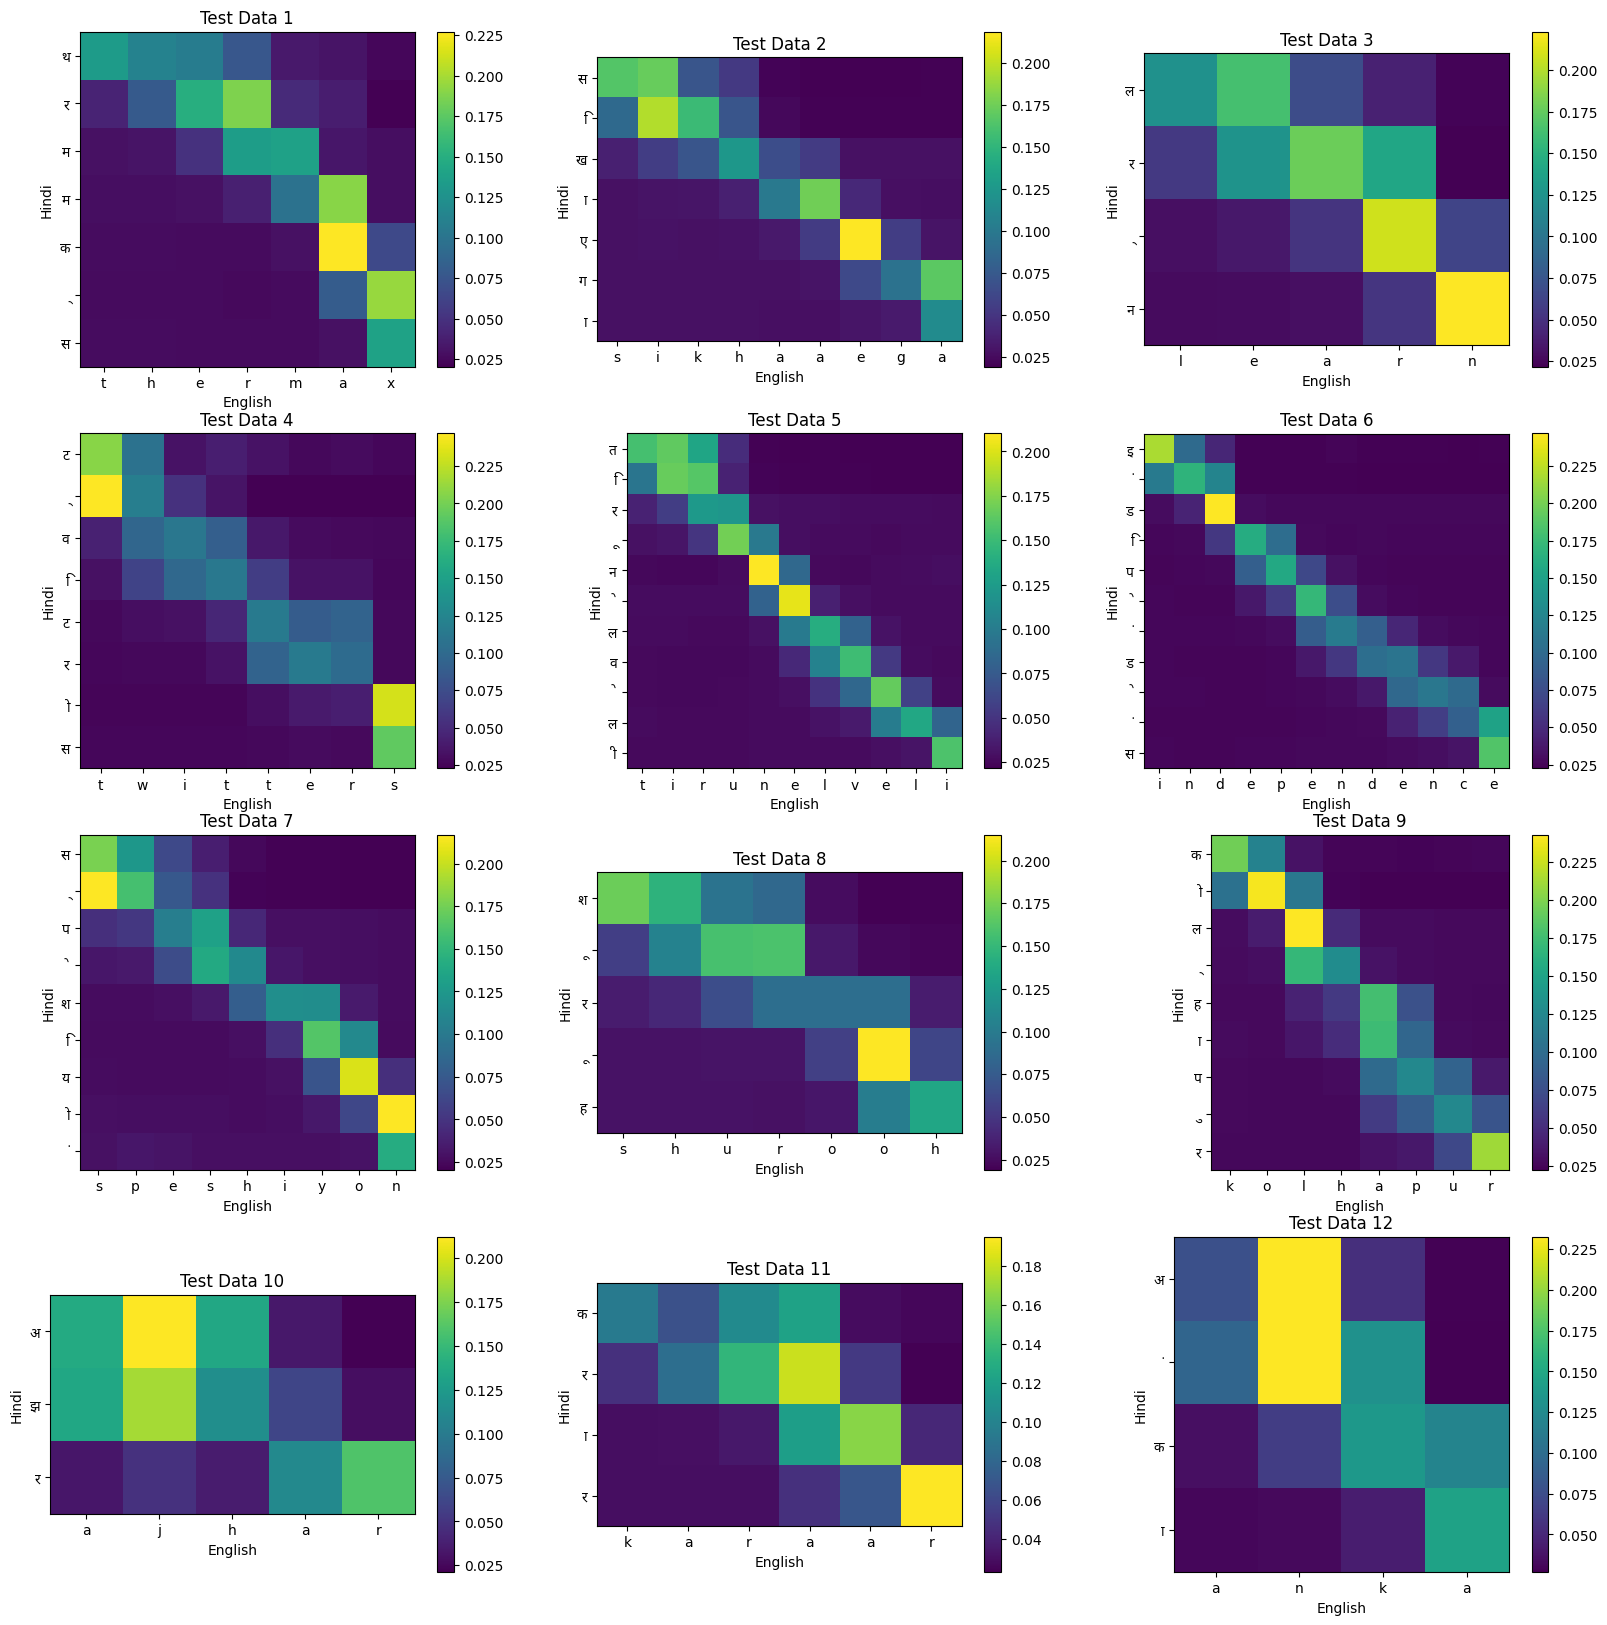

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy as np

def getTicks(test_input, acc_output, data_index):

    # put ticks into array by iterating test input and predicted of test and converting it into english-malayalam combination
    x_t = []
    y_t = []
    for i in range(len(test_input[data_index])):
        if(test_input[data_index][i].item() != 0 and test_input[data_index][i].item() != 1 and test_input[data_index][i].item() != 2):
            x_t.append(english_index_dict[test_input[data_index][i].item()])

    for i in range(len(acc_output[data_index])):
        if(acc_output[data_index][i].item() != 0 and acc_output[data_index][i].item() != 1 and acc_output[data_index][i].item() != 2):
            y_t.append(hindi_index_dict[acc_output[data_index][i].item()])

    return x_t, y_t

def plotHeatMap(test_input,acc_output,w,num_plots = 12):

    # Create subplots
    fig, ax = plt.subplots(4, 3,figsize=(20, 20))
    _ = plt.setp(ax)
    for data_index in range(num_plots):

        # get ticks
        x_t, y_t = getTicks(test_input, acc_output, data_index)

        # w contains al attention weights for each batches, so take weights batch by batch
        a = w[:,:,data_index]
        a = a.detach().cpu().numpy()

        #remove start and end token's weights
        a = a[1:len(y_t)+1,2:len(x_t)+2]

        # plot 3 subplots per row
        plt.sca(ax[data_index//3,data_index%3])

        # Heat map using sns library
#         sns.heatmap(a)
#         plt.xticks(np.arange(0.5, len(x_t)+0.5), x_t)

        # Anjali dataset to be used as correct font for malayalam in ticks for plot
#         mal_font = FontProperties(fname = '/kaggle/input/anjali/AnjaliOldLipi-Regular.ttf')
#         plt.yticks(np.arange(0.5, len(y_t)+0.5), y_t,fontproperties= mal_font)


        # Heat map using matplotlib
        plt.imshow(a, interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(0, len(x_t)), x_t)

        # Anjali dataset to be used as correct font for malayalam in ticks for plot
        mal_font = FontProperties(fname = '/content/NotoSansDevanagari-VariableFont_wdth,wght.ttf')

        plt.yticks(np.arange(0, len(y_t)), y_t,fontproperties= mal_font)

        plt.xlabel('English')
        plt.ylabel('Hindi')
        plt.title(f'Test Data {data_index + 1}')


#         plt.show()
    canvas = plt.gca().figure.canvas
    canvas.draw()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    # Save image to store it into wandb logs
    image = data.reshape(canvas.get_width_height()[::-1] + (3,))
    plt.show()

    return image

# store it into wandb

wandb.login(key = "90512e34eff1bdddba0f301797228f7b64f546fc")
wandb.init(project = 'DL_3_Q5_Heatmap_Plot')

if model.use_attention:
    acc_output = F.softmax(test_output,dim=2)
    acc_output = torch.argmax(acc_output,dim=2)
    acc_output.shape
    acc_output = acc_output.T

    w =  torch.mean(_weights,axis=2)

    image = plotHeatMap(test_input,acc_output,w)
    wandb.run.name = 'Attention_Heatmap_plots'
    wandb.log({"Attention_Weights" : [wandb.Image(image,caption=f"Attention weights_heatmap with Overall test accuracy={test_acc*100:.2f}% and test loss={test_loss:.4f}")]})
else:
    print("No Attention => No heatmap")
wandb.finish()
